<a href="https://colab.research.google.com/github/TOM-BOHN/MsDS-product-review-topic-modeling/blob/main/product_review_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Review Topic Modeling
**Thomas Bohn**   --   **2023-09-18**

A report focused on modeling topics on text review data from Amazon for clothing and shoes manufactured by Nike. Use unsupervised clustering methods to create popular topics in the review data.

--  [Main Report](https://github.com/TOM-BOHN/MsDS-product-review-topic-modeling/blob/main/product_review_topic_modeling.ipynb)  --  [Github Repo](https://github.com/TOM-BOHN/MsDS-product-review-topic-modeling)  --  [Presentation Slides](tbd)  --  [Presentation Video](tbd) --

# 1.&nbsp;Introduction

## Setup Functions

### Import Python Libraries

The following python libraries are used in this notebook.

In [1]:
# Special Install of Packages
print('[-] Importing packages...')
#special_install_tmtoolkit
import os
try:
  import tmtoolkit
except:
  print('starting patch of tmtoolkit.')
  !pip install --quiet -U "tmtoolkit[recommended,lda,sklearn,wordclouds,textproc_extra,topic_modeling_eval_extra]"
  print('finished patch of tmtoolkit.')
  os.kill(os.getpid(), 9)

#special_install_matplotlib
import os
import matplotlib
if matplotlib.__version__ != "3.1.3":
    print('starting patch of matplotlib.')
    !pip uninstall --quiet -y matplotlib
    !pip install --quiet matplotlib==3.1.3
    print('finished patch of matplotlib.')
    os.kill(os.getpid(), 9)

#special_install_lda
import os
try:
  from tmtoolkit.topicmod.tm_lda import compute_models_parallel
except:
  !pip install --quiet tmtoolkit['lda']
  from tmtoolkit.topicmod.tm_lda import compute_models_parallel

try:
  from lda import LDA
except:
  !pip install --quiet lda
  from lda import LDA

#special_install_pyLDAvis
try:
  import pyLDAvis
except:
  !pip install --quiet pyLDAvis==2.1.2
  import pyLDAvis


[-] Importing packages...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.9/320.9 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [116]:
print('[-] Importing packages...')
# File Connection and File Manipulation
import os
import pickle
import json
import glob
# Import Usability Functions
import logging
import warnings
# Basic Data Science Toolkits
import pandas as pd
import numpy as np
import math
import random
import time
from time import sleep
# Basic Data Vizualization
import seaborn as sns
import matplotlib.pyplot as plt
# Text Preprocessing (tmtoolkit)
import tmtoolkit
from tmtoolkit.corpus import Corpus, lemmatize, to_lowercase, remove_chars, filter_clean_tokens
from tmtoolkit.corpus import filter_for_pos, remove_common_tokens, remove_uncommon_tokens
from tmtoolkit.corpus import corpus_num_tokens, corpus_tokens_flattened
from tmtoolkit.corpus import doc_tokens, tokens_table, doc_labels, dtm
from tmtoolkit.corpus import vocabulary, vocabulary_size, vocabulary_counts
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from tmtoolkit.corpus.visualize import plot_doc_lengths_hist, plot_doc_frequencies_hist, plot_ranked_vocab_counts
#https://tmtoolkit.readthedocs.io/en/latest/preprocessing.html
# Text Preprocessing(other)
from string import punctuation
import nltk
import scipy.sparse
# Topic Modeling
from lda import LDA
import pyLDAvis
from tmtoolkit.topicmod import tm_lda
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words
from tmtoolkit.topicmod.model_io import save_ldamodel_to_pickle
from tmtoolkit.topicmod.model_io import load_ldamodel_from_pickle
from tmtoolkit.topicmod.model_io import ldamodel_top_doc_topics
from tmtoolkit.topicmod.evaluate import results_by_parameter
from tmtoolkit.topicmod.visualize import plot_eval_results
from tmtoolkit.topicmod.visualize import parameters_for_ldavis
from tmtoolkit.topicmod.visualize import generate_wordclouds_for_topic_words
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words
from tmtoolkit.bow.bow_stats import doc_lengths
# Sentiment Modeling
from textblob import TextBlob

[-] Importing packages...


### Set Global Variables

In [3]:
random.seed(20191120)   # to make the sampling reproducible
np.set_printoptions(precision=5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Verify GPU Runtime

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/bin/bash: line 1: nvidia-smi: command not found


In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('  [.] Your runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))

if ram_gb < 20:
  print('  [.] Not using a high-RAM runtime')
else:
  print('  [.] You are using a high-RAM runtime!')

  [.] Your runtime has 13.6 gigabytes of available RAM
  [.] Not using a high-RAM runtime


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Mount Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


### Setup Directories

In [7]:
ROOT_DIR = "/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/2_topic_modeling"
DATA_DIR = "%s/data" % ROOT_DIR
EVAL_DIR = "%s/evaluation" % ROOT_DIR
MODEL_DIR = "%s/models" % ROOT_DIR

#Create missing directories, if they don't exist
if not os.path.exists(DATA_DIR):
  # Create a new directory because it does not exist
  os.makedirs(DATA_DIR)
  print("The data directory is created!")
if not os.path.exists(EVAL_DIR):
  # Create a new directory because it does not exist
  os.makedirs(EVAL_DIR)
  print("The evaluation directory is created!")
if not os.path.exists(MODEL_DIR):
  # Create a new directory because it does not exist
  os.makedirs(MODEL_DIR)
  print("The model directory is created!")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 2.&nbsp;Data Source

## Copy Data From Source

In [ ]:
#!wget <URL> -P <COLAB PATH>
#source_url = 'http://128.138.93.164/meta_Clothing_Shoes_and_Jewelry.json.gz' # true source, need better link
source_url = 'https://docs.google.com/uc?export=download&id=12cPbdNpQ6Dmqg25Fb0kAxFSEug-8t3gc&confirm=t' # local source, working for testing
dest_path = '%s/meta_Clothing_Shoes_and_Jewelry.jsonl.gz' % DATA_DIR
!wget "$source_url" -O "$dest_path"


--2023-09-18 22:13:46--  https://docs.google.com/uc?export=download&id=12cPbdNpQ6Dmqg25Fb0kAxFSEug-8t3gc&confirm=t
Resolving docs.google.com (docs.google.com)... 108.177.126.138, 108.177.126.139, 108.177.126.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7qeuhp3jkprbc4o70snmnq820i7po11u/1695075225000/15741694635513001712/*/12cPbdNpQ6Dmqg25Fb0kAxFSEug-8t3gc?e=download&uuid=df5822a8-2268-40fd-a6f4-bb63239e6a05 [following]
--2023-09-18 22:13:47--  https://doc-0o-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7qeuhp3jkprbc4o70snmnq820i7po11u/1695075225000/15741694635513001712/*/12cPbdNpQ6Dmqg25Fb0kAxFSEug-8t3gc?e=download&uuid=df5822a8-2268-40fd-a6f4-bb63239e6a05
Resolving doc-0o-58-docs.googleusercontent.com (doc-0o-58-docs.googleusercontent.com)... 142.251.18.1

In [ ]:
#!wget <URL> -P <COLAB PATH>
#source_url = 'http://128.138.93.164/reviews_Clothing_Shoes_and_Jewelry.json.gz' # true source, need better link
source_url = "https://docs.google.com/uc?export=download&id=12detwlesuD7S-O8i9w4LOii1DWML0i7Q&confirm=t" # local source, working for testing
dest_path = '%s/reviews_Clothing_Shoes_and_Jewelry.json.gz' % DATA_DIR
file_name = 'reviews_Clothing_Shoes_and_Jewelry.json.gz'
print(dest_path)
!wget "$source_url" -O "$dest_path"

/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/2_topic_modeling/data/reviews_Clothing_Shoes_and_Jewelry.json.gz
--2023-09-18 22:14:37--  https://docs.google.com/uc?export=download&id=12detwlesuD7S-O8i9w4LOii1DWML0i7Q&confirm=t
Resolving docs.google.com (docs.google.com)... 108.177.126.138, 108.177.126.102, 108.177.126.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bhu56oc1bj6feidn253emcrplo7110r7/1695075225000/15741694635513001712/*/12detwlesuD7S-O8i9w4LOii1DWML0i7Q?e=download&uuid=ba539796-3687-4d5a-b0d9-600b1016498d [following]
--2023-09-18 22:14:38--  https://doc-0o-58-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bhu56oc1bj6feidn253emcrplo7110r7/1695075225000/15741694635513001712/*/12detwlesuD7S-O8i9w4LOii1DWML0i7Q?e=download&uuid=ba53979

In [ ]:
meta_file_path = '%s/meta_Clothing_Shoes_and_Jewelry.jsonl.gz' % DATA_DIR
review_file_path = '%s/reviews_Clothing_Shoes_and_Jewelry.json.gz' % DATA_DIR

!gzip -d "$meta_file_path"
!gzip -d "$review_file_path"

## Load the Product Data

In [69]:
##this assigns the filename we're trying to load in to a string variable
meta_file_path = '%s/meta_Clothing_Shoes_and_Jewelry.jsonl' % DATA_DIR
loadedjson = open(meta_file_path, 'r')

In [70]:
#The data used in this script comes from: http://jmcauley.ucsd.edu/data/amazon/links.html
#The data here is the 'per category' data for Clothing, Shoes and Jewelry
#use the above url to better understand the data, where it came from, and some
#tips on how to use it!

#getting reviews is going to be a two step process:
#1) go through the amazon product catalog for "Clothing, Shoes and Jewelery
#and extract out matching products by their ASIN
#2) go through the review data and parse out the matching reviews by ASIN

#1) - Extracting ASINs by brand
#First, let's iterate through the data and store it as a python dictionary

#let's set a counter to see how many products we have in the json
count = 0
start_time = time.time()
#loading the json file
#we've always got to initiate dictionaries before we can use them
allproducts = {}

#each line of data here is a product and its metadata
print('loading product data to dictionary:')
for aline in loadedjson:
    #creating a counter to know our progress in processing the entire catalog
    count += 1
    if count % 100000 == 0:
        #we're only going to print our count every 100k, this way we don't spam
        #our output console
        current_runtime = round(time.time() - start_time,3)
        print('[-] current progress:', count, 'and a runtime of', current_runtime, 'seconds.')
    #interestingly enough, this data isn't true JSON, instead it's python
    #dictionaries that have essentially been printed as text. It's odd, but if
    #we read the documentaion, all we need to do to load a dictionary is use
    #the eval function. https://www.programiz.com/python-programming/methods/built-in/eval
    #eval takes whatever string is passed to it, and interprets it as python code
    #and runs it. So here, it's exactly what we need to interpret a printed
    #python dictionary

    aproduct = eval(aline)

    #making a dictionary entry with the ASIN of the product as the key
    #and it's metadata as nested dictionaries
    allproducts[aproduct['asin']] = aproduct

loading product data to dictionary:
[-] current progress: 100000 and a runtime of 15.9 seconds.
[-] current progress: 200000 and a runtime of 28.832 seconds.
[-] current progress: 300000 and a runtime of 43.205 seconds.
[-] current progress: 400000 and a runtime of 56.007 seconds.
[-] current progress: 500000 and a runtime of 70.813 seconds.
[-] current progress: 600000 and a runtime of 86.489 seconds.
[-] current progress: 700000 and a runtime of 99.4 seconds.
[-] current progress: 800000 and a runtime of 117.976 seconds.
[-] current progress: 900000 and a runtime of 134.219 seconds.
[-] current progress: 1000000 and a runtime of 157.524 seconds.
[-] current progress: 1100000 and a runtime of 176.284 seconds.
[-] current progress: 1200000 and a runtime of 193.54 seconds.
[-] current progress: 1300000 and a runtime of 220.576 seconds.
[-] current progress: 1400000 and a runtime of 236.65 seconds.
[-] current progress: 1500000 and a runtime of 252.911 seconds.


In [71]:
#print a summary of the records processed
allproducts_length = len(allproducts)
current_runtime = round(time.time() - start_time,3)
print('Process completed for', count, 'of', allproducts_length, 'records with a final runtime of', current_runtime, 'seconds.')

Process completed for 1503384 of 1503384 records with a final runtime of 310.556 seconds.


In [76]:
#preview the product record
allproducts['B00KUSKHDC']

{'asin': 'B00KUSKHDC',
 'title': "Family Guy - Men's T-shirt Evil Monkey",
 'imUrl': 'http://ecx.images-amazon.com/images/I/41eUK6CAY4L._SX342_.jpg',
 'related': {'also_viewed': ['B004P0JEK8',
   'B00EC4UZ3M',
   'B000VYZEY2',
   'B00HZSI7QE']},
 'salesRank': {'Clothing': 288020},
 'categories': [['Clothing, Shoes & Jewelry', 'Men'],
  ['Clothing, Shoes & Jewelry',
   'Novelty, Costumes & More',
   'Novelty',
   'Clothing',
   'Men',
   'Shirts',
   'T-Shirts']]}

In [77]:
#save the files to disk
allproducts_file_path = '%s/allproducts.p' % DATA_DIR
pickle.dump(allproducts, open(allproducts_file_path, 'wb'))

## Summarize the Product Categories

In [ ]:
#Next we need to explore the product data to see what categories are common in the
#data. As you'll learn, product categories are wishywashy in that they can be
#product categories (e.g., baby, house and home), or they can be brands!
#We're already dealing with a subset of the product categories, Clothing, Shoes
#and Jewlery. We still need to find a list of product ids for our specific
#brand. To do this,We're going to use the 'categories' metadata field to find
#your brand

##Let's create a dictionary of all the product subcategories
#and by doing so, also come up with a list of brands and the number of products
#they have listed in the amazon product catalog

allcategories = {}
count = 0
start_time = time.time()

#each line of data here is a product and its metadata
print('loading categories data to dictionary:')
for aproduct in allproducts:
    #creating a counter to know our progress in processing the entire catalog
    count += 1
    if count % 100000 == 0:
        #we now know there are 1.5 million products, so we can build a counter
        #that tells how our processing is going. When the counter reaches one
        #we're done!
        current_progress = int(round(count/allproducts_length,2)*100)
        current_runtime = round(time.time() - start_time,3)
        print('[-] current progress:', current_progress, '%', 'and a runtime of', current_runtime, 'seconds.')

    #setting a dict up with just one product, so we can inspect and ref it
    aproduct = allproducts[aproduct]
    #creating a dictionary entry for each product category
    #also counting the occurances of each category
    if 'categories' in aproduct:
        for categories in aproduct['categories']:
            for acategory in categories:
                if acategory in allcategories:
                    allcategories[acategory] += 1
                if acategory not in allcategories:
                    allcategories[acategory] = 1

loading categories data to dictionary:
[-] current progress: 7 % and a runtime of 0.801 seconds.
[-] current progress: 13 % and a runtime of 1.545 seconds.
[-] current progress: 20 % and a runtime of 2.029 seconds.
[-] current progress: 27 % and a runtime of 2.492 seconds.
[-] current progress: 33 % and a runtime of 2.947 seconds.
[-] current progress: 40 % and a runtime of 3.423 seconds.
[-] current progress: 47 % and a runtime of 3.853 seconds.
[-] current progress: 53 % and a runtime of 4.283 seconds.
[-] current progress: 60 % and a runtime of 4.722 seconds.
[-] current progress: 67 % and a runtime of 5.135 seconds.
[-] current progress: 73 % and a runtime of 5.583 seconds.
[-] current progress: 80 % and a runtime of 5.983 seconds.
[-] current progress: 86 % and a runtime of 6.392 seconds.
[-] current progress: 93 % and a runtime of 6.81 seconds.
[-] current progress: 100 % and a runtime of 7.197 seconds.


In [ ]:
#print a summary of the categories processed
allcategories_length = len(allcategories)
current_runtime = round(time.time() - start_time,3)
print('Process completed for', allcategories_length, 'categories with a final runtime of', current_runtime, 'seconds.')

Process completed for 2773 catregories with a final runtime of 7.224 seconds.


In [ ]:
#create a sorted list of categories
sortedlist = []
#covert the dictionary to a list of tuples
for acategory in allcategories:
  sortedlist.append((allcategories[acategory],acategory))
#sort the list
sortedlist = sorted(sortedlist, reverse=True)
#print the top x records in the list
top_n = 20
for item in range(0,top_n):
  print('[',str(item).zfill(2),']', sortedlist[item])

[ 00 ] (3429257, 'Clothing, Shoes & Jewelry')
[ 01 ] (1086181, 'Women')
[ 02 ] (617092, 'Clothing')
[ 03 ] (541681, 'Men')
[ 04 ] (537761, 'Novelty, Costumes & More')
[ 05 ] (432653, 'Shoes')
[ 06 ] (339900, 'Novelty')
[ 07 ] (268065, 'Shoes & Accessories: International Shipping Available')
[ 08 ] (255454, 'Jewelry')
[ 09 ] (174962, 'Accessories')
[ 10 ] (97095, 'Girls')
[ 11 ] (93596, 'Tops & Tees')
[ 12 ] (87688, 'Dresses')
[ 13 ] (84549, 'T-Shirts')
[ 14 ] (82063, 'Boots')
[ 15 ] (80302, 'Shirts')
[ 16 ] (79897, 'Sandals')
[ 17 ] (79545, 'Watches')
[ 18 ] (77684, 'Boys')
[ 19 ] (73507, 'Jewelry: International Shipping Available')


In [ ]:
nike_categories = allcategories['Nike']
print(nike_categories, 'product records for Nike.')

8327 product records for Nike.


## Extract a List of Product Ids

In [ ]:
#Now, go ahead and use the Variable Expolorer in Spyder to locate a brand
#that has a lot of product entries! Alternatively, type allcategories['Brand name']
#to get a count for a specific brand. For instance:
#>>allcategories['Nike']
#>> 8327
#>>allcategories['adidas']
#>> 8645

#I'd reccommend at least 1.5k products, but you're welcome to try smaller counts
#all I care about is whether you have at least 2k reviews when it's all said and done


##Now we need to go through our newly first dictionary and extract out the
##matching ASINs for Nike

##First, create a set where we will store our ASINs
##We choose a set here because we don't want duplicates
allnikeasins = set()
count = 0
start_time = time.time()

for areview in allproducts:
    theproduct = allproducts[areview]
    count += 1
    if count % 100000 == 0:
        current_progress = int(round(count/allproducts_length,2)*100)
        current_runtime = round(time.time() - start_time,3)
        print('[-] current progress:', current_progress, '%', 'and a runtime of', current_runtime, 'seconds.')

    #let's iterate fore each category for a product, again, any given product
    #can be assigned multiple product categories,
    for categories in theproduct['categories']:
        #each category is actually encoded as a list (even though they should
        #just be strings, so we need to iterate one more time)
        for acategory in categories:
            #checking to see if the product category matches Nike
            #lowercasing the category string incase capitalization might get
            #in the way of a match
            if 'nike' in acategory.lower():
                #let's go ahead and store it to our set of Nike ASINs
                allnikeasins.add(theproduct['asin'])

[-] current progress: 7 % and a runtime of 0.311 seconds.
[-] current progress: 13 % and a runtime of 0.61 seconds.
[-] current progress: 20 % and a runtime of 0.932 seconds.
[-] current progress: 27 % and a runtime of 1.244 seconds.
[-] current progress: 33 % and a runtime of 1.558 seconds.
[-] current progress: 40 % and a runtime of 1.858 seconds.
[-] current progress: 47 % and a runtime of 2.165 seconds.
[-] current progress: 53 % and a runtime of 2.471 seconds.
[-] current progress: 60 % and a runtime of 2.753 seconds.
[-] current progress: 67 % and a runtime of 3.037 seconds.
[-] current progress: 73 % and a runtime of 3.338 seconds.
[-] current progress: 80 % and a runtime of 3.63 seconds.
[-] current progress: 86 % and a runtime of 3.911 seconds.
[-] current progress: 93 % and a runtime of 4.201 seconds.
[-] current progress: 100 % and a runtime of 4.649 seconds.


In [ ]:
#print a summary of the categories processed
allnikeasins_length = len(allnikeasins)
current_runtime = round(time.time() - start_time,3)
print('Process completed for', allnikeasins_length, 'records with a final runtime of', current_runtime, 'seconds.')

Process completed for 8327 records with a final runtime of 4.684 seconds.


In [ ]:
# write the ASINs out to a file as a checkpoint
outputfile = open('%s/allasins.txt' % DATA_DIR, 'w')

outputfile.write(','.join(allnikeasins))
outputfile.close()

## Load the Review Data

In [ ]:
#this assigns the filename we're trying to load in to a string variable
review_file_path = '%s/reviews_Clothing_Shoes_and_Jewelry.json' % DATA_DIR
loadedjson = open(review_file_path, 'r')

In [ ]:
#2) - Parsing the review data
#First, let's iterate through the data and store it as a python dictionary

#let's set a counter to see how many products we have in the json
count = 0
start_time = time.time()
#loading the json file
#we've always got to initiate dictionaries before we can use them
allreviews = {}

#each line of data here is a product and its metadata
print('loading review data to dictionary:')
for aline in loadedjson:
    #creating a counter to know our progress in processing the entire catalog
    count += 1
    if count % 500000 == 0:
        #we're only going to print our count every 100k, this way we don't spam
        #our output console
        current_runtime = round(time.time() - start_time,3)
        print('[-] current progress:', count, 'and a runtime of', current_runtime, 'seconds.')
    #interestingly enough, this data isn't true JSON, instead it's python
    #dictionaries that have essentially been printed as text. It's odd, but if
    #we read the documentaion, all we need to do to load a dictionary is use
    #the eval function. https://www.programiz.com/python-programming/methods/built-in/eval
    #eval takes whatever string is passed to it, and interprets it as python code
    #and runs it. So here, it's exactly what we need to interpret a printed
    #python dictionary

    areview = eval(aline)

    #making a dictionary entry with the iteration count as the review key
    #and it's metadata as nested dictionaries
    allreviews[count] = areview
print('completed load of review data to dictionary.')

loading review data to dictionary:
[-] current progress: 500000 and a runtime of 36.032 seconds.
[-] current progress: 1000000 and a runtime of 68.749 seconds.
[-] current progress: 1500000 and a runtime of 101.409 seconds.
[-] current progress: 2000000 and a runtime of 132.848 seconds.
[-] current progress: 2500000 and a runtime of 165.368 seconds.
[-] current progress: 3000000 and a runtime of 199.647 seconds.
[-] current progress: 3500000 and a runtime of 236.8 seconds.
[-] current progress: 4000000 and a runtime of 275.601 seconds.
[-] current progress: 4500000 and a runtime of 308.862 seconds.
[-] current progress: 5000000 and a runtime of 343.602 seconds.
[-] current progress: 5500000 and a runtime of 372.095 seconds.


In [ ]:
#print a summary of the records processed
allreviews_length = len(allreviews)
current_runtime = round(time.time() - start_time,3)
print('Process completed for', count, 'of', allreviews_length, 'records with a final runtime of', current_runtime, 'seconds.')

Process completed for 5748920 of 5748920 records with a final runtime of 417.348 seconds.


## Extract a List of Reviews Related to the Product Ids

In [ ]:
#Load the list of Nike Asins

allnikeasins = []
allasins_file_path = '%s/allasins.txt' % DATA_DIR

#open the file and load to a list
for data in open(allasins_file_path, 'r'):
  asins = data.split(',')
  for anasin in asins:
    allnikeasins.append(anasin)

In [ ]:
#print a summary of the records processed
allnikeasins_length = len(allnikeasins)
print('Process completed for', allnikeasins_length, 'records.')
print('First 5 Asins in list:', allnikeasins[0:5])

Process completed for 8327 records.
First 5 Asins in list: ['B00DT6VLOQ', 'B001LQK6L0', 'B00ANBSBDY', 'B00AQL3UDW', 'B004TU1VV4']


In [ ]:
#Now, we need to go through all the reviews and pick out the reviews that
#correspond to the matching ASINs, that is reviews that are tied to Nike ASINs

#let's set a counter to see how many products we have in the json
count = 0
start_time = time.time()
#loading the json file
#we've always got to initiate dictionaries before we can use them
nikereviews = {}

#each line of data here is a product and its metadata
print('loading review data to dictionary:')
for areview in allreviews:
  count += 1
  if count % 500000 == 0:
      current_progress = int(round(count/allreviews_length,2)*100)
      current_runtime = round(time.time() - start_time,3)
      print('[-] current progress:', current_progress, '%', 'and a runtime of', current_runtime, 'seconds.')
  #setting current review as a dictionary, so we can easily reference its
  #entries
  thereview = allreviews[areview]
  theasin = thereview['asin']
  reviewerid = thereview['reviewerID']
  if theasin in allnikeasins:
      #im setting the key here as something unique. if we just did by asin
      #we'd only have one review for each asin, with the last review the only
      #one being stored
      thekey = '%s.%s' % (theasin, reviewerid)
      nikereviews[thekey] = thereview
print('completed load of review data to dictionary.')

loading review data to dictionary:
[-] current progress: 9 % and a runtime of 95.051 seconds.
[-] current progress: 17 % and a runtime of 188.805 seconds.
[-] current progress: 26 % and a runtime of 281.424 seconds.
[-] current progress: 35 % and a runtime of 374.236 seconds.
[-] current progress: 43 % and a runtime of 466.713 seconds.
[-] current progress: 52 % and a runtime of 559.326 seconds.
[-] current progress: 61 % and a runtime of 654.168 seconds.
[-] current progress: 70 % and a runtime of 747.421 seconds.
[-] current progress: 78 % and a runtime of 840.299 seconds.
[-] current progress: 87 % and a runtime of 933.018 seconds.
[-] current progress: 96 % and a runtime of 1025.682 seconds.
completed load of review data to dictionary.


In [ ]:
#print a summary of the records processed
nikereviews_length = len(nikereviews)
current_runtime = round(time.time() - start_time,3)
print('Process completed for', count, 'of', nikereviews_length, 'records with a final runtime of', current_runtime, 'seconds.')

Process completed for 5748920 of 21570 records with a final runtime of 1077.421 seconds.


In [ ]:
#save our data to a JSON dictionary
allnikereviews_file_path = '%s/allnikereviews.json' % DATA_DIR
json.dump(nikereviews, open(allnikereviews_file_path, 'w'))

## Preview a Record from the File

In [ ]:
#this assigns the filename we're trying to load
allnikereviews_file_path = '%s/allnikereviews.json' % DATA_DIR
json_file = json.load(open(allnikereviews_file_path, 'r'))

In [ ]:
#select a random review
count = 0
for a_review in json_file:
  count += 1
  if count % 1000 == 0:
    the_review = json_file[a_review]
    print(the_review)
    #sleep(10)
  if count >= 10000:
    break

{'reviewerID': 'A7H6Q3JAE3UTR', 'asin': 'B000G42Z2Q', 'reviewerName': 'april fritsche', 'helpful': [0, 0], 'reviewText': 'I bought these for my son and he loves them.  He said that that r very comfortable.  He said he wears them all the time.  He said that they look great.', 'overall': 5.0, 'summary': 'love them', 'unixReviewTime': 1388620800, 'reviewTime': '01 2, 2014'}
{'reviewerID': 'A278R123DX0CLR', 'asin': 'B0013UXIAK', 'reviewerName': 'AQB', 'helpful': [0, 2], 'reviewText': 'Too much money for the pair. I saw a better pair for less price. I will shop around Zappos or Nike websites next time.', 'overall': 3.0, 'summary': 'its ok', 'unixReviewTime': 1377561600, 'reviewTime': '08 27, 2013'}
{'reviewerID': 'A1CZIWT35UVJS6', 'asin': 'B001PA87L8', 'reviewerName': 'Courtney', 'helpful': [1, 1], 'reviewText': "I love these shoes, they are perfect. Very comfy especially since I'm on my feet all day at work. It's wierd that they don't have a tongue but it only makes them fit better.", 'ove

In [ ]:
#print the review to the screen
the_review

{'reviewerID': 'AGP3D5ZB7N3NA',
 'asin': 'B00594DYW8',
 'reviewerName': 'S. M. Hughes "mom of 2"',
 'helpful': [0, 0],
 'reviewText': 'I absolutely love this pair of shoes. I am more prone to barefoot running, and the flexibility of these shoes are not at all restrictive on my feet and they feel great! I was so very happy to find them for a good price! Seller shipped very quickly and overall, the experience with this purchase was A+!',
 'overall': 5.0,
 'summary': 'Great Item, great seller!',
 'unixReviewTime': 1322524800,
 'reviewTime': '11 29, 2011'}

## Extract a List of Products Related to Product Ids

In [78]:
#Load the list of Nike Asins

allnikeasins = []
allasins_file_path = '%s/allasins.txt' % DATA_DIR

#open the file and load to a list
for data in open(allasins_file_path, 'r'):
  asins = data.split(',')
  for anasin in asins:
    allnikeasins.append(anasin)

In [79]:
#print a summary of the records processed
allnikeasins_length = len(allnikeasins)
print('Process completed for', allnikeasins_length, 'records.')
print('First 5 Asins in list:', allnikeasins[0:5])

Process completed for 8327 records.
First 5 Asins in list: ['B00DT6VLOQ', 'B001LQK6L0', 'B00ANBSBDY', 'B00AQL3UDW', 'B004TU1VV4']


In [80]:
#the path for the all product dict
allproducts_file_path = '%s/allproducts.p' % DATA_DIR
#load the dict
allproducts =  pickle.load(open(allproducts_file_path, 'rb'))

In [81]:
print('size of the full product catelog:', len(allproducts))
keys = set(allnikeasins).intersection(allproducts)
allnikeproducts = {key:allproducts[key] for key in keys}
print('size of the nike product catelog:', len(allnikeproducts))

size of the full product catelog: 1503384
size of the nike product catelog: 8327


In [83]:
#save the files to disk
allnikeproducts_file_path = '%s/allnikeproducts.p' % DATA_DIR
pickle.dump(allnikeproducts, open(allnikeproducts_file_path, 'wb'))

# 3.&nbsp;Preprocessing the Data

## Load the Nike Review Data

In [ ]:
#this assigns the filename we're trying to load
allnikereviews_file_path = '%s/allnikereviews.json' % DATA_DIR
json_file = json.load(open(allnikereviews_file_path, 'r'))

In [ ]:
#extract review text from all review details
reviews = []
for a_review in json_file:
    the_review = json_file[a_review]
    text = the_review["reviewText"]
    reviews.append(text)

In [ ]:
#create a corpus of the nike reviews
corpus = Corpus({ i:r for i, r in enumerate(reviews)}, language='en')

In [ ]:
#print the length of the corpus
corpus_length = len(corpus)
print('Length of the Corpus:', corpus_length)

Length of the Corpus: 21570


In [ ]:
#print a random corpus
k = 91
print('record for key', k, 'contains:')
print(corpus[k])

record for key 91 contains:
Document "91" (102 tokens, 9 token attributes, 2 document attributes)


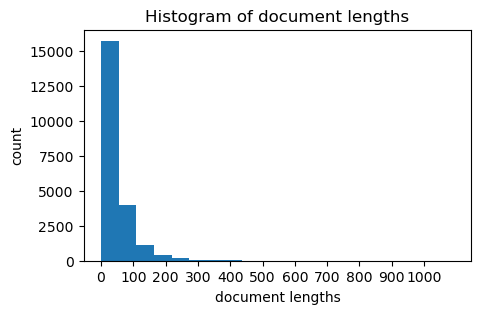

In [ ]:
#view a histogram of document lengths
fig, ax = plt.subplots(figsize=(5, 3))   # make the plot larger
plot_doc_lengths_hist(fig, ax, corpus, y_log=False, bins=20)  # use 20 bins
ax.set_xticks(range(0, 1001, 100))    # set x axis ticks and range
plt.show()

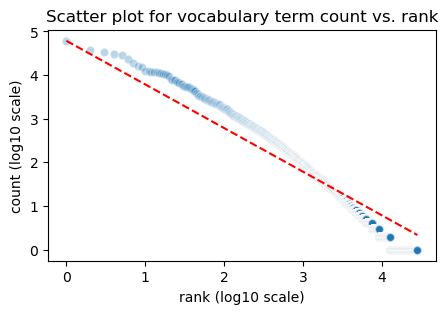

In [ ]:
#rank-frequency distribution plot for token frequencies
fig, ax = plt.subplots(figsize=(5, 3))
plot_ranked_vocab_counts(fig, ax, corpus, zipf=True)
plt.show();

In [ ]:
#save the files to disk
corpus_file_path = '%s/corpus_source.p' % DATA_DIR
pickle.dump(corpus, open(corpus_file_path, 'wb'))

In [ ]:
#save the raw text of reviews to disk
text_file_path = '%s/corpus_raw_text.p' % DATA_DIR
pickle.dump(reviews, open(text_file_path, 'wb'))

## Preprocess Text Data

In [ ]:
#location of corpus files
corpus_file_path = '%s/corpus_source.p' % DATA_DIR
#load the corpus
corpus = pickle.load(open(corpus_file_path, 'rb'))

In [ ]:
#print a random corpus
k = 91
print('record for key', k, 'contains:')
print(corpus[k])

record for key 91 contains:
Document "91" (102 tokens, 9 token attributes, 2 document attributes)


In [ ]:
####create an english pre-processor
####preproc = TMPreproc(corpus, language='en')
####tag the words with parts of speach
####preproc.pos_tag()
# lemmatize the words (convert to root base)
lemmatize(corpus, inplace=True)
# convert words to lowercase
to_lowercase(corpus, inplace=True)
# remove special charecters
#####preproc.remove_special_chars_in_tokens()
remove_chars(corpus, chars=punctuation, inplace=True)
# add custom stopwords to remove for urls and not
####preproc.add_stopwords(['http', 'nt'])       #####
filter_clean_tokens(corpus, remove_stopwords=True, inplace=True)
# limit words to nouns, verbs, and adjectives
filter_for_pos(corpus, search_pos=['N', 'V', 'ADJ'], inplace=True)
# remove numbers and any word shorter than 2 characters
filter_clean_tokens(corpus, remove_numbers=True, inplace=True)
filter_clean_tokens(corpus, remove_shorter_than=2, inplace=True)
# remove tokens that are fairly common
remove_common_tokens(corpus, df_threshold=0.8, inplace=True)
# remove tokens that are extreamly rare
remove_uncommon_tokens(corpus, df_threshold=0.01, inplace=True)

## Review Preprocessing of Text

In [ ]:
#create a summary of a sample
def preview_sample_review(corpus, k = 0):
  samp_texty = corpus[k]
  tok = doc_tokens(corpus, with_attr=True)
  samp_token_list = tok[k]['token']
  samp_token_list_length = len(samp_token_list)

  #print a random corpus
  print('record for key', k, 'contains:')
  print(corpus[k])
  print('the text contains', samp_token_list_length, 'tokens.')
  print('sample token list:', samp_token_list[0:10])
  print()

In [ ]:
preview_sample_review(corpus, k = 91)
preview_sample_review(corpus, k = 1)
preview_sample_review(corpus, k = 2000)

record for key 91 contains:
Document "91" (17 tokens, 9 token attributes, 2 document attributes)
the text contains 17 tokens.
sample token list: ['watch', 'buy', 'find', 'nike', 'get', 'small', 'woman', 'pay', 'man', 'product']

record for key 1 contains:
Document "1" (7 tokens, 9 token attributes, 2 document attributes)
the text contains 7 tokens.
sample token list: ['cute', 'fit', 'small', 'wrist', 'wear', 'love', 'watch']

record for key 2000 contains:
Document "2000" (8 tokens, 9 token attributes, 2 document attributes)
the text contains 8 tokens.
sample token list: ['great', 'shoe', 'fit', 'comfortable', 'shoe', 'recommend', 'awesome', 'price']



In [ ]:
#create a summary of the preprocess
n = 5
vocab_size = vocabulary_size(corpus)
tokens_table = tokens_table(corpus)
#print a summary of the preprocess
print('corpus vocabulary size:', vocab_size)
print('first', n, 'rows of tokens table:')
print(tokens_table.head(5))

corpus vocabulary size: 245
first 5 rows of tokens table:
   doc  position     token  is_punct  is_stop     lemma  like_num   pos  tag
0    0         0   receive     False    False   receive     False  VERB  VBD
1    0         1      blue     False    False      blue     False   ADJ   JJ
2    0         2      show     False    False      show     False  VERB  VBN
3    0         3    change     False    False    change     False  VERB  VBP
4    0         4  daughter     False    False  daughter     False  NOUN   NN


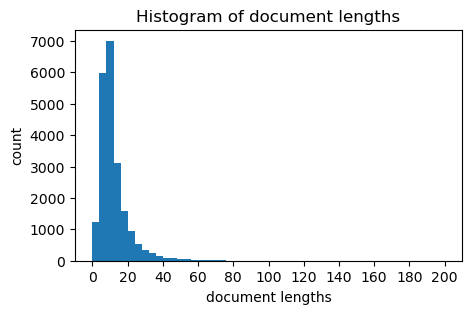

In [ ]:
#view a histogram of document lengths
fig, ax = plt.subplots(figsize=(5, 3))   # make the plot larger
plot_doc_lengths_hist(fig, ax, corpus, y_log=False, bins=50)  # use 20 bins
ax.set_xticks(range(0, 201, 20))    # set x axis ticks and range
plt.show()

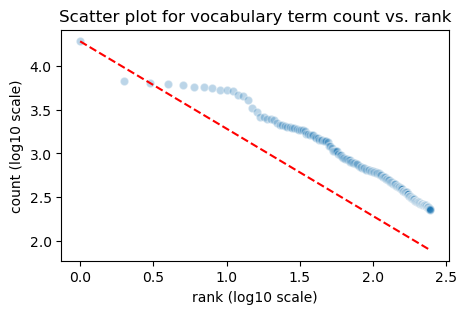

In [ ]:
#rank-frequency distribution plot for token frequencies
fig, ax = plt.subplots(figsize=(5, 3))
plot_ranked_vocab_counts(fig, ax, corpus, zipf=True)
plt.show();

## Save the Preprocessed Data

In [ ]:
#create the document labels
doc_lbls = np.array(doc_labels(corpus))
#preview the document labels
print(doc_lbls[:10])

[0 1 2 3 4 5 6 7 8 9]


In [ ]:
#create the vocabulary
vocab = np.array(vocabulary(corpus))
#preview the document labels
print(vocab[:10])

['able' 'air' 'amazing' 'amazon' 'ankle' 'arch' 'area' 'arrive' 'ask'
 'awesome']


In [ ]:
#create the document-term matrix (DTM)
dtm_main = dtm(corpus)
#dtm_main = scipy.sparse.csr_matrix(dtm_main)
#preview the dtm
dtm_main

<21570x245 sparse matrix of type '<class 'numpy.int32'>'
	with 212452 stored elements in Compressed Sparse Row format>

In [ ]:
#save the files to disk
corpus_file_path = '%s/corpus.p' % DATA_DIR
doc_labels_file_path = '%s/doc_labels.p' % DATA_DIR
vocab_file_path = '%s/vocab.p' % DATA_DIR
dtm_file_path = '%s/dtm_main.npz' % DATA_DIR

pickle.dump(corpus, open(corpus_file_path, 'wb') )
pickle.dump(doc_lbls, open(doc_labels_file_path, 'wb'))
pickle.dump(vocab, open(vocab_file_path, 'wb'))
scipy.sparse.save_npz(dtm_file_path, dtm_main)

# 4.&nbsp;Model: Parameter Tuning

## Import the Corpus

In [8]:
#location of corpus files
corpus_file_path = '%s/corpus.p' % DATA_DIR
doc_labels_file_path = '%s/doc_labels.p' % DATA_DIR
vocab_file_path = '%s/vocab.p' % DATA_DIR
dtm_file_path = '%s/dtm_main.npz' % DATA_DIR

#load the corpus
corpus = pickle.load(open(corpus_file_path, 'rb'))
doc_lbls = pickle.load(open(doc_labels_file_path, 'rb'))
dtm_main = scipy.sparse.load_npz(dtm_file_path)
vocab = pickle.load(open(vocab_file_path, 'rb'))

#preview the document labels
print(doc_lbls[:10])
print(vocab[:10])
dtm_main

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[0 1 2 3 4 5 6 7 8 9]
['able' 'air' 'amazing' 'amazon' 'ankle' 'arch' 'area' 'arrive' 'ask'
 'awesome']


<21570x245 sparse matrix of type '<class 'numpy.int32'>'
	with 212452 stored elements in Compressed Sparse Row format>

In [9]:
# suppress the "INFO" messages and warnings from lda
logger = logging.getLogger('lda')
logger.addHandler(logging.NullHandler())
logger.propagate = False
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Model Evaluation Functions

In [21]:
def build_param_inputs(kmax = 100, eta_factor = 1, alpha_factor = 1):
  #setup parameters
  const_params = {'n_iter': 500,'eta': round(0.1/eta_factor,5), 'random_state': 20191122}
  if kmax <=50:
   ks = list(range(5, kmax+1, 5))
  elif kmax <=100:
    ks = list(range(10, kmax+1, 10))
  else:
    ks = list(range(10, 100, 10)) + list(range(100, kmax+1, 20))
  varying_params = [dict(n_topics=k, alpha=round(1/(alpha_factor*k), 5)) for k in ks]
  num_trials = len(varying_params)
  #display the parameter selections
  print('[.] constant parameters:', const_params)
  print('[.] number of topics to try:', ks)
  print('[.] number of trials:', num_trials)
  print('[.] variable parameter trials:', varying_params)

  return varying_params, const_params

In [228]:
def build_param_inputs_fixed(kmax = 100, eta_value = .1, alpha_value = 1):
  #setup parameters
  const_params = {'n_iter': 500,'eta': eta_value, 'random_state': 20191122}
  if kmax <=50:
   ks = list(range(5, kmax+1, 5))
  elif kmax <=100:
    ks = [5,10,15] + list(range(20, kmax+1, 10))
  else:
    ks = list(range(10, 100, 10)) + list(range(100, kmax+1, 20))
  varying_params = [dict(n_topics=k, alpha=alpha_value) for k in ks]
  num_trials = len(varying_params)
  #display the parameter selections
  print('[.] constant parameters:', const_params)
  print('[.] number of topics to try:', ks)
  print('[.] number of trials:', num_trials)
  print('[.] variable parameter trials:', varying_params)

  return varying_params, const_params

In [23]:
def evaluate_model_results_custom(dtm_p, varying_p, const_p):
  #evaluate model results
  eval_results = tm_lda.evaluate_topic_models(dtm_p,
                                              varying_parameters = varying_p,
                                              constant_parameters = const_p,
                                              metric = ['arun_2010','cao_juan_2009','coherence_mimno_2011']
                                              )
  results_by_n_topics = results_by_parameter(eval_results, 'n_topics')
  results_by_n_topics = [(x, {key: round(value, 3) for key, value in inner_dict.items()}) for x, inner_dict in results_by_n_topics]
  #display the results of the models as text
  print('[.] number of results calculated:', len(results_by_n_topics))
  print('[.] results by n topic models:', results_by_n_topics)

  return results_by_n_topics

In [14]:
# plot the results of the model trials
#plot_eval_results(eval_results = results_by_n_topics, figsize=(8, 6))
#I cannot get this function to work for the life of me
#package conflict with version of pyplot

In [24]:
def plot_eval_results_custom(results_by_n_topics):
  # Extract data from results_by_n_topics
  n_topics = [item[0] for item in results_by_n_topics]
  arun_2010_values = [item[1]['arun_2010'] for item in results_by_n_topics]
  cao_juan_2009_values = [item[1]['cao_juan_2009'] for item in results_by_n_topics]
  coherence_mimno_2011_values = [item[1]['coherence_mimno_2011'] for item in results_by_n_topics]

  # Create subplots with a single row and multiple columns
  fig, axes = plt.subplots(1, 3, figsize=(12, 3))  # Adjust the figure size as needed
  fs = 8

  # Plot Arun 2010 Metric
  axes[0].plot(n_topics, arun_2010_values, label='Arun 2010', marker='o')
  axes[0].set_xlabel('Number of Topics', fontsize=fs)
  axes[0].set_ylabel('Metric Value', fontsize=fs)
  axes[0].set_title('Minimize: Arun 2010', fontsize=fs)

  # Plot Cao Juan 2009 Metric
  axes[1].plot(n_topics, cao_juan_2009_values, label='Cao Juan 2009', marker='o')
  axes[1].set_xlabel('Number of Topics', fontsize=fs)
  axes[1].set_ylabel('Metric Value', fontsize=fs)
  axes[1].set_title('Minimize: Cao Juan 2009', fontsize=fs)

  # Plot Coherence Mimno 2011 Metric
  axes[2].plot(n_topics, coherence_mimno_2011_values, label='Coherence Mimno 2011', marker='o')
  axes[2].set_xlabel('Number of Topics', fontsize=fs)
  axes[2].set_ylabel('Metric Value', fontsize=fs)
  axes[2].set_title('Maximize: Coherence Mimno 2011', fontsize=fs)

  # Adjust layout spacing
  plt.tight_layout()

  # Show the plots
  plt.show()

## Round 1: Evaluate Model Options

- [evaluate_topic_models()](https://tmtoolkit.readthedocs.io/en/latest/api.html#tmtoolkit.topicmod.tm_lda.evaluate_topic_models)
- [Guide: Evaluate Topic Model](https://tmtoolkit.readthedocs.io/en/latest/topic_modeling.html#Evaluation-of-topic-models)
- [tm_lda](https://tmtoolkit.readthedocs.io/en/latest/api.html#module-tmtoolkit.topicmod.tm_lda)

A high alpha value indicates that each document contains most of the topics and on the contrary, a lower alpha value indicates that the documents are likely to contain a fewer number of topic.

A Higher value of η indicates that the topics are likely to cover most of the words and on the contrary, lower eta value indicates that the topics are likely to contain a fewer number of words.

constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
number of trials: 11
variable parameter trials: [{'n_topics': 5, 'alpha': 0.2}, {'n_topics': 10, 'alpha': 0.1}, {'n_topics': 20, 'alpha': 0.05}, {'n_topics': 30, 'alpha': 0.03333}, {'n_topics': 40, 'alpha': 0.025}, {'n_topics': 50, 'alpha': 0.02}, {'n_topics': 60, 'alpha': 0.01667}, {'n_topics': 70, 'alpha': 0.01429}, {'n_topics': 80, 'alpha': 0.0125}, {'n_topics': 90, 'alpha': 0.01111}, {'n_topics': 100, 'alpha': 0.01}]
number of results calculated: 11
results by n topic models: [(5, {'arun_2010': 0.081, 'cao_juan_2009': 0.503, 'coherence_mimno_2011': -394.849}), (10, {'arun_2010': 0.141, 'cao_juan_2009': 0.443, 'coherence_mimno_2011': -417.351}), (20, {'arun_2010': 0.187, 'cao_juan_2009': 0.401, 'coherence_mimno_2011': -412.594}), (30, {'arun_2010': 0.297, 'cao_juan_2009': 0.373, 'coherence_mimno_2011': -432.726}), (40, {'arun_2010': 0.29, '

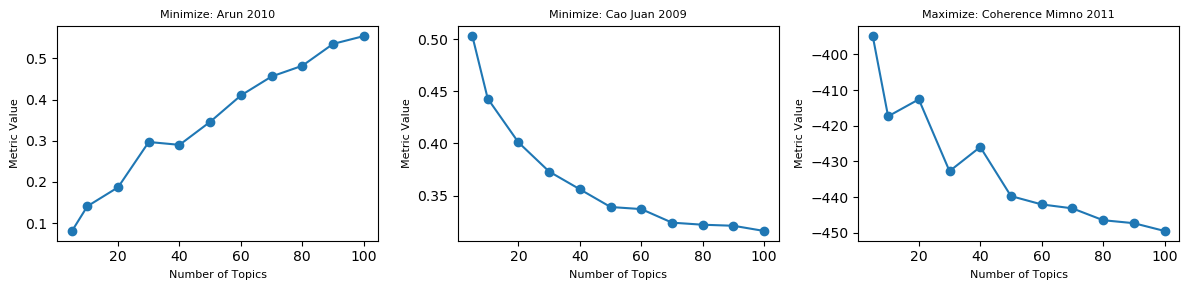

In [ ]:
# run calculations and vizualize
varying_params, const_params = build_param_inputs(kmax = 100, eta_factor = 1, alpha_factor = 1)
results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_main, varying_p = varying_params, const_p = const_params)
plot_eval_results_custom(results_by_n_topics)

running the evaluation for: eta_0.1__alpha_0.1
constant parameters: {'n_iter': 500, 'eta': 1.0, 'random_state': 20191122}
number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
number of trials: 11
variable parameter trials: [{'n_topics': 5, 'alpha': 2.0}, {'n_topics': 10, 'alpha': 1.0}, {'n_topics': 20, 'alpha': 0.5}, {'n_topics': 30, 'alpha': 0.33333}, {'n_topics': 40, 'alpha': 0.25}, {'n_topics': 50, 'alpha': 0.2}, {'n_topics': 60, 'alpha': 0.16667}, {'n_topics': 70, 'alpha': 0.14286}, {'n_topics': 80, 'alpha': 0.125}, {'n_topics': 90, 'alpha': 0.11111}, {'n_topics': 100, 'alpha': 0.1}]
number of results calculated: 11
results by n topic models: [(5, {'arun_2010': 0.058, 'cao_juan_2009': 0.221, 'coherence_mimno_2011': -444.095}), (10, {'arun_2010': 0.098, 'cao_juan_2009': 0.187, 'coherence_mimno_2011': -494.579}), (20, {'arun_2010': 0.143, 'cao_juan_2009': 0.171, 'coherence_mimno_2011': -493.464}), (30, {'arun_2010': 0.18, 'cao_juan_2009': 0.163, 'coherence_mimno_2011

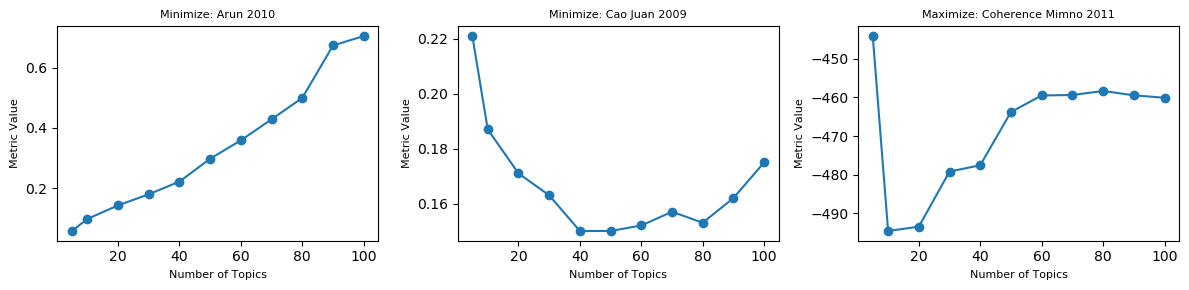

running the evaluation for: eta_0.1__alpha_001
constant parameters: {'n_iter': 500, 'eta': 1.0, 'random_state': 20191122}
number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
number of trials: 11
variable parameter trials: [{'n_topics': 5, 'alpha': 0.2}, {'n_topics': 10, 'alpha': 0.1}, {'n_topics': 20, 'alpha': 0.05}, {'n_topics': 30, 'alpha': 0.03333}, {'n_topics': 40, 'alpha': 0.025}, {'n_topics': 50, 'alpha': 0.02}, {'n_topics': 60, 'alpha': 0.01667}, {'n_topics': 70, 'alpha': 0.01429}, {'n_topics': 80, 'alpha': 0.0125}, {'n_topics': 90, 'alpha': 0.01111}, {'n_topics': 100, 'alpha': 0.01}]
number of results calculated: 11
results by n topic models: [(5, {'arun_2010': 0.086, 'cao_juan_2009': 0.519, 'coherence_mimno_2011': -389.767}), (10, {'arun_2010': 0.151, 'cao_juan_2009': 0.458, 'coherence_mimno_2011': -424.536}), (20, {'arun_2010': 0.222, 'cao_juan_2009': 0.42, 'coherence_mimno_2011': -414.293}), (30, {'arun_2010': 0.284, 'cao_juan_2009': 0.393, 'coherence_mimno

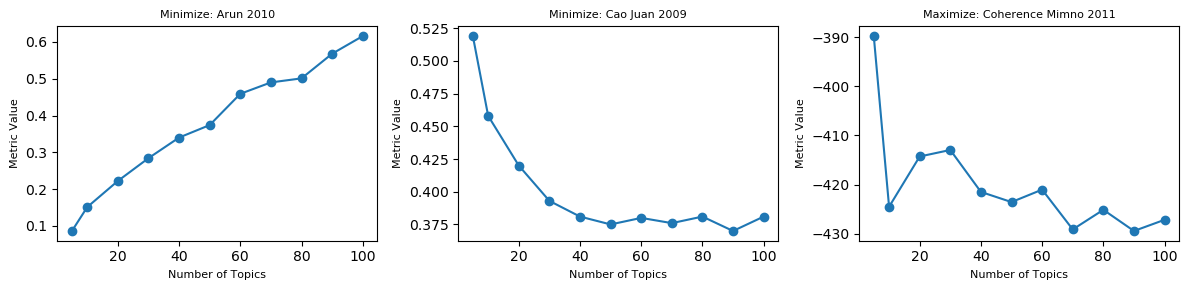

running the evaluation for: eta_0.1__alpha_010
constant parameters: {'n_iter': 500, 'eta': 1.0, 'random_state': 20191122}
number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
number of trials: 11
variable parameter trials: [{'n_topics': 5, 'alpha': 0.02}, {'n_topics': 10, 'alpha': 0.01}, {'n_topics': 20, 'alpha': 0.005}, {'n_topics': 30, 'alpha': 0.00333}, {'n_topics': 40, 'alpha': 0.0025}, {'n_topics': 50, 'alpha': 0.002}, {'n_topics': 60, 'alpha': 0.00167}, {'n_topics': 70, 'alpha': 0.00143}, {'n_topics': 80, 'alpha': 0.00125}, {'n_topics': 90, 'alpha': 0.00111}, {'n_topics': 100, 'alpha': 0.001}]
number of results calculated: 11
results by n topic models: [(5, {'arun_2010': 0.21, 'cao_juan_2009': 0.651, 'coherence_mimno_2011': -385.852}), (10, {'arun_2010': 0.438, 'cao_juan_2009': 0.653, 'coherence_mimno_2011': -382.118}), (20, {'arun_2010': 0.584, 'cao_juan_2009': 0.609, 'coherence_mimno_2011': -395.966}), (30, {'arun_2010': 0.671, 'cao_juan_2009': 0.621, 'coherenc

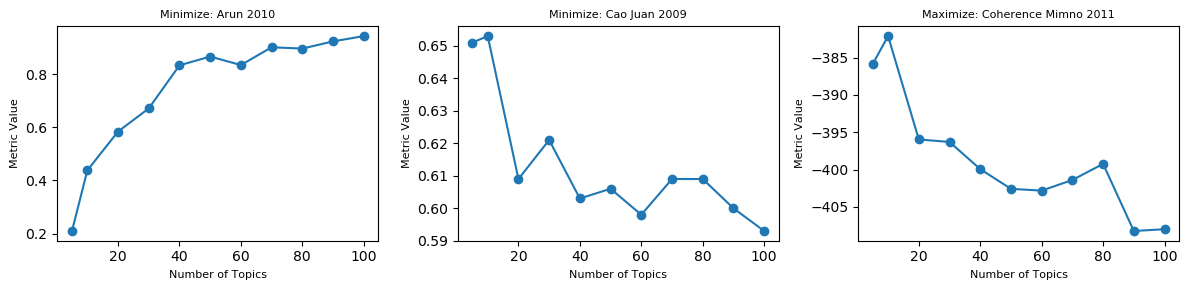

running the evaluation for: eta_0.1__alpha_100
constant parameters: {'n_iter': 500, 'eta': 1.0, 'random_state': 20191122}
number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
number of trials: 11
variable parameter trials: [{'n_topics': 5, 'alpha': 0.002}, {'n_topics': 10, 'alpha': 0.001}, {'n_topics': 20, 'alpha': 0.0005}, {'n_topics': 30, 'alpha': 0.00033}, {'n_topics': 40, 'alpha': 0.00025}, {'n_topics': 50, 'alpha': 0.0002}, {'n_topics': 60, 'alpha': 0.00017}, {'n_topics': 70, 'alpha': 0.00014}, {'n_topics': 80, 'alpha': 0.00013}, {'n_topics': 90, 'alpha': 0.00011}, {'n_topics': 100, 'alpha': 0.0001}]
number of results calculated: 11
results by n topic models: [(5, {'arun_2010': 1.262, 'cao_juan_2009': 0.944, 'coherence_mimno_2011': -353.148}), (10, {'arun_2010': 1.475, 'cao_juan_2009': 0.929, 'coherence_mimno_2011': -362.872}), (20, {'arun_2010': 1.463, 'cao_juan_2009': 0.876, 'coherence_mimno_2011': -363.104}), (30, {'arun_2010': 1.398, 'cao_juan_2009': 0.874, 'c

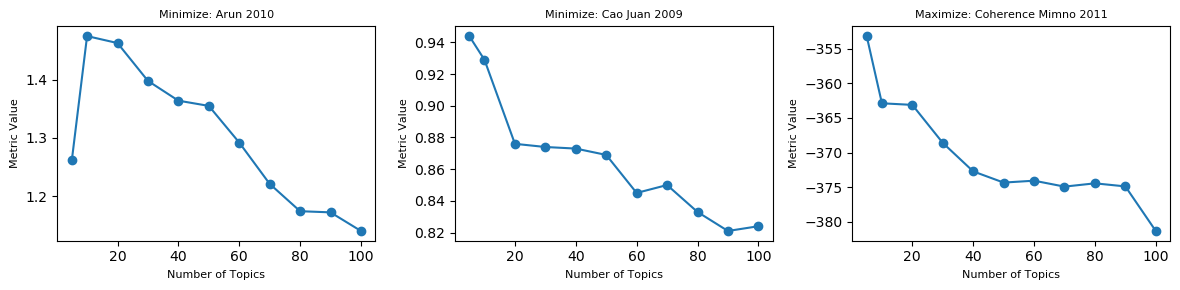

running the evaluation for: eta_001__alpha_0.1
constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
number of trials: 11
variable parameter trials: [{'n_topics': 5, 'alpha': 2.0}, {'n_topics': 10, 'alpha': 1.0}, {'n_topics': 20, 'alpha': 0.5}, {'n_topics': 30, 'alpha': 0.33333}, {'n_topics': 40, 'alpha': 0.25}, {'n_topics': 50, 'alpha': 0.2}, {'n_topics': 60, 'alpha': 0.16667}, {'n_topics': 70, 'alpha': 0.14286}, {'n_topics': 80, 'alpha': 0.125}, {'n_topics': 90, 'alpha': 0.11111}, {'n_topics': 100, 'alpha': 0.1}]
number of results calculated: 11
results by n topic models: [(5, {'arun_2010': 0.042, 'cao_juan_2009': 0.192, 'coherence_mimno_2011': -463.579}), (10, {'arun_2010': 0.081, 'cao_juan_2009': 0.17, 'coherence_mimno_2011': -500.537}), (20, {'arun_2010': 0.136, 'cao_juan_2009': 0.145, 'coherence_mimno_2011': -508.887}), (30, {'arun_2010': 0.161, 'cao_juan_2009': 0.131, 'coherence_mimno_2011

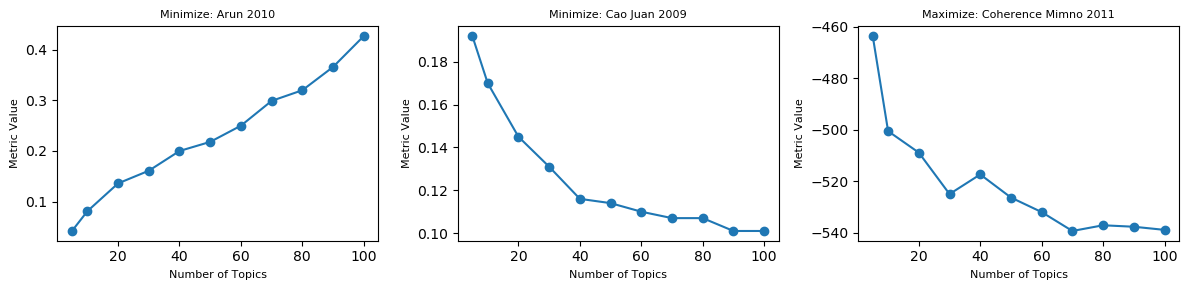

running the evaluation for: eta_001__alpha_001
constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
number of trials: 11
variable parameter trials: [{'n_topics': 5, 'alpha': 0.2}, {'n_topics': 10, 'alpha': 0.1}, {'n_topics': 20, 'alpha': 0.05}, {'n_topics': 30, 'alpha': 0.03333}, {'n_topics': 40, 'alpha': 0.025}, {'n_topics': 50, 'alpha': 0.02}, {'n_topics': 60, 'alpha': 0.01667}, {'n_topics': 70, 'alpha': 0.01429}, {'n_topics': 80, 'alpha': 0.0125}, {'n_topics': 90, 'alpha': 0.01111}, {'n_topics': 100, 'alpha': 0.01}]
number of results calculated: 11
results by n topic models: [(5, {'arun_2010': 0.081, 'cao_juan_2009': 0.503, 'coherence_mimno_2011': -394.849}), (10, {'arun_2010': 0.141, 'cao_juan_2009': 0.443, 'coherence_mimno_2011': -417.351}), (20, {'arun_2010': 0.187, 'cao_juan_2009': 0.401, 'coherence_mimno_2011': -412.594}), (30, {'arun_2010': 0.297, 'cao_juan_2009': 0.373, 'coherence_mimn

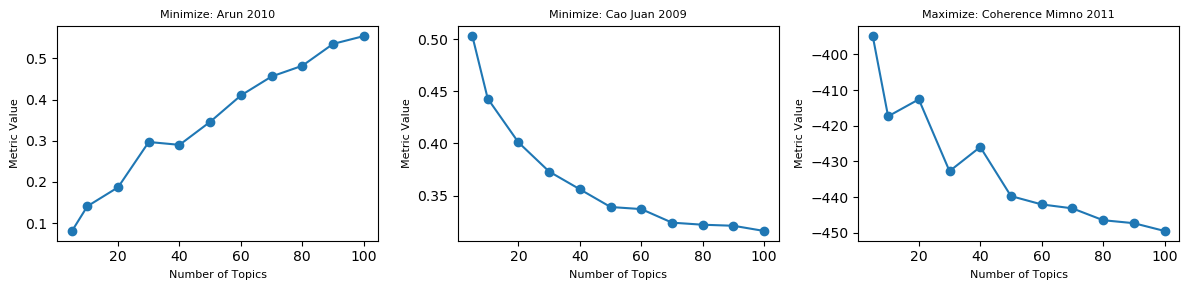

running the evaluation for: eta_001__alpha_010
constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
number of trials: 11
variable parameter trials: [{'n_topics': 5, 'alpha': 0.02}, {'n_topics': 10, 'alpha': 0.01}, {'n_topics': 20, 'alpha': 0.005}, {'n_topics': 30, 'alpha': 0.00333}, {'n_topics': 40, 'alpha': 0.0025}, {'n_topics': 50, 'alpha': 0.002}, {'n_topics': 60, 'alpha': 0.00167}, {'n_topics': 70, 'alpha': 0.00143}, {'n_topics': 80, 'alpha': 0.00125}, {'n_topics': 90, 'alpha': 0.00111}, {'n_topics': 100, 'alpha': 0.001}]
number of results calculated: 11
results by n topic models: [(5, {'arun_2010': 0.174, 'cao_juan_2009': 0.627, 'coherence_mimno_2011': -377.303}), (10, {'arun_2010': 0.446, 'cao_juan_2009': 0.634, 'coherence_mimno_2011': -397.413}), (20, {'arun_2010': 0.535, 'cao_juan_2009': 0.622, 'coherence_mimno_2011': -393.12}), (30, {'arun_2010': 0.693, 'cao_juan_2009': 0.6, 'coherence_

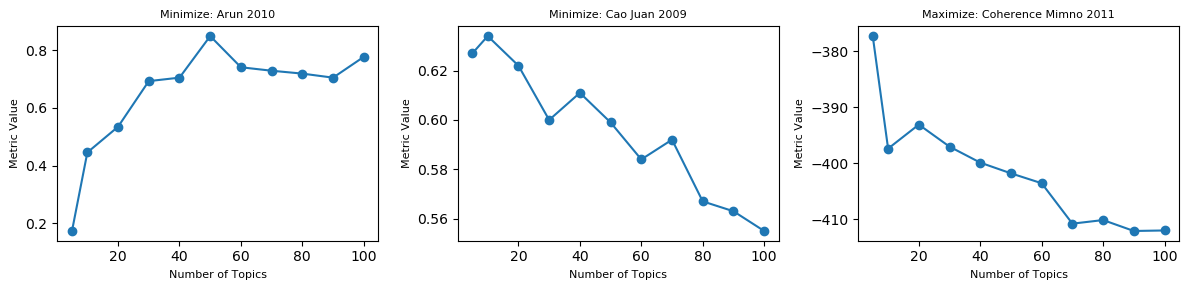

running the evaluation for: eta_001__alpha_100
constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
number of trials: 11
variable parameter trials: [{'n_topics': 5, 'alpha': 0.002}, {'n_topics': 10, 'alpha': 0.001}, {'n_topics': 20, 'alpha': 0.0005}, {'n_topics': 30, 'alpha': 0.00033}, {'n_topics': 40, 'alpha': 0.00025}, {'n_topics': 50, 'alpha': 0.0002}, {'n_topics': 60, 'alpha': 0.00017}, {'n_topics': 70, 'alpha': 0.00014}, {'n_topics': 80, 'alpha': 0.00013}, {'n_topics': 90, 'alpha': 0.00011}, {'n_topics': 100, 'alpha': 0.0001}]
number of results calculated: 11
results by n topic models: [(5, {'arun_2010': 1.181, 'cao_juan_2009': 0.925, 'coherence_mimno_2011': -350.632}), (10, {'arun_2010': 1.447, 'cao_juan_2009': 0.928, 'coherence_mimno_2011': -361.611}), (20, {'arun_2010': 1.453, 'cao_juan_2009': 0.87, 'coherence_mimno_2011': -363.742}), (30, {'arun_2010': 1.324, 'cao_juan_2009': 0.863, 'co

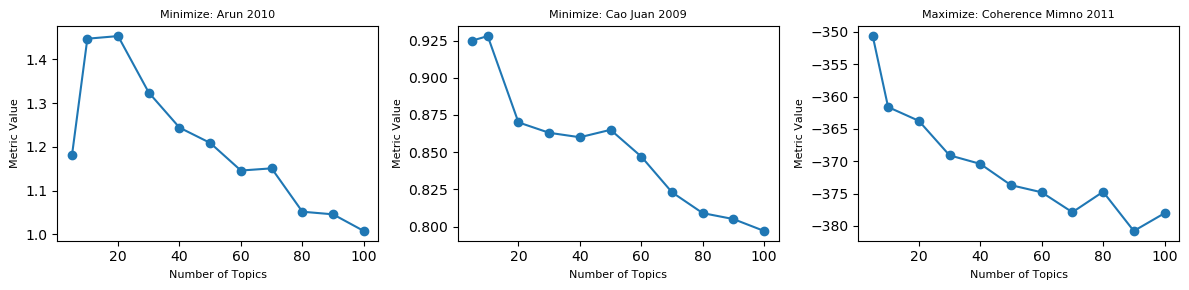

running the evaluation for: eta_010__alpha_0.1
constant parameters: {'n_iter': 500, 'eta': 0.01, 'random_state': 20191122}
number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
number of trials: 11
variable parameter trials: [{'n_topics': 5, 'alpha': 2.0}, {'n_topics': 10, 'alpha': 1.0}, {'n_topics': 20, 'alpha': 0.5}, {'n_topics': 30, 'alpha': 0.33333}, {'n_topics': 40, 'alpha': 0.25}, {'n_topics': 50, 'alpha': 0.2}, {'n_topics': 60, 'alpha': 0.16667}, {'n_topics': 70, 'alpha': 0.14286}, {'n_topics': 80, 'alpha': 0.125}, {'n_topics': 90, 'alpha': 0.11111}, {'n_topics': 100, 'alpha': 0.1}]
number of results calculated: 11
results by n topic models: [(5, {'arun_2010': 0.043, 'cao_juan_2009': 0.194, 'coherence_mimno_2011': -463.748}), (10, {'arun_2010': 0.108, 'cao_juan_2009': 0.162, 'coherence_mimno_2011': -492.367}), (20, {'arun_2010': 0.148, 'cao_juan_2009': 0.132, 'coherence_mimno_2011': -531.171}), (30, {'arun_2010': 0.18, 'cao_juan_2009': 0.112, 'coherence_mimno_201

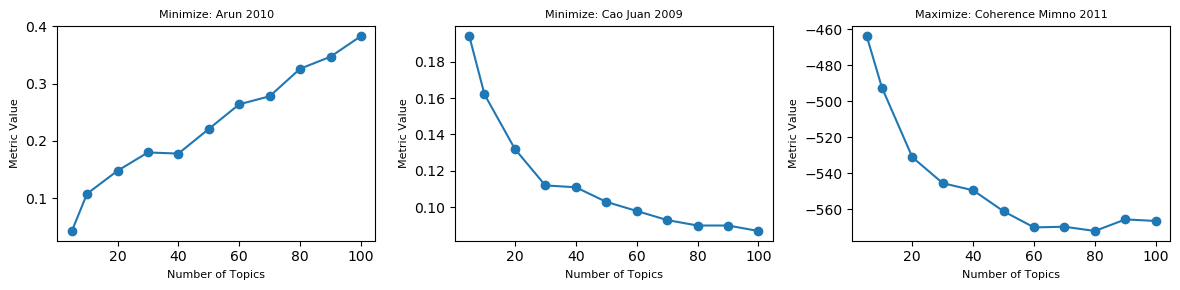

running the evaluation for: eta_010__alpha_001
constant parameters: {'n_iter': 500, 'eta': 0.01, 'random_state': 20191122}
number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
number of trials: 11
variable parameter trials: [{'n_topics': 5, 'alpha': 0.2}, {'n_topics': 10, 'alpha': 0.1}, {'n_topics': 20, 'alpha': 0.05}, {'n_topics': 30, 'alpha': 0.03333}, {'n_topics': 40, 'alpha': 0.025}, {'n_topics': 50, 'alpha': 0.02}, {'n_topics': 60, 'alpha': 0.01667}, {'n_topics': 70, 'alpha': 0.01429}, {'n_topics': 80, 'alpha': 0.0125}, {'n_topics': 90, 'alpha': 0.01111}, {'n_topics': 100, 'alpha': 0.01}]
number of results calculated: 11
results by n topic models: [(5, {'arun_2010': 0.083, 'cao_juan_2009': 0.514, 'coherence_mimno_2011': -394.857}), (10, {'arun_2010': 0.137, 'cao_juan_2009': 0.44, 'coherence_mimno_2011': -414.633}), (20, {'arun_2010': 0.19, 'cao_juan_2009': 0.393, 'coherence_mimno_2011': -425.907}), (30, {'arun_2010': 0.224, 'cao_juan_2009': 0.357, 'coherence_mimno

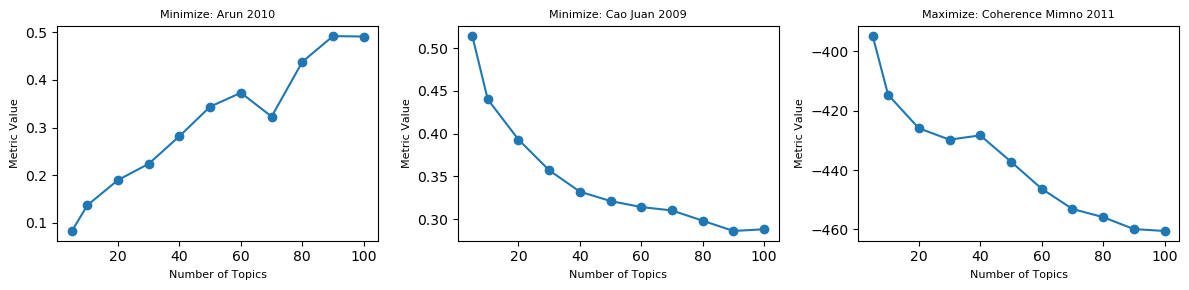

running the evaluation for: eta_010__alpha_010
constant parameters: {'n_iter': 500, 'eta': 0.01, 'random_state': 20191122}
number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
number of trials: 11
variable parameter trials: [{'n_topics': 5, 'alpha': 0.02}, {'n_topics': 10, 'alpha': 0.01}, {'n_topics': 20, 'alpha': 0.005}, {'n_topics': 30, 'alpha': 0.00333}, {'n_topics': 40, 'alpha': 0.0025}, {'n_topics': 50, 'alpha': 0.002}, {'n_topics': 60, 'alpha': 0.00167}, {'n_topics': 70, 'alpha': 0.00143}, {'n_topics': 80, 'alpha': 0.00125}, {'n_topics': 90, 'alpha': 0.00111}, {'n_topics': 100, 'alpha': 0.001}]
number of results calculated: 11
results by n topic models: [(5, {'arun_2010': 0.183, 'cao_juan_2009': 0.629, 'coherence_mimno_2011': -372.692}), (10, {'arun_2010': 0.443, 'cao_juan_2009': 0.651, 'coherence_mimno_2011': -392.387}), (20, {'arun_2010': 0.489, 'cao_juan_2009': 0.605, 'coherence_mimno_2011': -400.113}), (30, {'arun_2010': 0.668, 'cao_juan_2009': 0.605, 'cohere

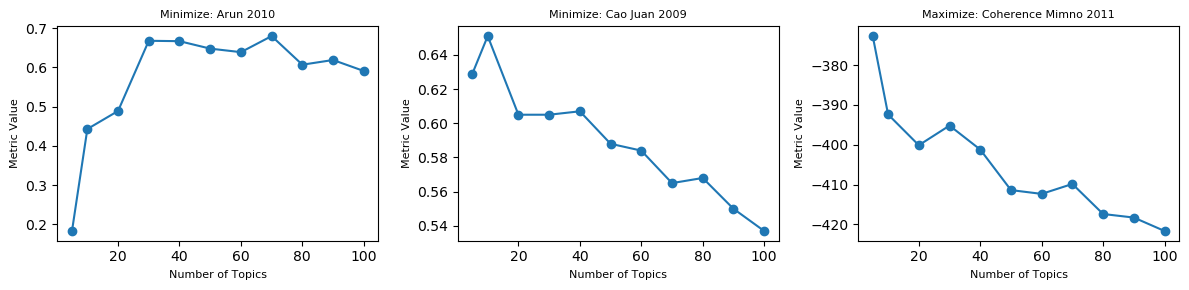

running the evaluation for: eta_010__alpha_100
constant parameters: {'n_iter': 500, 'eta': 0.01, 'random_state': 20191122}
number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
number of trials: 11
variable parameter trials: [{'n_topics': 5, 'alpha': 0.002}, {'n_topics': 10, 'alpha': 0.001}, {'n_topics': 20, 'alpha': 0.0005}, {'n_topics': 30, 'alpha': 0.00033}, {'n_topics': 40, 'alpha': 0.00025}, {'n_topics': 50, 'alpha': 0.0002}, {'n_topics': 60, 'alpha': 0.00017}, {'n_topics': 70, 'alpha': 0.00014}, {'n_topics': 80, 'alpha': 0.00013}, {'n_topics': 90, 'alpha': 0.00011}, {'n_topics': 100, 'alpha': 0.0001}]
number of results calculated: 11
results by n topic models: [(5, {'arun_2010': 1.24, 'cao_juan_2009': 0.94, 'coherence_mimno_2011': -354.048}), (10, {'arun_2010': 1.478, 'cao_juan_2009': 0.931, 'coherence_mimno_2011': -359.951}), (20, {'arun_2010': 1.404, 'cao_juan_2009': 0.879, 'coherence_mimno_2011': -361.868}), (30, {'arun_2010': 1.314, 'cao_juan_2009': 0.874, 'co

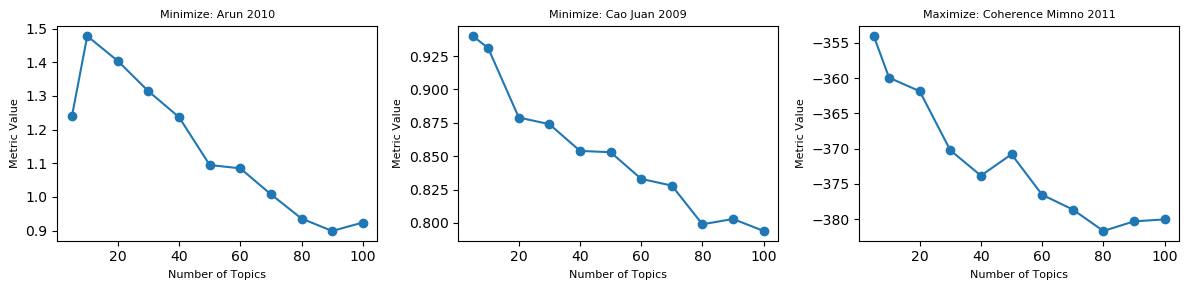

running the evaluation for: eta_100__alpha_0.1
constant parameters: {'n_iter': 500, 'eta': 0.001, 'random_state': 20191122}
number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
number of trials: 11
variable parameter trials: [{'n_topics': 5, 'alpha': 2.0}, {'n_topics': 10, 'alpha': 1.0}, {'n_topics': 20, 'alpha': 0.5}, {'n_topics': 30, 'alpha': 0.33333}, {'n_topics': 40, 'alpha': 0.25}, {'n_topics': 50, 'alpha': 0.2}, {'n_topics': 60, 'alpha': 0.16667}, {'n_topics': 70, 'alpha': 0.14286}, {'n_topics': 80, 'alpha': 0.125}, {'n_topics': 90, 'alpha': 0.11111}, {'n_topics': 100, 'alpha': 0.1}]
number of results calculated: 11
results by n topic models: [(5, {'arun_2010': 0.058, 'cao_juan_2009': 0.207, 'coherence_mimno_2011': -463.226}), (10, {'arun_2010': 0.118, 'cao_juan_2009': 0.177, 'coherence_mimno_2011': -516.771}), (20, {'arun_2010': 0.14, 'cao_juan_2009': 0.132, 'coherence_mimno_2011': -533.786}), (30, {'arun_2010': 0.157, 'cao_juan_2009': 0.116, 'coherence_mimno_20

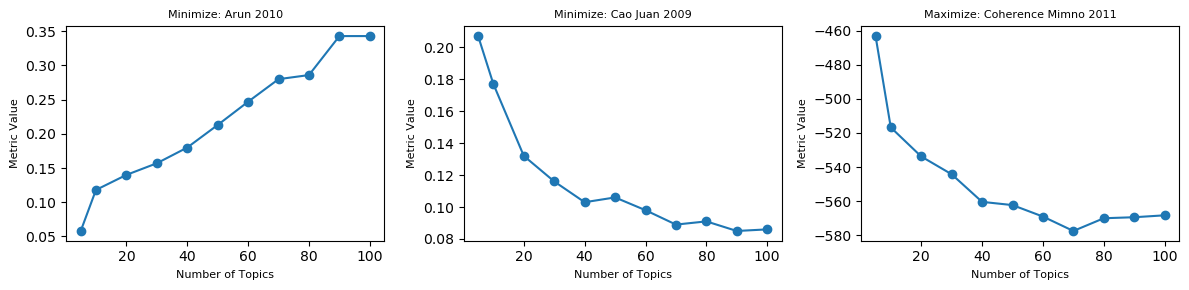

running the evaluation for: eta_100__alpha_001
constant parameters: {'n_iter': 500, 'eta': 0.001, 'random_state': 20191122}
number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
number of trials: 11
variable parameter trials: [{'n_topics': 5, 'alpha': 0.2}, {'n_topics': 10, 'alpha': 0.1}, {'n_topics': 20, 'alpha': 0.05}, {'n_topics': 30, 'alpha': 0.03333}, {'n_topics': 40, 'alpha': 0.025}, {'n_topics': 50, 'alpha': 0.02}, {'n_topics': 60, 'alpha': 0.01667}, {'n_topics': 70, 'alpha': 0.01429}, {'n_topics': 80, 'alpha': 0.0125}, {'n_topics': 90, 'alpha': 0.01111}, {'n_topics': 100, 'alpha': 0.01}]
number of results calculated: 11
results by n topic models: [(5, {'arun_2010': 0.1, 'cao_juan_2009': 0.502, 'coherence_mimno_2011': -400.986}), (10, {'arun_2010': 0.13, 'cao_juan_2009': 0.433, 'coherence_mimno_2011': -417.931}), (20, {'arun_2010': 0.158, 'cao_juan_2009': 0.381, 'coherence_mimno_2011': -424.161}), (30, {'arun_2010': 0.21, 'cao_juan_2009': 0.333, 'coherence_mimno_

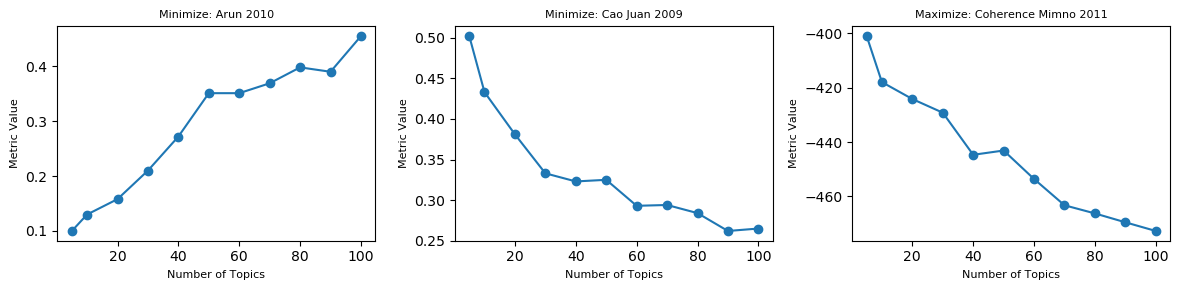

running the evaluation for: eta_100__alpha_010
constant parameters: {'n_iter': 500, 'eta': 0.001, 'random_state': 20191122}
number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
number of trials: 11
variable parameter trials: [{'n_topics': 5, 'alpha': 0.02}, {'n_topics': 10, 'alpha': 0.01}, {'n_topics': 20, 'alpha': 0.005}, {'n_topics': 30, 'alpha': 0.00333}, {'n_topics': 40, 'alpha': 0.0025}, {'n_topics': 50, 'alpha': 0.002}, {'n_topics': 60, 'alpha': 0.00167}, {'n_topics': 70, 'alpha': 0.00143}, {'n_topics': 80, 'alpha': 0.00125}, {'n_topics': 90, 'alpha': 0.00111}, {'n_topics': 100, 'alpha': 0.001}]
number of results calculated: 11
results by n topic models: [(5, {'arun_2010': 0.179, 'cao_juan_2009': 0.627, 'coherence_mimno_2011': -371.041}), (10, {'arun_2010': 0.442, 'cao_juan_2009': 0.654, 'coherence_mimno_2011': -388.233}), (20, {'arun_2010': 0.451, 'cao_juan_2009': 0.616, 'coherence_mimno_2011': -403.559}), (30, {'arun_2010': 0.655, 'cao_juan_2009': 0.614, 'coher

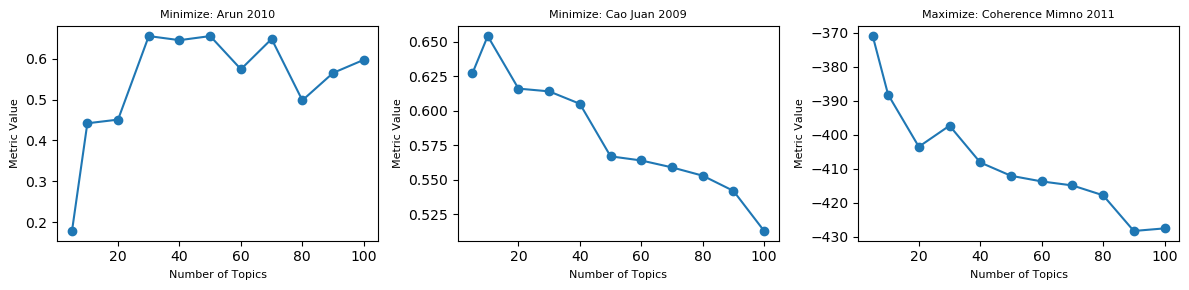

running the evaluation for: eta_100__alpha_100
constant parameters: {'n_iter': 500, 'eta': 0.001, 'random_state': 20191122}
number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
number of trials: 11
variable parameter trials: [{'n_topics': 5, 'alpha': 0.002}, {'n_topics': 10, 'alpha': 0.001}, {'n_topics': 20, 'alpha': 0.0005}, {'n_topics': 30, 'alpha': 0.00033}, {'n_topics': 40, 'alpha': 0.00025}, {'n_topics': 50, 'alpha': 0.0002}, {'n_topics': 60, 'alpha': 0.00017}, {'n_topics': 70, 'alpha': 0.00014}, {'n_topics': 80, 'alpha': 0.00013}, {'n_topics': 90, 'alpha': 0.00011}, {'n_topics': 100, 'alpha': 0.0001}]
number of results calculated: 11
results by n topic models: [(5, {'arun_2010': 1.224, 'cao_juan_2009': 0.934, 'coherence_mimno_2011': -353.695}), (10, {'arun_2010': 1.476, 'cao_juan_2009': 0.927, 'coherence_mimno_2011': -360.727}), (20, {'arun_2010': 1.386, 'cao_juan_2009': 0.88, 'coherence_mimno_2011': -364.285}), (30, {'arun_2010': 1.289, 'cao_juan_2009': 0.871, '

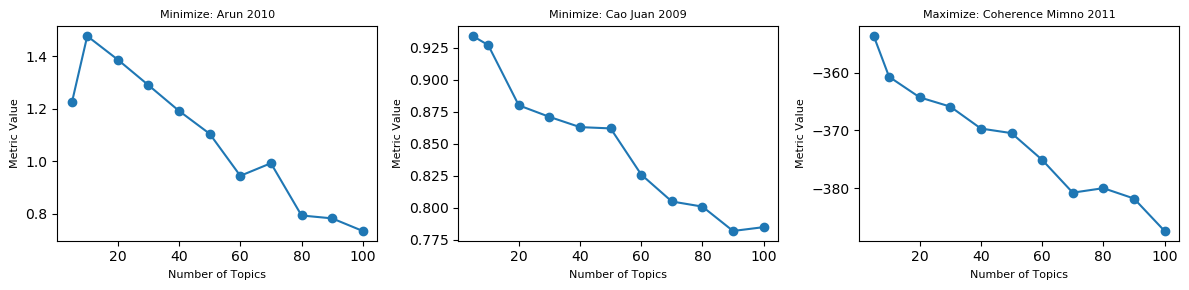

evaluation data captured for 16 sets of parameters.


In [ ]:
eta_factor_list = [.1, 1,10,100]
alpha_factor_list = [.1,1,10,100]
all_model_runs = {}

for e in eta_factor_list:
  for a in alpha_factor_list:
    run_code = 'eta_' + str(e).zfill(3) + '__' + 'alpha_' + str(a).zfill(3)
    print('running the evaluation for:', run_code)
    varying_params, const_params = build_param_inputs(kmax = 100, eta_factor = e, alpha_factor = a)
    results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_main, varying_p = varying_params, const_p = const_params)
    all_model_runs[run_code] = results_by_n_topics
    plot_eval_results_custom(results_by_n_topics)
#print summary of run
print('evaluation data captured for', len(all_model_runs), 'sets of parameters.')
#save the files to disk
eval_file_path = '%s/explore_eval_ae.p' % DATA_DIR
pickle.dump(all_model_runs, open(eval_file_path, 'wb') )

In [ ]:
#location of corpus files
eval_file_path = '%s/explore_eval_ae.p' % DATA_DIR
#load the corpus
all_model_runs = pickle.load(open(eval_file_path, 'rb'))
#preview the document labels
print(all_model_runs['eta_001__alpha_001'])

[(5, {'arun_2010': 0.081, 'cao_juan_2009': 0.503, 'coherence_mimno_2011': -394.849}), (10, {'arun_2010': 0.141, 'cao_juan_2009': 0.443, 'coherence_mimno_2011': -417.351}), (20, {'arun_2010': 0.187, 'cao_juan_2009': 0.401, 'coherence_mimno_2011': -412.594}), (30, {'arun_2010': 0.297, 'cao_juan_2009': 0.373, 'coherence_mimno_2011': -432.726}), (40, {'arun_2010': 0.29, 'cao_juan_2009': 0.356, 'coherence_mimno_2011': -425.949}), (50, {'arun_2010': 0.346, 'cao_juan_2009': 0.339, 'coherence_mimno_2011': -439.717}), (60, {'arun_2010': 0.41, 'cao_juan_2009': 0.337, 'coherence_mimno_2011': -442.054}), (70, {'arun_2010': 0.456, 'cao_juan_2009': 0.324, 'coherence_mimno_2011': -443.159}), (80, {'arun_2010': 0.482, 'cao_juan_2009': 0.322, 'coherence_mimno_2011': -446.482}), (90, {'arun_2010': 0.535, 'cao_juan_2009': 0.321, 'coherence_mimno_2011': -447.315}), (100, {'arun_2010': 0.554, 'cao_juan_2009': 0.316, 'coherence_mimno_2011': -449.502})]


In [ ]:
all_model_runs.keys()

dict_keys(['eta_0.1__alpha_0.1', 'eta_0.1__alpha_001', 'eta_0.1__alpha_010', 'eta_0.1__alpha_100', 'eta_001__alpha_0.1', 'eta_001__alpha_001', 'eta_001__alpha_010', 'eta_001__alpha_100', 'eta_010__alpha_0.1', 'eta_010__alpha_001', 'eta_010__alpha_010', 'eta_010__alpha_100', 'eta_100__alpha_0.1', 'eta_100__alpha_001', 'eta_100__alpha_010', 'eta_100__alpha_100'])

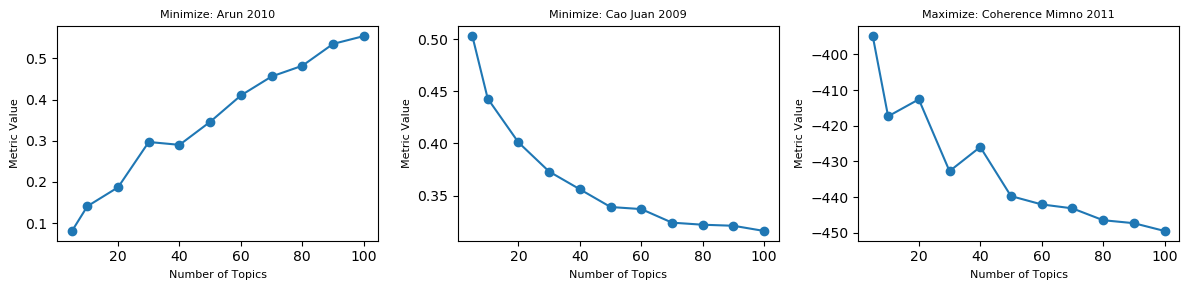

In [ ]:
plot_eval_results_custom(all_model_runs['eta_001__alpha_001'])

## Round 2: Evaluate Model Options

[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[.] number of trials: 11
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 1}, {'n_topics': 10, 'alpha': 1}, {'n_topics': 20, 'alpha': 1}, {'n_topics': 30, 'alpha': 1}, {'n_topics': 40, 'alpha': 1}, {'n_topics': 50, 'alpha': 1}, {'n_topics': 60, 'alpha': 1}, {'n_topics': 70, 'alpha': 1}, {'n_topics': 80, 'alpha': 1}, {'n_topics': 90, 'alpha': 1}, {'n_topics': 100, 'alpha': 1}]
[.] number of results calculated: 11
[.] results by n topic models: [(5, {'arun_2010': 0.055, 'cao_juan_2009': 0.278, 'coherence_mimno_2011': -427.874}), (10, {'arun_2010': 0.081, 'cao_juan_2009': 0.17, 'coherence_mimno_2011': -500.537}), (20, {'arun_2010': 0.181, 'cao_juan_2009': 0.076, 'coherence_mimno_2011': -546.972}), (30, {'arun_2010': 0.211, 'cao_juan_2009': 0.059, 'coherence_mimno_2011': -572.475}), (40, {'arun_2010': 0.279, 'cao_juan_2009': 0.042,

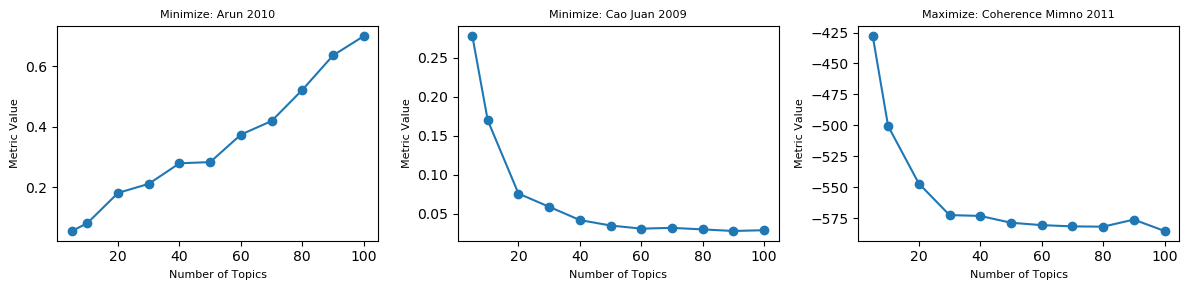

In [ ]:
# run calculations and vizualize
varying_params, const_params = build_param_inputs_fixed(kmax = 100, eta_value = .1, alpha_value = 1)
results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_main, varying_p = varying_params, const_p = const_params)
plot_eval_results_custom(results_by_n_topics)

In [227]:
def automate_test_fixed_model(dtm_p, eta_list, alpha_list, kmax, output_file):
  #establish tracking metrics
  total_runs = len(eta_list) * len(alpha_list)
  all_model_runs = {}
  start_time = time.time()
  count = 0
  #iterate through all inputs for eta and alpha

  for e in eta_list:
    for a in alpha_list:
      run_code = 'eta_' + str(e).zfill(4) + '__' + 'alpha_' + str(a).zfill(4)
      print('running the evaluation for:', run_code)
      #build the variable params
      varying_params, const_params = build_param_inputs_fixed(kmax = kmax, eta_value = e, alpha_value = a)
      #build the results
      results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_p, varying_p = varying_params, const_p = const_params)
      #record the results
      all_model_runs[run_code] = results_by_n_topics
      #update on the progress and runtime
      count += 1
      current_progress = int(round(count/total_runs,2)*100)
      current_runtime = round(time.time() - start_time,3)
      print('[-] current progress:', current_progress, '%', 'and a runtime of', current_runtime, 'seconds.')
      #plot the results
      plot_eval_results_custom(results_by_n_topics)
  #print summary of the entire run
  print('evaluation data captured for', len(all_model_runs), 'sets of parameters.')
  #save the files to disk
  eval_file_path = '%s/%s' % (DATA_DIR, output_file)
  pickle.dump(all_model_runs, open(eval_file_path, 'wb'))
  #return the results
  return all_model_runs

running the evaluation for: eta_00.1__alpha_00.1
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.1}, {'n_topics': 10, 'alpha': 0.1}, {'n_topics': 20, 'alpha': 0.1}, {'n_topics': 30, 'alpha': 0.1}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.1}, {'n_topics': 60, 'alpha': 0.1}, {'n_topics': 70, 'alpha': 0.1}, {'n_topics': 80, 'alpha': 0.1}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.103, 'cao_juan_2009': 0.552, 'coherence_mimno_2011': -392.966}), (10, {'arun_2010': 0.141, 'cao_juan_2009': 0.443, 'coherence_mimno_2011': -417.351}), (20, {'arun_2010': 0.171, 'cao_juan_2009': 0.33, 'coherence_mimno_2011': -431.598}), (30, {'arun_2010': 0.168, 'cao_juan_2009': 0.253, 'coherence_mimno_2011': -461.455}), (40, {'arun_2010': 0.177, 'cao_juan_2009': 0.202, 'coh

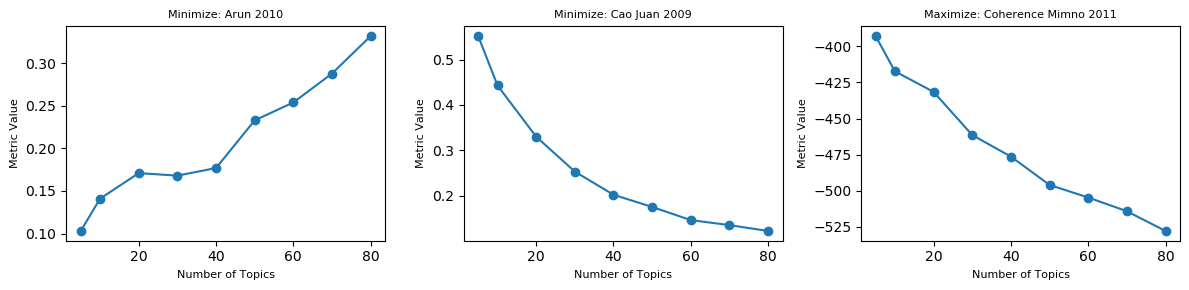

running the evaluation for: eta_00.1__alpha_00.2
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.2}, {'n_topics': 10, 'alpha': 0.2}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.2}, {'n_topics': 40, 'alpha': 0.2}, {'n_topics': 50, 'alpha': 0.2}, {'n_topics': 60, 'alpha': 0.2}, {'n_topics': 70, 'alpha': 0.2}, {'n_topics': 80, 'alpha': 0.2}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.081, 'cao_juan_2009': 0.503, 'coherence_mimno_2011': -394.849}), (10, {'arun_2010': 0.14, 'cao_juan_2009': 0.376, 'coherence_mimno_2011': -436.9}), (20, {'arun_2010': 0.134, 'cao_juan_2009': 0.234, 'coherence_mimno_2011': -460.508}), (30, {'arun_2010': 0.141, 'cao_juan_2009': 0.182, 'coherence_mimno_2011': -481.558}), (40, {'arun_2010': 0.192, 'cao_juan_2009': 0.137, 'coher

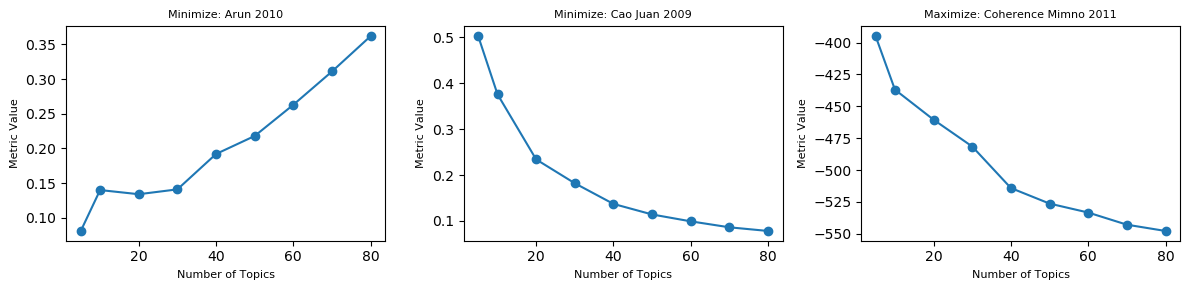

running the evaluation for: eta_00.1__alpha_00.3
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.3}, {'n_topics': 10, 'alpha': 0.3}, {'n_topics': 20, 'alpha': 0.3}, {'n_topics': 30, 'alpha': 0.3}, {'n_topics': 40, 'alpha': 0.3}, {'n_topics': 50, 'alpha': 0.3}, {'n_topics': 60, 'alpha': 0.3}, {'n_topics': 70, 'alpha': 0.3}, {'n_topics': 80, 'alpha': 0.3}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.088, 'cao_juan_2009': 0.479, 'coherence_mimno_2011': -403.832}), (10, {'arun_2010': 0.102, 'cao_juan_2009': 0.312, 'coherence_mimno_2011': -444.384}), (20, {'arun_2010': 0.136, 'cao_juan_2009': 0.207, 'coherence_mimno_2011': -477.808}), (30, {'arun_2010': 0.164, 'cao_juan_2009': 0.137, 'coherence_mimno_2011': -518.873}), (40, {'arun_2010': 0.2, 'cao_juan_2009': 0.105, 'cohe

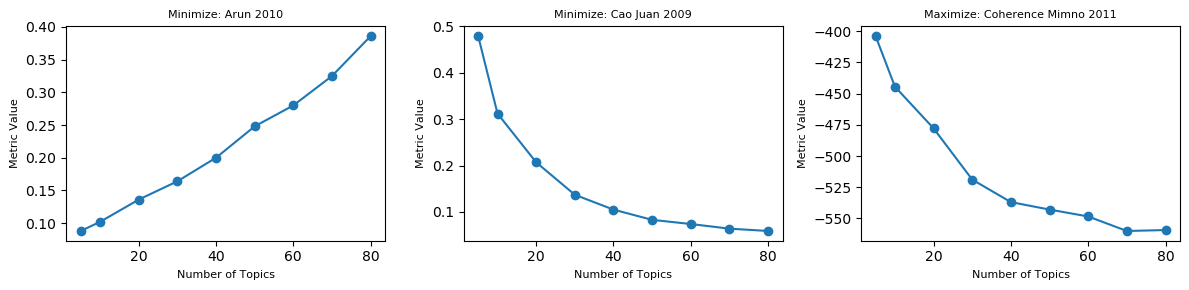

running the evaluation for: eta_00.1__alpha_00.4
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.4}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 20, 'alpha': 0.4}, {'n_topics': 30, 'alpha': 0.4}, {'n_topics': 40, 'alpha': 0.4}, {'n_topics': 50, 'alpha': 0.4}, {'n_topics': 60, 'alpha': 0.4}, {'n_topics': 70, 'alpha': 0.4}, {'n_topics': 80, 'alpha': 0.4}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.086, 'cao_juan_2009': 0.456, 'coherence_mimno_2011': -405.457}), (10, {'arun_2010': 0.099, 'cao_juan_2009': 0.278, 'coherence_mimno_2011': -453.925}), (20, {'arun_2010': 0.135, 'cao_juan_2009': 0.166, 'coherence_mimno_2011': -502.068}), (30, {'arun_2010': 0.166, 'cao_juan_2009': 0.115, 'coherence_mimno_2011': -525.37}), (40, {'arun_2010': 0.204, 'cao_juan_2009': 0.088, 'coh

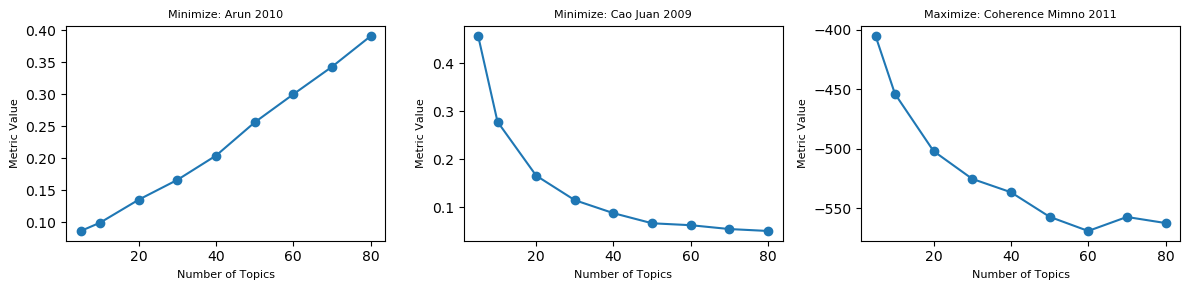

running the evaluation for: eta_00.1__alpha_00.5
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.5}, {'n_topics': 10, 'alpha': 0.5}, {'n_topics': 20, 'alpha': 0.5}, {'n_topics': 30, 'alpha': 0.5}, {'n_topics': 40, 'alpha': 0.5}, {'n_topics': 50, 'alpha': 0.5}, {'n_topics': 60, 'alpha': 0.5}, {'n_topics': 70, 'alpha': 0.5}, {'n_topics': 80, 'alpha': 0.5}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.079, 'cao_juan_2009': 0.425, 'coherence_mimno_2011': -403.203}), (10, {'arun_2010': 0.082, 'cao_juan_2009': 0.249, 'coherence_mimno_2011': -471.829}), (20, {'arun_2010': 0.136, 'cao_juan_2009': 0.145, 'coherence_mimno_2011': -508.887}), (30, {'arun_2010': 0.158, 'cao_juan_2009': 0.095, 'coherence_mimno_2011': -530.792}), (40, {'arun_2010': 0.195, 'cao_juan_2009': 0.076, 'co

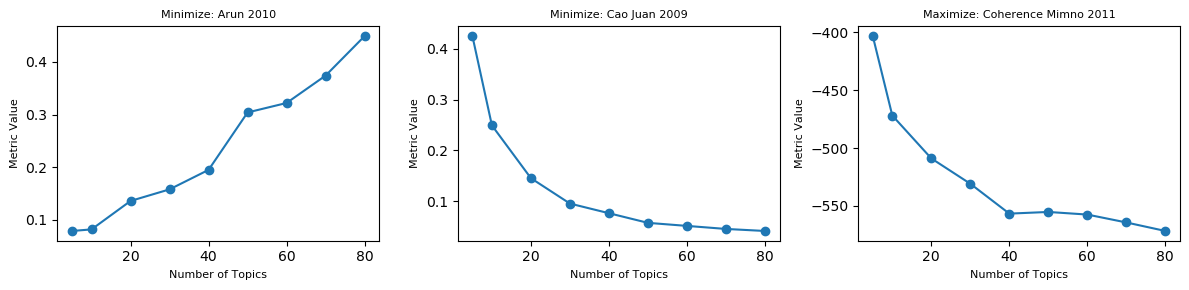

running the evaluation for: eta_00.1__alpha_00.6
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.6}, {'n_topics': 10, 'alpha': 0.6}, {'n_topics': 20, 'alpha': 0.6}, {'n_topics': 30, 'alpha': 0.6}, {'n_topics': 40, 'alpha': 0.6}, {'n_topics': 50, 'alpha': 0.6}, {'n_topics': 60, 'alpha': 0.6}, {'n_topics': 70, 'alpha': 0.6}, {'n_topics': 80, 'alpha': 0.6}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.085, 'cao_juan_2009': 0.386, 'coherence_mimno_2011': -431.878}), (10, {'arun_2010': 0.105, 'cao_juan_2009': 0.244, 'coherence_mimno_2011': -469.022}), (20, {'arun_2010': 0.143, 'cao_juan_2009': 0.136, 'coherence_mimno_2011': -516.405}), (30, {'arun_2010': 0.168, 'cao_juan_2009': 0.085, 'coherence_mimno_2011': -534.712}), (40, {'arun_2010': 0.243, 'cao_juan_2009': 0.059, 'co

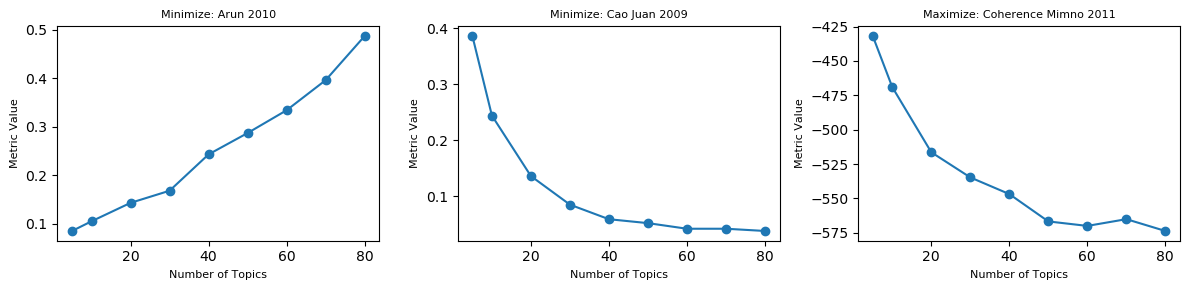

running the evaluation for: eta_00.1__alpha_00.7
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.7}, {'n_topics': 10, 'alpha': 0.7}, {'n_topics': 20, 'alpha': 0.7}, {'n_topics': 30, 'alpha': 0.7}, {'n_topics': 40, 'alpha': 0.7}, {'n_topics': 50, 'alpha': 0.7}, {'n_topics': 60, 'alpha': 0.7}, {'n_topics': 70, 'alpha': 0.7}, {'n_topics': 80, 'alpha': 0.7}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.083, 'cao_juan_2009': 0.364, 'coherence_mimno_2011': -433.663}), (10, {'arun_2010': 0.09, 'cao_juan_2009': 0.224, 'coherence_mimno_2011': -478.522}), (20, {'arun_2010': 0.155, 'cao_juan_2009': 0.114, 'coherence_mimno_2011': -524.648}), (30, {'arun_2010': 0.203, 'cao_juan_2009': 0.072, 'coherence_mimno_2011': -546.394}), (40, {'arun_2010': 0.227, 'cao_juan_2009': 0.055, 'coh

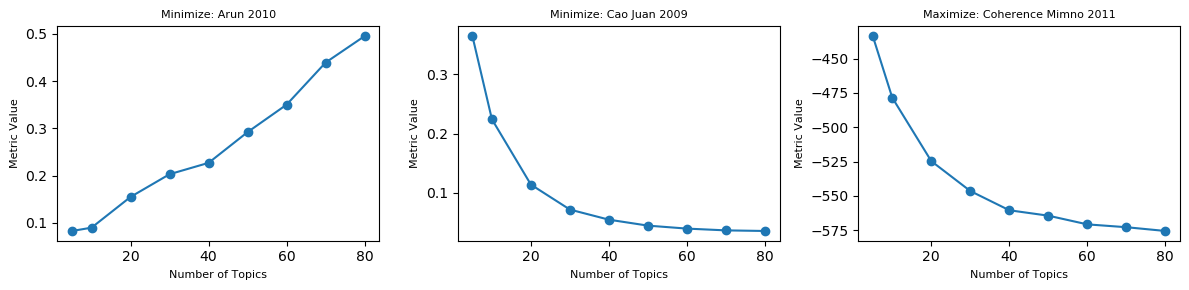

running the evaluation for: eta_00.1__alpha_00.8
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.8}, {'n_topics': 20, 'alpha': 0.8}, {'n_topics': 30, 'alpha': 0.8}, {'n_topics': 40, 'alpha': 0.8}, {'n_topics': 50, 'alpha': 0.8}, {'n_topics': 60, 'alpha': 0.8}, {'n_topics': 70, 'alpha': 0.8}, {'n_topics': 80, 'alpha': 0.8}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.084, 'cao_juan_2009': 0.347, 'coherence_mimno_2011': -424.795}), (10, {'arun_2010': 0.084, 'cao_juan_2009': 0.205, 'coherence_mimno_2011': -477.327}), (20, {'arun_2010': 0.149, 'cao_juan_2009': 0.098, 'coherence_mimno_2011': -537.939}), (30, {'arun_2010': 0.188, 'cao_juan_2009': 0.063, 'coherence_mimno_2011': -559.504}), (40, {'arun_2010': 0.241, 'cao_juan_2009': 0.047, 'co

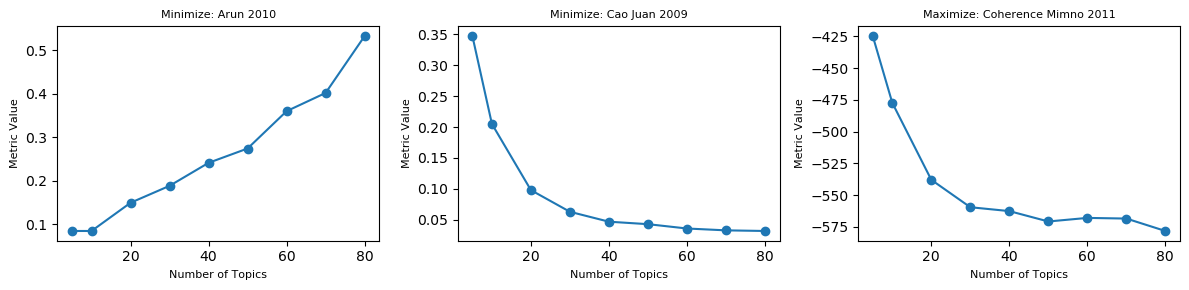

running the evaluation for: eta_00.1__alpha_00.9
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.9}, {'n_topics': 10, 'alpha': 0.9}, {'n_topics': 20, 'alpha': 0.9}, {'n_topics': 30, 'alpha': 0.9}, {'n_topics': 40, 'alpha': 0.9}, {'n_topics': 50, 'alpha': 0.9}, {'n_topics': 60, 'alpha': 0.9}, {'n_topics': 70, 'alpha': 0.9}, {'n_topics': 80, 'alpha': 0.9}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.083, 'cao_juan_2009': 0.344, 'coherence_mimno_2011': -429.114}), (10, {'arun_2010': 0.091, 'cao_juan_2009': 0.186, 'coherence_mimno_2011': -488.659}), (20, {'arun_2010': 0.145, 'cao_juan_2009': 0.091, 'coherence_mimno_2011': -540.495}), (30, {'arun_2010': 0.163, 'cao_juan_2009': 0.063, 'coherence_mimno_2011': -559.044}), (40, {'arun_2010': 0.265, 'cao_juan_2009': 0.042, 'co

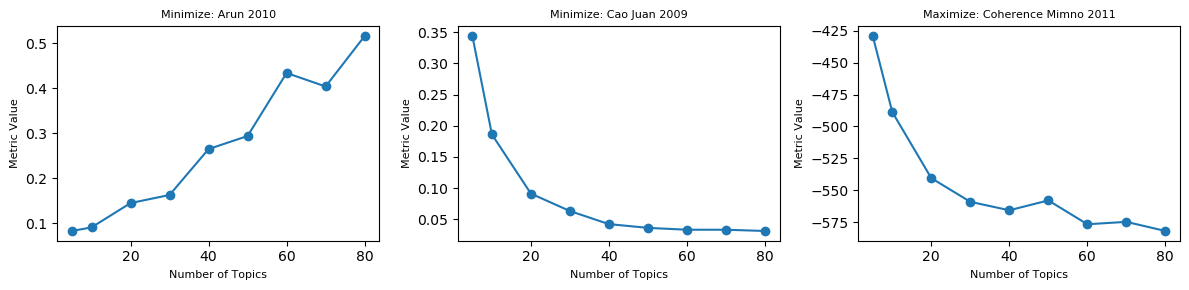

running the evaluation for: eta_00.1__alpha_01.0
[.] constant parameters: {'n_iter': 500, 'eta': 0.1, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 1.0}, {'n_topics': 10, 'alpha': 1.0}, {'n_topics': 20, 'alpha': 1.0}, {'n_topics': 30, 'alpha': 1.0}, {'n_topics': 40, 'alpha': 1.0}, {'n_topics': 50, 'alpha': 1.0}, {'n_topics': 60, 'alpha': 1.0}, {'n_topics': 70, 'alpha': 1.0}, {'n_topics': 80, 'alpha': 1.0}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.055, 'cao_juan_2009': 0.278, 'coherence_mimno_2011': -427.874}), (10, {'arun_2010': 0.081, 'cao_juan_2009': 0.17, 'coherence_mimno_2011': -500.537}), (20, {'arun_2010': 0.181, 'cao_juan_2009': 0.076, 'coherence_mimno_2011': -546.972}), (30, {'arun_2010': 0.211, 'cao_juan_2009': 0.059, 'coherence_mimno_2011': -572.475}), (40, {'arun_2010': 0.279, 'cao_juan_2009': 0.042, 'coh

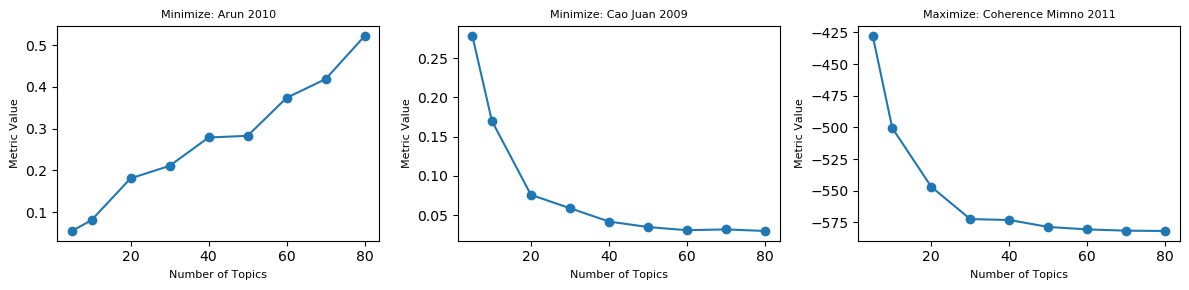

running the evaluation for: eta_0.09__alpha_00.1
[.] constant parameters: {'n_iter': 500, 'eta': 0.09, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.1}, {'n_topics': 10, 'alpha': 0.1}, {'n_topics': 20, 'alpha': 0.1}, {'n_topics': 30, 'alpha': 0.1}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.1}, {'n_topics': 60, 'alpha': 0.1}, {'n_topics': 70, 'alpha': 0.1}, {'n_topics': 80, 'alpha': 0.1}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.093, 'cao_juan_2009': 0.567, 'coherence_mimno_2011': -386.076}), (10, {'arun_2010': 0.125, 'cao_juan_2009': 0.437, 'coherence_mimno_2011': -421.127}), (20, {'arun_2010': 0.155, 'cao_juan_2009': 0.318, 'coherence_mimno_2011': -432.327}), (30, {'arun_2010': 0.175, 'cao_juan_2009': 0.25, 'coherence_mimno_2011': -451.898}), (40, {'arun_2010': 0.186, 'cao_juan_2009': 0.205, 'co

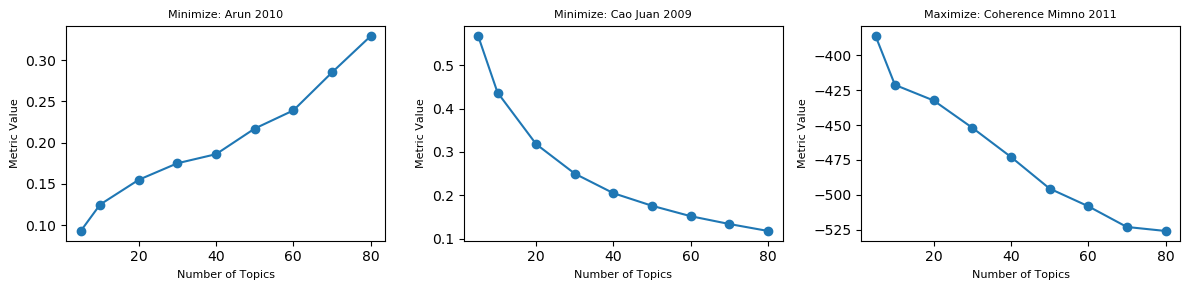

running the evaluation for: eta_0.09__alpha_00.2
[.] constant parameters: {'n_iter': 500, 'eta': 0.09, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.2}, {'n_topics': 10, 'alpha': 0.2}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.2}, {'n_topics': 40, 'alpha': 0.2}, {'n_topics': 50, 'alpha': 0.2}, {'n_topics': 60, 'alpha': 0.2}, {'n_topics': 70, 'alpha': 0.2}, {'n_topics': 80, 'alpha': 0.2}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.089, 'cao_juan_2009': 0.519, 'coherence_mimno_2011': -391.943}), (10, {'arun_2010': 0.101, 'cao_juan_2009': 0.357, 'coherence_mimno_2011': -434.351}), (20, {'arun_2010': 0.14, 'cao_juan_2009': 0.241, 'coherence_mimno_2011': -450.635}), (30, {'arun_2010': 0.167, 'cao_juan_2009': 0.179, 'coherence_mimno_2011': -489.691}), (40, {'arun_2010': 0.2, 'cao_juan_2009': 0.134, 'cohe

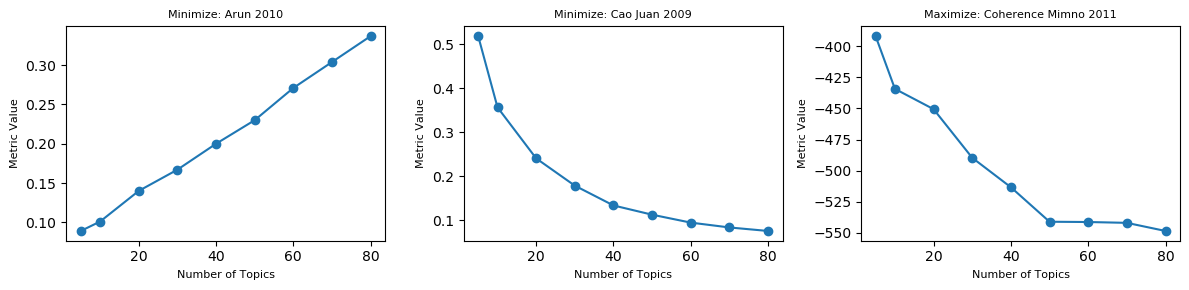

running the evaluation for: eta_0.09__alpha_00.3
[.] constant parameters: {'n_iter': 500, 'eta': 0.09, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.3}, {'n_topics': 10, 'alpha': 0.3}, {'n_topics': 20, 'alpha': 0.3}, {'n_topics': 30, 'alpha': 0.3}, {'n_topics': 40, 'alpha': 0.3}, {'n_topics': 50, 'alpha': 0.3}, {'n_topics': 60, 'alpha': 0.3}, {'n_topics': 70, 'alpha': 0.3}, {'n_topics': 80, 'alpha': 0.3}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.087, 'cao_juan_2009': 0.484, 'coherence_mimno_2011': -411.754}), (10, {'arun_2010': 0.104, 'cao_juan_2009': 0.313, 'coherence_mimno_2011': -449.682}), (20, {'arun_2010': 0.151, 'cao_juan_2009': 0.204, 'coherence_mimno_2011': -484.615}), (30, {'arun_2010': 0.161, 'cao_juan_2009': 0.132, 'coherence_mimno_2011': -513.983}), (40, {'arun_2010': 0.197, 'cao_juan_2009': 0.106, 'c

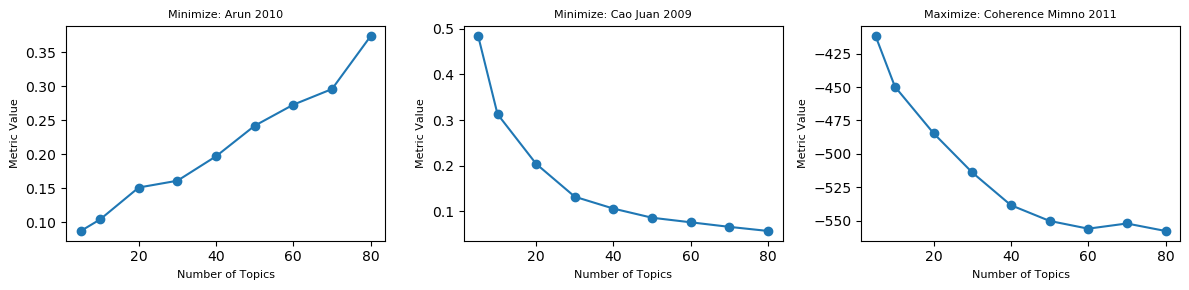

running the evaluation for: eta_0.09__alpha_00.4
[.] constant parameters: {'n_iter': 500, 'eta': 0.09, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.4}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 20, 'alpha': 0.4}, {'n_topics': 30, 'alpha': 0.4}, {'n_topics': 40, 'alpha': 0.4}, {'n_topics': 50, 'alpha': 0.4}, {'n_topics': 60, 'alpha': 0.4}, {'n_topics': 70, 'alpha': 0.4}, {'n_topics': 80, 'alpha': 0.4}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.087, 'cao_juan_2009': 0.458, 'coherence_mimno_2011': -403.846}), (10, {'arun_2010': 0.099, 'cao_juan_2009': 0.29, 'coherence_mimno_2011': -453.631}), (20, {'arun_2010': 0.144, 'cao_juan_2009': 0.173, 'coherence_mimno_2011': -507.726}), (30, {'arun_2010': 0.192, 'cao_juan_2009': 0.104, 'coherence_mimno_2011': -529.935}), (40, {'arun_2010': 0.188, 'cao_juan_2009': 0.089, 'co

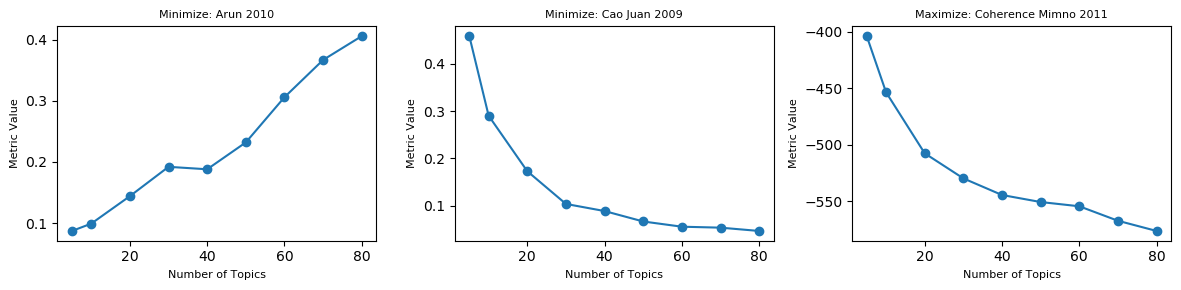

running the evaluation for: eta_0.09__alpha_00.5
[.] constant parameters: {'n_iter': 500, 'eta': 0.09, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.5}, {'n_topics': 10, 'alpha': 0.5}, {'n_topics': 20, 'alpha': 0.5}, {'n_topics': 30, 'alpha': 0.5}, {'n_topics': 40, 'alpha': 0.5}, {'n_topics': 50, 'alpha': 0.5}, {'n_topics': 60, 'alpha': 0.5}, {'n_topics': 70, 'alpha': 0.5}, {'n_topics': 80, 'alpha': 0.5}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.086, 'cao_juan_2009': 0.41, 'coherence_mimno_2011': -422.866}), (10, {'arun_2010': 0.097, 'cao_juan_2009': 0.27, 'coherence_mimno_2011': -467.619}), (20, {'arun_2010': 0.135, 'cao_juan_2009': 0.139, 'coherence_mimno_2011': -516.249}), (30, {'arun_2010': 0.177, 'cao_juan_2009': 0.093, 'coherence_mimno_2011': -542.865}), (40, {'arun_2010': 0.226, 'cao_juan_2009': 0.077, 'coh

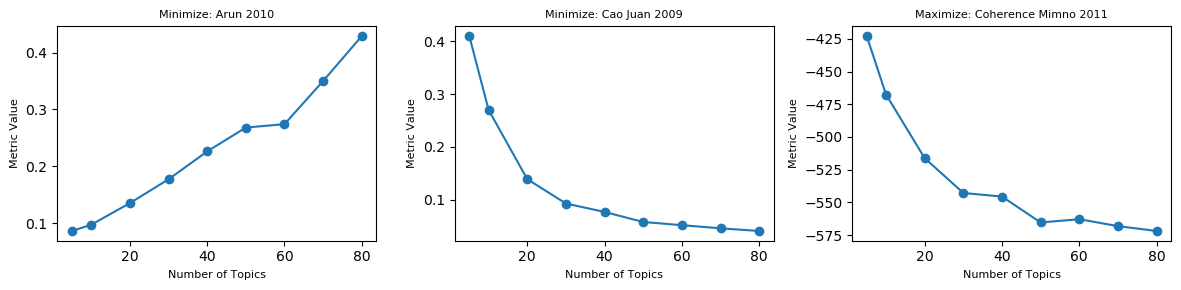

running the evaluation for: eta_0.09__alpha_00.6
[.] constant parameters: {'n_iter': 500, 'eta': 0.09, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.6}, {'n_topics': 10, 'alpha': 0.6}, {'n_topics': 20, 'alpha': 0.6}, {'n_topics': 30, 'alpha': 0.6}, {'n_topics': 40, 'alpha': 0.6}, {'n_topics': 50, 'alpha': 0.6}, {'n_topics': 60, 'alpha': 0.6}, {'n_topics': 70, 'alpha': 0.6}, {'n_topics': 80, 'alpha': 0.6}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.084, 'cao_juan_2009': 0.379, 'coherence_mimno_2011': -430.308}), (10, {'arun_2010': 0.087, 'cao_juan_2009': 0.23, 'coherence_mimno_2011': -487.906}), (20, {'arun_2010': 0.129, 'cao_juan_2009': 0.121, 'coherence_mimno_2011': -520.139}), (30, {'arun_2010': 0.189, 'cao_juan_2009': 0.078, 'coherence_mimno_2011': -542.828}), (40, {'arun_2010': 0.226, 'cao_juan_2009': 0.063, 'co

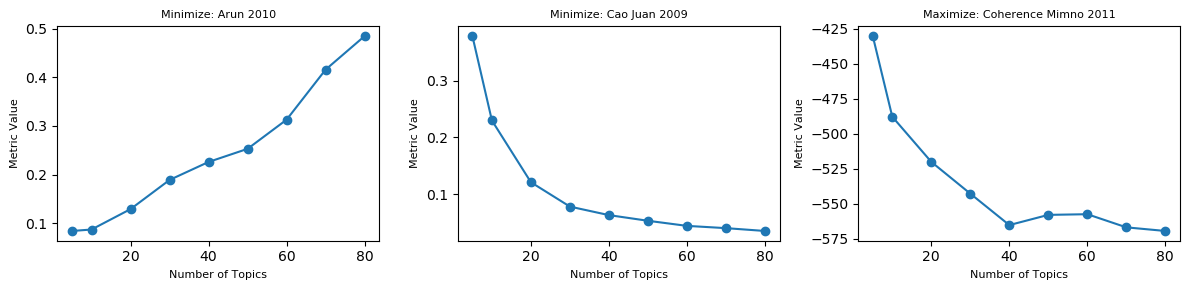

running the evaluation for: eta_0.09__alpha_00.7
[.] constant parameters: {'n_iter': 500, 'eta': 0.09, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.7}, {'n_topics': 10, 'alpha': 0.7}, {'n_topics': 20, 'alpha': 0.7}, {'n_topics': 30, 'alpha': 0.7}, {'n_topics': 40, 'alpha': 0.7}, {'n_topics': 50, 'alpha': 0.7}, {'n_topics': 60, 'alpha': 0.7}, {'n_topics': 70, 'alpha': 0.7}, {'n_topics': 80, 'alpha': 0.7}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.083, 'cao_juan_2009': 0.362, 'coherence_mimno_2011': -424.517}), (10, {'arun_2010': 0.089, 'cao_juan_2009': 0.237, 'coherence_mimno_2011': -481.97}), (20, {'arun_2010': 0.144, 'cao_juan_2009': 0.115, 'coherence_mimno_2011': -535.884}), (30, {'arun_2010': 0.184, 'cao_juan_2009': 0.077, 'coherence_mimno_2011': -550.771}), (40, {'arun_2010': 0.206, 'cao_juan_2009': 0.053, 'co

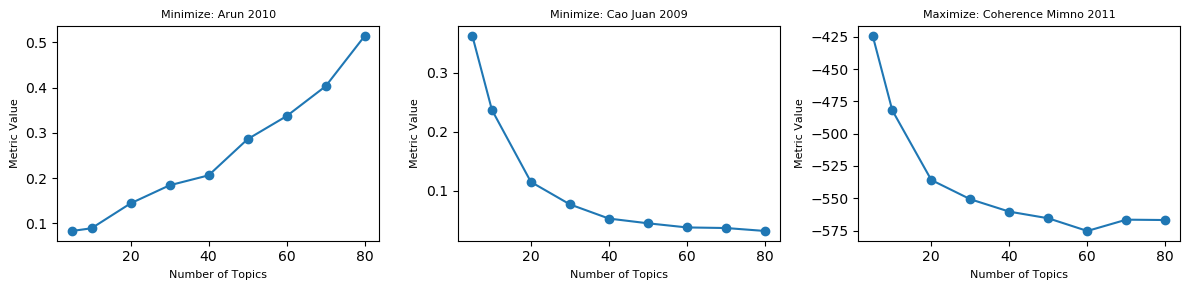

running the evaluation for: eta_0.09__alpha_00.8
[.] constant parameters: {'n_iter': 500, 'eta': 0.09, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.8}, {'n_topics': 20, 'alpha': 0.8}, {'n_topics': 30, 'alpha': 0.8}, {'n_topics': 40, 'alpha': 0.8}, {'n_topics': 50, 'alpha': 0.8}, {'n_topics': 60, 'alpha': 0.8}, {'n_topics': 70, 'alpha': 0.8}, {'n_topics': 80, 'alpha': 0.8}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.083, 'cao_juan_2009': 0.348, 'coherence_mimno_2011': -438.442}), (10, {'arun_2010': 0.089, 'cao_juan_2009': 0.195, 'coherence_mimno_2011': -491.386}), (20, {'arun_2010': 0.159, 'cao_juan_2009': 0.09, 'coherence_mimno_2011': -535.136}), (30, {'arun_2010': 0.193, 'cao_juan_2009': 0.062, 'coherence_mimno_2011': -550.341}), (40, {'arun_2010': 0.254, 'cao_juan_2009': 0.051, 'co

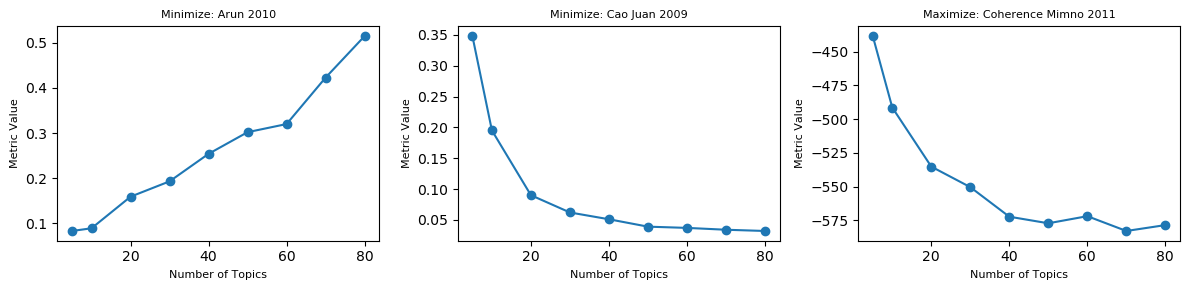

running the evaluation for: eta_0.09__alpha_00.9
[.] constant parameters: {'n_iter': 500, 'eta': 0.09, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.9}, {'n_topics': 10, 'alpha': 0.9}, {'n_topics': 20, 'alpha': 0.9}, {'n_topics': 30, 'alpha': 0.9}, {'n_topics': 40, 'alpha': 0.9}, {'n_topics': 50, 'alpha': 0.9}, {'n_topics': 60, 'alpha': 0.9}, {'n_topics': 70, 'alpha': 0.9}, {'n_topics': 80, 'alpha': 0.9}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.083, 'cao_juan_2009': 0.351, 'coherence_mimno_2011': -415.665}), (10, {'arun_2010': 0.077, 'cao_juan_2009': 0.182, 'coherence_mimno_2011': -485.963}), (20, {'arun_2010': 0.157, 'cao_juan_2009': 0.089, 'coherence_mimno_2011': -531.717}), (30, {'arun_2010': 0.16, 'cao_juan_2009': 0.062, 'coherence_mimno_2011': -550.937}), (40, {'arun_2010': 0.28, 'cao_juan_2009': 0.039, 'coh

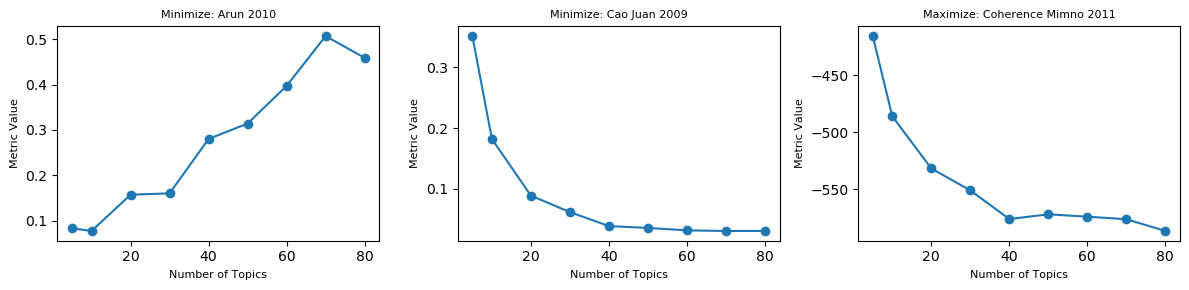

running the evaluation for: eta_0.09__alpha_01.0
[.] constant parameters: {'n_iter': 500, 'eta': 0.09, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 1.0}, {'n_topics': 10, 'alpha': 1.0}, {'n_topics': 20, 'alpha': 1.0}, {'n_topics': 30, 'alpha': 1.0}, {'n_topics': 40, 'alpha': 1.0}, {'n_topics': 50, 'alpha': 1.0}, {'n_topics': 60, 'alpha': 1.0}, {'n_topics': 70, 'alpha': 1.0}, {'n_topics': 80, 'alpha': 1.0}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.054, 'cao_juan_2009': 0.274, 'coherence_mimno_2011': -438.822}), (10, {'arun_2010': 0.093, 'cao_juan_2009': 0.188, 'coherence_mimno_2011': -495.226}), (20, {'arun_2010': 0.162, 'cao_juan_2009': 0.078, 'coherence_mimno_2011': -557.155}), (30, {'arun_2010': 0.196, 'cao_juan_2009': 0.053, 'coherence_mimno_2011': -564.502}), (40, {'arun_2010': 0.281, 'cao_juan_2009': 0.042, 'c

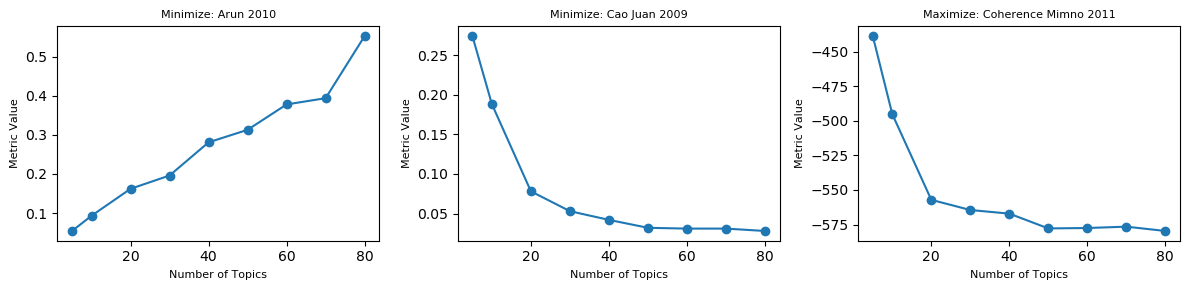

running the evaluation for: eta_0.08__alpha_00.1
[.] constant parameters: {'n_iter': 500, 'eta': 0.08, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.1}, {'n_topics': 10, 'alpha': 0.1}, {'n_topics': 20, 'alpha': 0.1}, {'n_topics': 30, 'alpha': 0.1}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.1}, {'n_topics': 60, 'alpha': 0.1}, {'n_topics': 70, 'alpha': 0.1}, {'n_topics': 80, 'alpha': 0.1}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.095, 'cao_juan_2009': 0.567, 'coherence_mimno_2011': -380.796}), (10, {'arun_2010': 0.135, 'cao_juan_2009': 0.457, 'coherence_mimno_2011': -426.906}), (20, {'arun_2010': 0.174, 'cao_juan_2009': 0.335, 'coherence_mimno_2011': -423.341}), (30, {'arun_2010': 0.194, 'cao_juan_2009': 0.253, 'coherence_mimno_2011': -462.81}), (40, {'arun_2010': 0.181, 'cao_juan_2009': 0.206, 'co

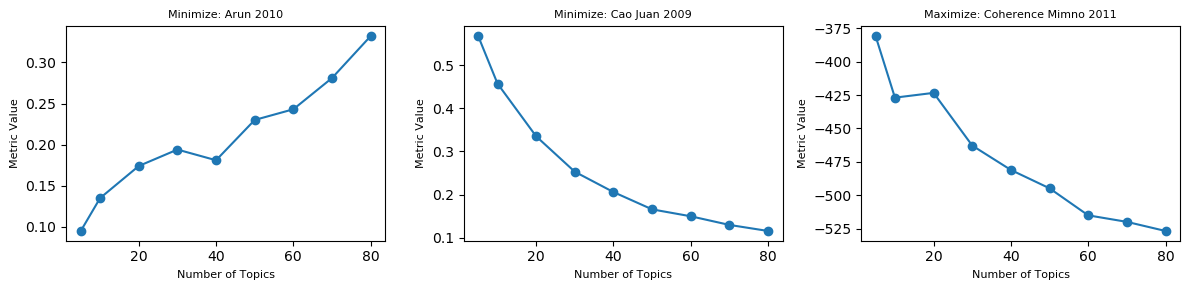

running the evaluation for: eta_0.08__alpha_00.2
[.] constant parameters: {'n_iter': 500, 'eta': 0.08, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.2}, {'n_topics': 10, 'alpha': 0.2}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.2}, {'n_topics': 40, 'alpha': 0.2}, {'n_topics': 50, 'alpha': 0.2}, {'n_topics': 60, 'alpha': 0.2}, {'n_topics': 70, 'alpha': 0.2}, {'n_topics': 80, 'alpha': 0.2}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.075, 'cao_juan_2009': 0.51, 'coherence_mimno_2011': -396.711}), (10, {'arun_2010': 0.093, 'cao_juan_2009': 0.342, 'coherence_mimno_2011': -440.089}), (20, {'arun_2010': 0.153, 'cao_juan_2009': 0.238, 'coherence_mimno_2011': -459.775}), (30, {'arun_2010': 0.158, 'cao_juan_2009': 0.184, 'coherence_mimno_2011': -486.587}), (40, {'arun_2010': 0.183, 'cao_juan_2009': 0.135, 'co

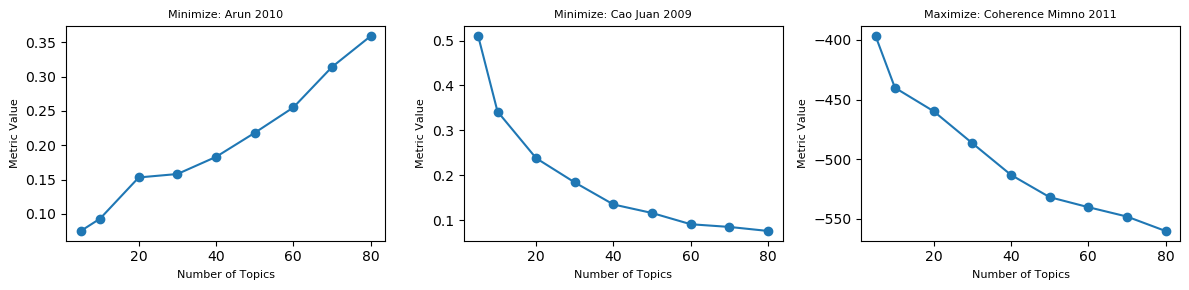

running the evaluation for: eta_0.08__alpha_00.3
[.] constant parameters: {'n_iter': 500, 'eta': 0.08, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.3}, {'n_topics': 10, 'alpha': 0.3}, {'n_topics': 20, 'alpha': 0.3}, {'n_topics': 30, 'alpha': 0.3}, {'n_topics': 40, 'alpha': 0.3}, {'n_topics': 50, 'alpha': 0.3}, {'n_topics': 60, 'alpha': 0.3}, {'n_topics': 70, 'alpha': 0.3}, {'n_topics': 80, 'alpha': 0.3}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.087, 'cao_juan_2009': 0.485, 'coherence_mimno_2011': -405.752}), (10, {'arun_2010': 0.1, 'cao_juan_2009': 0.308, 'coherence_mimno_2011': -436.814}), (20, {'arun_2010': 0.123, 'cao_juan_2009': 0.196, 'coherence_mimno_2011': -489.04}), (30, {'arun_2010': 0.161, 'cao_juan_2009': 0.137, 'coherence_mimno_2011': -512.027}), (40, {'arun_2010': 0.198, 'cao_juan_2009': 0.108, 'cohe

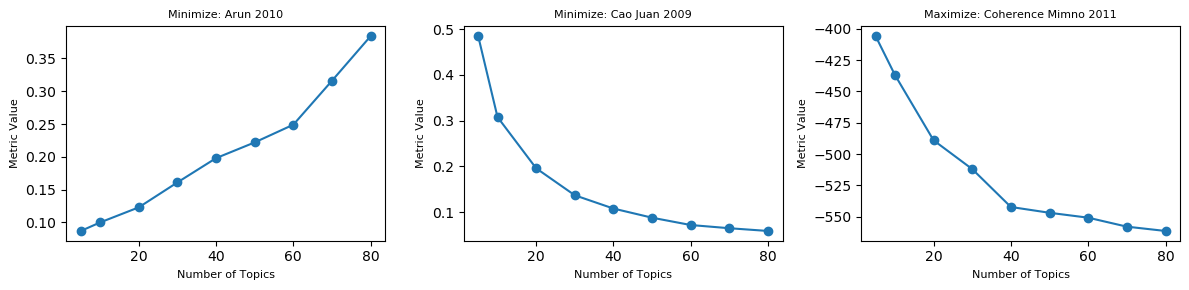

running the evaluation for: eta_0.08__alpha_00.4
[.] constant parameters: {'n_iter': 500, 'eta': 0.08, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.4}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 20, 'alpha': 0.4}, {'n_topics': 30, 'alpha': 0.4}, {'n_topics': 40, 'alpha': 0.4}, {'n_topics': 50, 'alpha': 0.4}, {'n_topics': 60, 'alpha': 0.4}, {'n_topics': 70, 'alpha': 0.4}, {'n_topics': 80, 'alpha': 0.4}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.092, 'cao_juan_2009': 0.454, 'coherence_mimno_2011': -407.672}), (10, {'arun_2010': 0.105, 'cao_juan_2009': 0.283, 'coherence_mimno_2011': -465.626}), (20, {'arun_2010': 0.15, 'cao_juan_2009': 0.173, 'coherence_mimno_2011': -497.001}), (30, {'arun_2010': 0.161, 'cao_juan_2009': 0.113, 'coherence_mimno_2011': -531.61}), (40, {'arun_2010': 0.196, 'cao_juan_2009': 0.088, 'coh

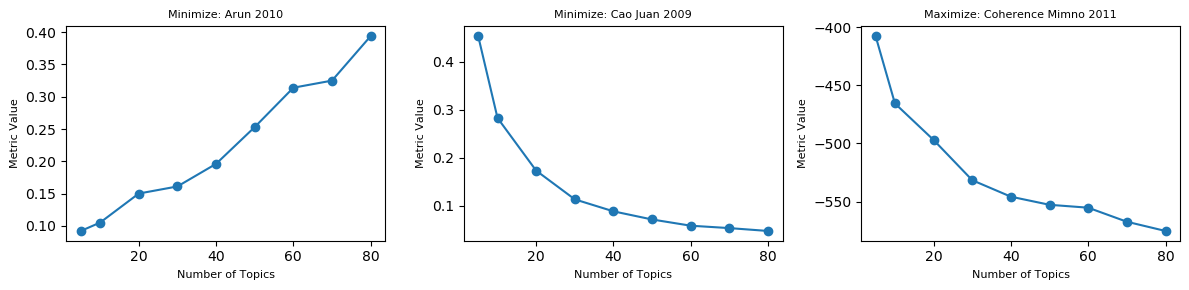

running the evaluation for: eta_0.08__alpha_00.5
[.] constant parameters: {'n_iter': 500, 'eta': 0.08, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.5}, {'n_topics': 10, 'alpha': 0.5}, {'n_topics': 20, 'alpha': 0.5}, {'n_topics': 30, 'alpha': 0.5}, {'n_topics': 40, 'alpha': 0.5}, {'n_topics': 50, 'alpha': 0.5}, {'n_topics': 60, 'alpha': 0.5}, {'n_topics': 70, 'alpha': 0.5}, {'n_topics': 80, 'alpha': 0.5}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.088, 'cao_juan_2009': 0.406, 'coherence_mimno_2011': -426.778}), (10, {'arun_2010': 0.096, 'cao_juan_2009': 0.272, 'coherence_mimno_2011': -468.086}), (20, {'arun_2010': 0.146, 'cao_juan_2009': 0.15, 'coherence_mimno_2011': -514.898}), (30, {'arun_2010': 0.176, 'cao_juan_2009': 0.095, 'coherence_mimno_2011': -540.137}), (40, {'arun_2010': 0.2, 'cao_juan_2009': 0.071, 'cohe

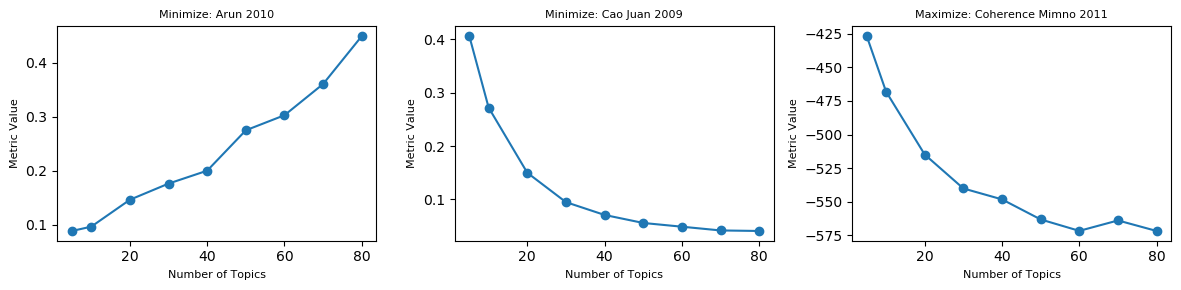

running the evaluation for: eta_0.08__alpha_00.6
[.] constant parameters: {'n_iter': 500, 'eta': 0.08, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.6}, {'n_topics': 10, 'alpha': 0.6}, {'n_topics': 20, 'alpha': 0.6}, {'n_topics': 30, 'alpha': 0.6}, {'n_topics': 40, 'alpha': 0.6}, {'n_topics': 50, 'alpha': 0.6}, {'n_topics': 60, 'alpha': 0.6}, {'n_topics': 70, 'alpha': 0.6}, {'n_topics': 80, 'alpha': 0.6}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.087, 'cao_juan_2009': 0.379, 'coherence_mimno_2011': -431.464}), (10, {'arun_2010': 0.087, 'cao_juan_2009': 0.243, 'coherence_mimno_2011': -468.147}), (20, {'arun_2010': 0.153, 'cao_juan_2009': 0.114, 'coherence_mimno_2011': -516.332}), (30, {'arun_2010': 0.158, 'cao_juan_2009': 0.087, 'coherence_mimno_2011': -568.229}), (40, {'arun_2010': 0.236, 'cao_juan_2009': 0.057, 'c

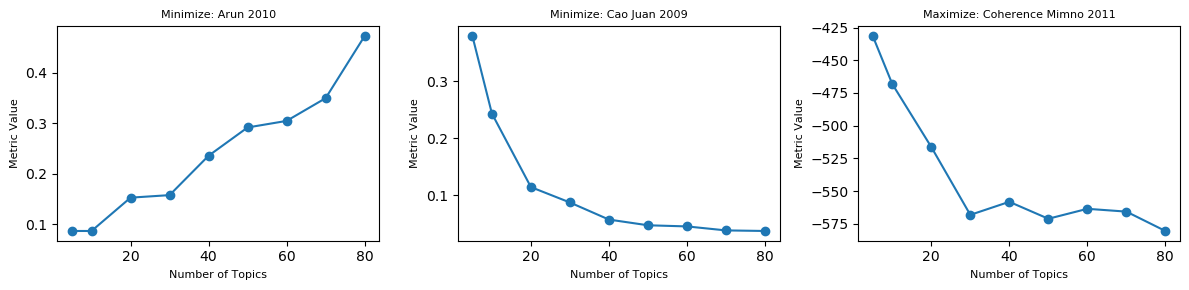

running the evaluation for: eta_0.08__alpha_00.7
[.] constant parameters: {'n_iter': 500, 'eta': 0.08, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.7}, {'n_topics': 10, 'alpha': 0.7}, {'n_topics': 20, 'alpha': 0.7}, {'n_topics': 30, 'alpha': 0.7}, {'n_topics': 40, 'alpha': 0.7}, {'n_topics': 50, 'alpha': 0.7}, {'n_topics': 60, 'alpha': 0.7}, {'n_topics': 70, 'alpha': 0.7}, {'n_topics': 80, 'alpha': 0.7}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.081, 'cao_juan_2009': 0.361, 'coherence_mimno_2011': -432.044}), (10, {'arun_2010': 0.084, 'cao_juan_2009': 0.21, 'coherence_mimno_2011': -485.626}), (20, {'arun_2010': 0.141, 'cao_juan_2009': 0.106, 'coherence_mimno_2011': -529.109}), (30, {'arun_2010': 0.169, 'cao_juan_2009': 0.072, 'coherence_mimno_2011': -556.073}), (40, {'arun_2010': 0.238, 'cao_juan_2009': 0.053, 'co

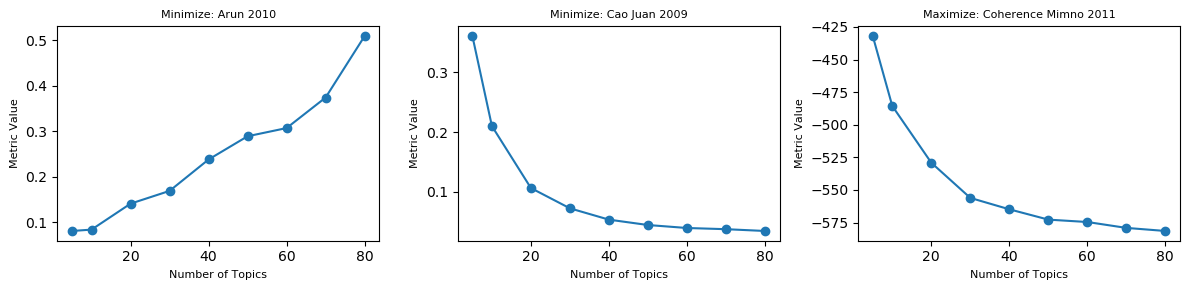

running the evaluation for: eta_0.08__alpha_00.8
[.] constant parameters: {'n_iter': 500, 'eta': 0.08, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.8}, {'n_topics': 20, 'alpha': 0.8}, {'n_topics': 30, 'alpha': 0.8}, {'n_topics': 40, 'alpha': 0.8}, {'n_topics': 50, 'alpha': 0.8}, {'n_topics': 60, 'alpha': 0.8}, {'n_topics': 70, 'alpha': 0.8}, {'n_topics': 80, 'alpha': 0.8}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.084, 'cao_juan_2009': 0.348, 'coherence_mimno_2011': -426.781}), (10, {'arun_2010': 0.097, 'cao_juan_2009': 0.205, 'coherence_mimno_2011': -491.623}), (20, {'arun_2010': 0.142, 'cao_juan_2009': 0.097, 'coherence_mimno_2011': -533.694}), (30, {'arun_2010': 0.158, 'cao_juan_2009': 0.068, 'coherence_mimno_2011': -556.256}), (40, {'arun_2010': 0.233, 'cao_juan_2009': 0.054, 'c

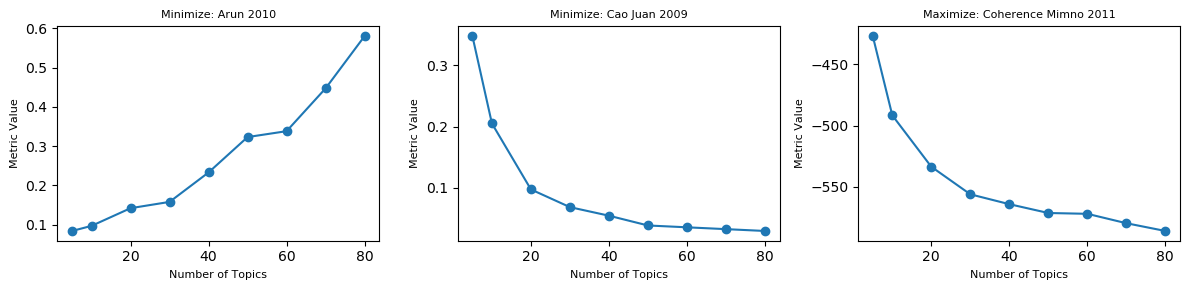

running the evaluation for: eta_0.08__alpha_00.9
[.] constant parameters: {'n_iter': 500, 'eta': 0.08, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.9}, {'n_topics': 10, 'alpha': 0.9}, {'n_topics': 20, 'alpha': 0.9}, {'n_topics': 30, 'alpha': 0.9}, {'n_topics': 40, 'alpha': 0.9}, {'n_topics': 50, 'alpha': 0.9}, {'n_topics': 60, 'alpha': 0.9}, {'n_topics': 70, 'alpha': 0.9}, {'n_topics': 80, 'alpha': 0.9}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.081, 'cao_juan_2009': 0.337, 'coherence_mimno_2011': -426.341}), (10, {'arun_2010': 0.095, 'cao_juan_2009': 0.177, 'coherence_mimno_2011': -493.367}), (20, {'arun_2010': 0.166, 'cao_juan_2009': 0.083, 'coherence_mimno_2011': -538.881}), (30, {'arun_2010': 0.164, 'cao_juan_2009': 0.059, 'coherence_mimno_2011': -551.465}), (40, {'arun_2010': 0.229, 'cao_juan_2009': 0.046, 'c

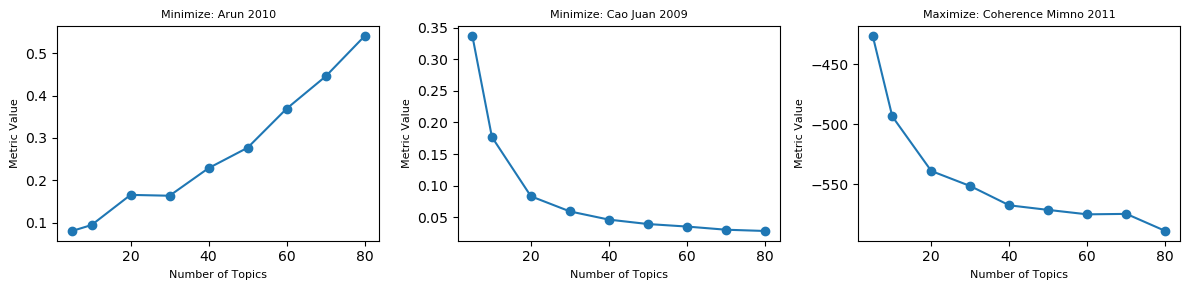

running the evaluation for: eta_0.08__alpha_01.0
[.] constant parameters: {'n_iter': 500, 'eta': 0.08, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 1.0}, {'n_topics': 10, 'alpha': 1.0}, {'n_topics': 20, 'alpha': 1.0}, {'n_topics': 30, 'alpha': 1.0}, {'n_topics': 40, 'alpha': 1.0}, {'n_topics': 50, 'alpha': 1.0}, {'n_topics': 60, 'alpha': 1.0}, {'n_topics': 70, 'alpha': 1.0}, {'n_topics': 80, 'alpha': 1.0}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.081, 'cao_juan_2009': 0.315, 'coherence_mimno_2011': -428.868}), (10, {'arun_2010': 0.089, 'cao_juan_2009': 0.18, 'coherence_mimno_2011': -495.067}), (20, {'arun_2010': 0.152, 'cao_juan_2009': 0.077, 'coherence_mimno_2011': -555.265}), (30, {'arun_2010': 0.187, 'cao_juan_2009': 0.057, 'coherence_mimno_2011': -570.381}), (40, {'arun_2010': 0.259, 'cao_juan_2009': 0.038, 'co

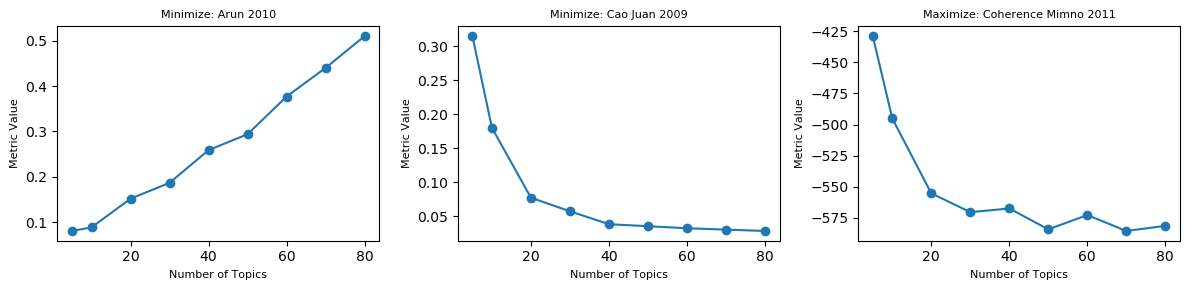

running the evaluation for: eta_0.07__alpha_00.1
[.] constant parameters: {'n_iter': 500, 'eta': 0.07, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.1}, {'n_topics': 10, 'alpha': 0.1}, {'n_topics': 20, 'alpha': 0.1}, {'n_topics': 30, 'alpha': 0.1}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.1}, {'n_topics': 60, 'alpha': 0.1}, {'n_topics': 70, 'alpha': 0.1}, {'n_topics': 80, 'alpha': 0.1}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.107, 'cao_juan_2009': 0.552, 'coherence_mimno_2011': -397.722}), (10, {'arun_2010': 0.158, 'cao_juan_2009': 0.463, 'coherence_mimno_2011': -417.057}), (20, {'arun_2010': 0.163, 'cao_juan_2009': 0.325, 'coherence_mimno_2011': -432.069}), (30, {'arun_2010': 0.171, 'cao_juan_2009': 0.25, 'coherence_mimno_2011': -459.041}), (40, {'arun_2010': 0.18, 'cao_juan_2009': 0.206, 'coh

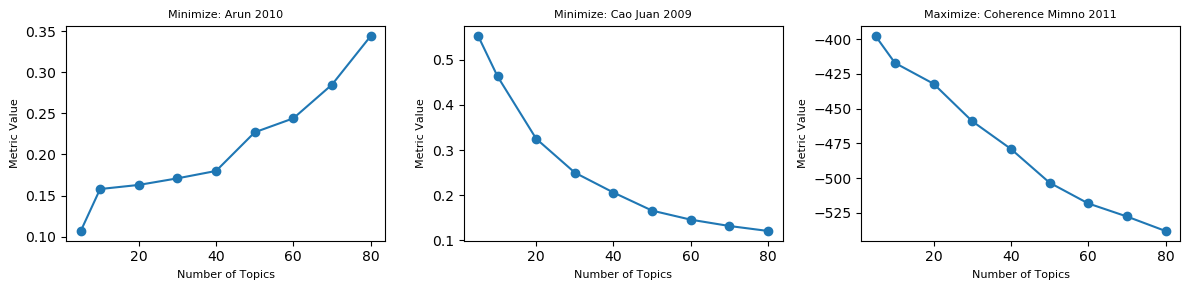

running the evaluation for: eta_0.07__alpha_00.2
[.] constant parameters: {'n_iter': 500, 'eta': 0.07, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.2}, {'n_topics': 10, 'alpha': 0.2}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.2}, {'n_topics': 40, 'alpha': 0.2}, {'n_topics': 50, 'alpha': 0.2}, {'n_topics': 60, 'alpha': 0.2}, {'n_topics': 70, 'alpha': 0.2}, {'n_topics': 80, 'alpha': 0.2}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.1, 'cao_juan_2009': 0.496, 'coherence_mimno_2011': -408.753}), (10, {'arun_2010': 0.101, 'cao_juan_2009': 0.358, 'coherence_mimno_2011': -431.799}), (20, {'arun_2010': 0.133, 'cao_juan_2009': 0.232, 'coherence_mimno_2011': -465.739}), (30, {'arun_2010': 0.151, 'cao_juan_2009': 0.177, 'coherence_mimno_2011': -501.153}), (40, {'arun_2010': 0.185, 'cao_juan_2009': 0.136, 'coh

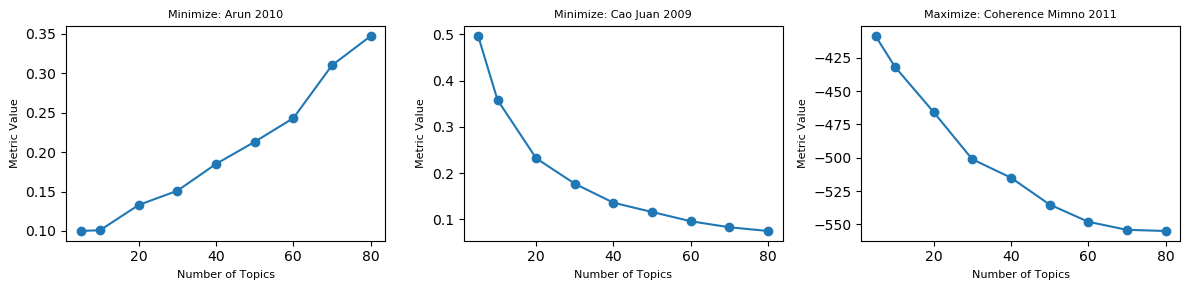

running the evaluation for: eta_0.07__alpha_00.3
[.] constant parameters: {'n_iter': 500, 'eta': 0.07, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.3}, {'n_topics': 10, 'alpha': 0.3}, {'n_topics': 20, 'alpha': 0.3}, {'n_topics': 30, 'alpha': 0.3}, {'n_topics': 40, 'alpha': 0.3}, {'n_topics': 50, 'alpha': 0.3}, {'n_topics': 60, 'alpha': 0.3}, {'n_topics': 70, 'alpha': 0.3}, {'n_topics': 80, 'alpha': 0.3}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.088, 'cao_juan_2009': 0.483, 'coherence_mimno_2011': -413.291}), (10, {'arun_2010': 0.104, 'cao_juan_2009': 0.321, 'coherence_mimno_2011': -442.19}), (20, {'arun_2010': 0.148, 'cao_juan_2009': 0.204, 'coherence_mimno_2011': -473.588}), (30, {'arun_2010': 0.155, 'cao_juan_2009': 0.139, 'coherence_mimno_2011': -517.383}), (40, {'arun_2010': 0.184, 'cao_juan_2009': 0.104, 'co

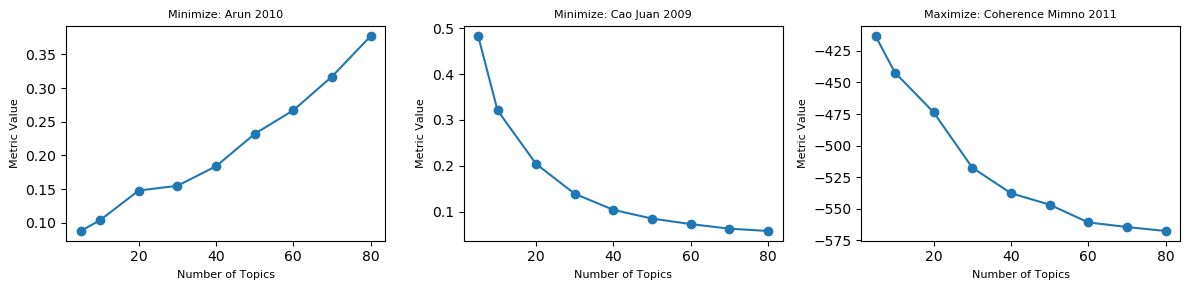

running the evaluation for: eta_0.07__alpha_00.4
[.] constant parameters: {'n_iter': 500, 'eta': 0.07, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.4}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 20, 'alpha': 0.4}, {'n_topics': 30, 'alpha': 0.4}, {'n_topics': 40, 'alpha': 0.4}, {'n_topics': 50, 'alpha': 0.4}, {'n_topics': 60, 'alpha': 0.4}, {'n_topics': 70, 'alpha': 0.4}, {'n_topics': 80, 'alpha': 0.4}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.086, 'cao_juan_2009': 0.459, 'coherence_mimno_2011': -399.623}), (10, {'arun_2010': 0.112, 'cao_juan_2009': 0.288, 'coherence_mimno_2011': -462.966}), (20, {'arun_2010': 0.123, 'cao_juan_2009': 0.171, 'coherence_mimno_2011': -508.826}), (30, {'arun_2010': 0.174, 'cao_juan_2009': 0.109, 'coherence_mimno_2011': -536.219}), (40, {'arun_2010': 0.211, 'cao_juan_2009': 0.086, 'c

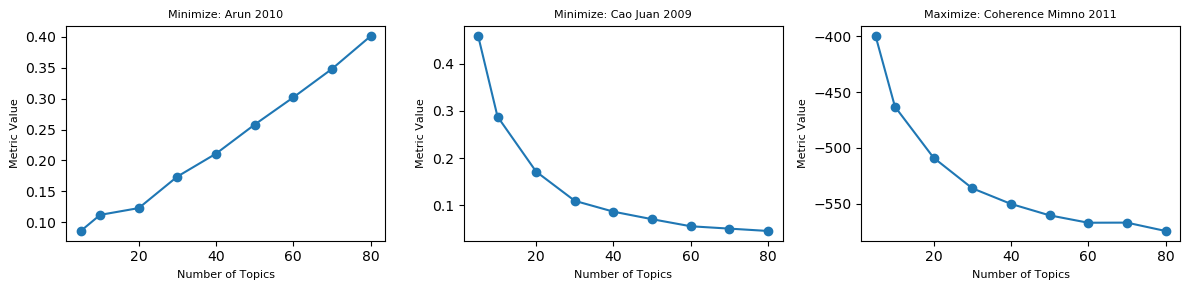

running the evaluation for: eta_0.07__alpha_00.5
[.] constant parameters: {'n_iter': 500, 'eta': 0.07, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.5}, {'n_topics': 10, 'alpha': 0.5}, {'n_topics': 20, 'alpha': 0.5}, {'n_topics': 30, 'alpha': 0.5}, {'n_topics': 40, 'alpha': 0.5}, {'n_topics': 50, 'alpha': 0.5}, {'n_topics': 60, 'alpha': 0.5}, {'n_topics': 70, 'alpha': 0.5}, {'n_topics': 80, 'alpha': 0.5}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.085, 'cao_juan_2009': 0.405, 'coherence_mimno_2011': -429.521}), (10, {'arun_2010': 0.107, 'cao_juan_2009': 0.268, 'coherence_mimno_2011': -458.786}), (20, {'arun_2010': 0.134, 'cao_juan_2009': 0.144, 'coherence_mimno_2011': -515.195}), (30, {'arun_2010': 0.169, 'cao_juan_2009': 0.094, 'coherence_mimno_2011': -548.427}), (40, {'arun_2010': 0.225, 'cao_juan_2009': 0.07, 'co

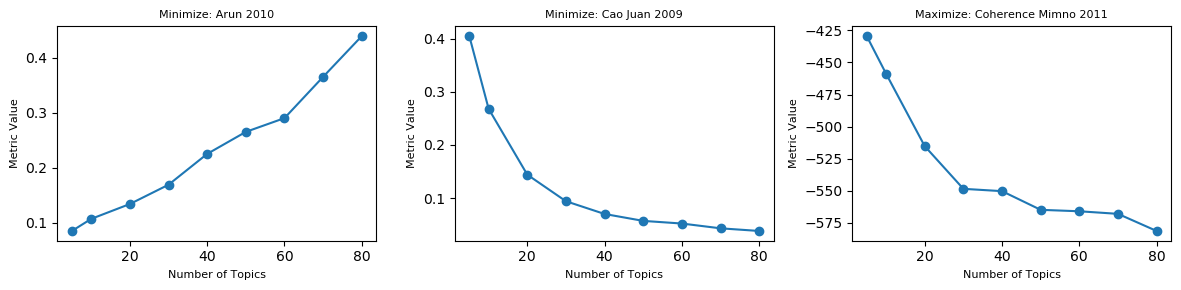

running the evaluation for: eta_0.07__alpha_00.6
[.] constant parameters: {'n_iter': 500, 'eta': 0.07, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.6}, {'n_topics': 10, 'alpha': 0.6}, {'n_topics': 20, 'alpha': 0.6}, {'n_topics': 30, 'alpha': 0.6}, {'n_topics': 40, 'alpha': 0.6}, {'n_topics': 50, 'alpha': 0.6}, {'n_topics': 60, 'alpha': 0.6}, {'n_topics': 70, 'alpha': 0.6}, {'n_topics': 80, 'alpha': 0.6}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.084, 'cao_juan_2009': 0.379, 'coherence_mimno_2011': -432.744}), (10, {'arun_2010': 0.092, 'cao_juan_2009': 0.241, 'coherence_mimno_2011': -465.259}), (20, {'arun_2010': 0.146, 'cao_juan_2009': 0.124, 'coherence_mimno_2011': -521.078}), (30, {'arun_2010': 0.174, 'cao_juan_2009': 0.084, 'coherence_mimno_2011': -548.049}), (40, {'arun_2010': 0.206, 'cao_juan_2009': 0.061, 'c

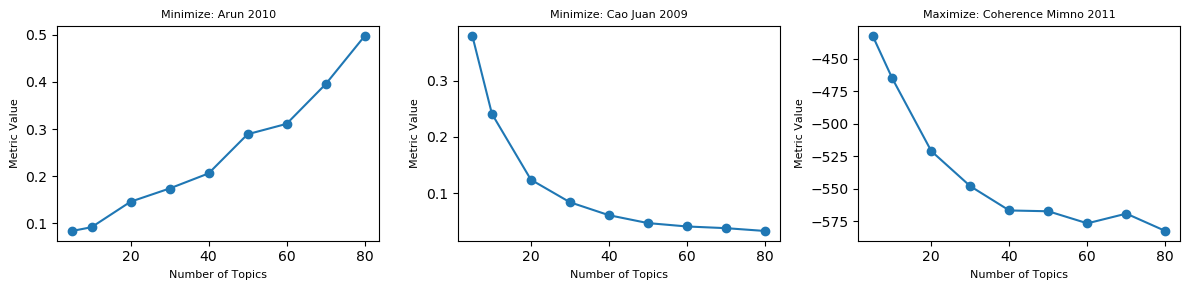

running the evaluation for: eta_0.07__alpha_00.7
[.] constant parameters: {'n_iter': 500, 'eta': 0.07, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.7}, {'n_topics': 10, 'alpha': 0.7}, {'n_topics': 20, 'alpha': 0.7}, {'n_topics': 30, 'alpha': 0.7}, {'n_topics': 40, 'alpha': 0.7}, {'n_topics': 50, 'alpha': 0.7}, {'n_topics': 60, 'alpha': 0.7}, {'n_topics': 70, 'alpha': 0.7}, {'n_topics': 80, 'alpha': 0.7}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.083, 'cao_juan_2009': 0.359, 'coherence_mimno_2011': -425.896}), (10, {'arun_2010': 0.083, 'cao_juan_2009': 0.23, 'coherence_mimno_2011': -471.319}), (20, {'arun_2010': 0.134, 'cao_juan_2009': 0.114, 'coherence_mimno_2011': -536.448}), (30, {'arun_2010': 0.181, 'cao_juan_2009': 0.069, 'coherence_mimno_2011': -547.483}), (40, {'arun_2010': 0.24, 'cao_juan_2009': 0.056, 'coh

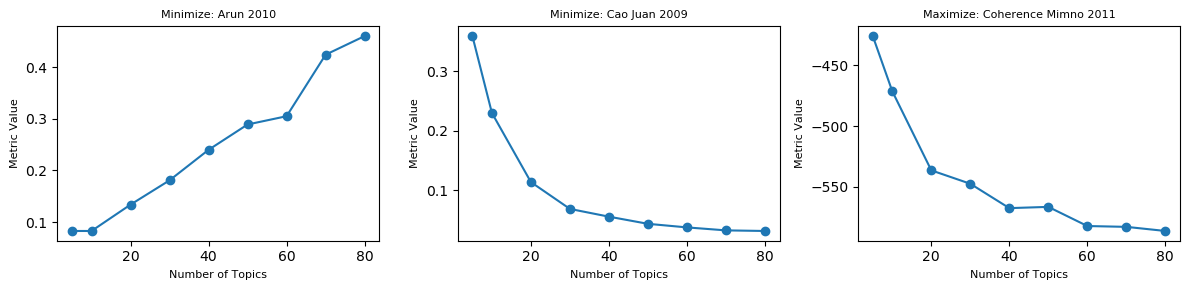

running the evaluation for: eta_0.07__alpha_00.8
[.] constant parameters: {'n_iter': 500, 'eta': 0.07, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.8}, {'n_topics': 20, 'alpha': 0.8}, {'n_topics': 30, 'alpha': 0.8}, {'n_topics': 40, 'alpha': 0.8}, {'n_topics': 50, 'alpha': 0.8}, {'n_topics': 60, 'alpha': 0.8}, {'n_topics': 70, 'alpha': 0.8}, {'n_topics': 80, 'alpha': 0.8}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.083, 'cao_juan_2009': 0.346, 'coherence_mimno_2011': -430.575}), (10, {'arun_2010': 0.097, 'cao_juan_2009': 0.203, 'coherence_mimno_2011': -487.376}), (20, {'arun_2010': 0.146, 'cao_juan_2009': 0.104, 'coherence_mimno_2011': -532.731}), (30, {'arun_2010': 0.172, 'cao_juan_2009': 0.069, 'coherence_mimno_2011': -560.295}), (40, {'arun_2010': 0.268, 'cao_juan_2009': 0.046, 'c

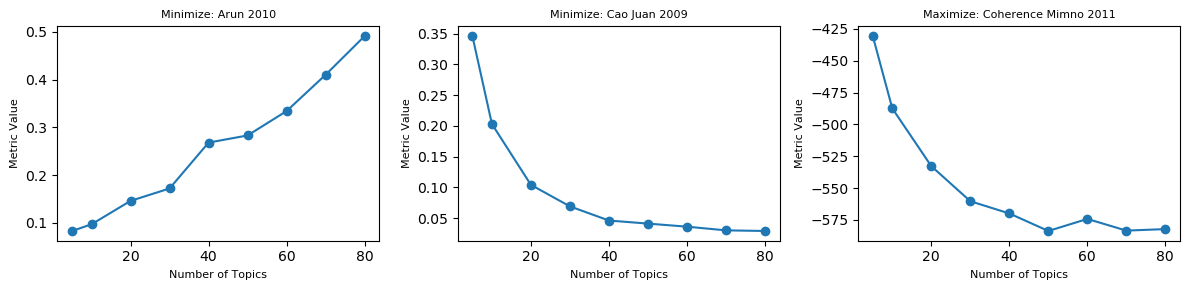

running the evaluation for: eta_0.07__alpha_00.9
[.] constant parameters: {'n_iter': 500, 'eta': 0.07, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.9}, {'n_topics': 10, 'alpha': 0.9}, {'n_topics': 20, 'alpha': 0.9}, {'n_topics': 30, 'alpha': 0.9}, {'n_topics': 40, 'alpha': 0.9}, {'n_topics': 50, 'alpha': 0.9}, {'n_topics': 60, 'alpha': 0.9}, {'n_topics': 70, 'alpha': 0.9}, {'n_topics': 80, 'alpha': 0.9}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.08, 'cao_juan_2009': 0.339, 'coherence_mimno_2011': -427.692}), (10, {'arun_2010': 0.086, 'cao_juan_2009': 0.176, 'coherence_mimno_2011': -481.082}), (20, {'arun_2010': 0.148, 'cao_juan_2009': 0.09, 'coherence_mimno_2011': -538.657}), (30, {'arun_2010': 0.198, 'cao_juan_2009': 0.061, 'coherence_mimno_2011': -562.348}), (40, {'arun_2010': 0.244, 'cao_juan_2009': 0.041, 'coh

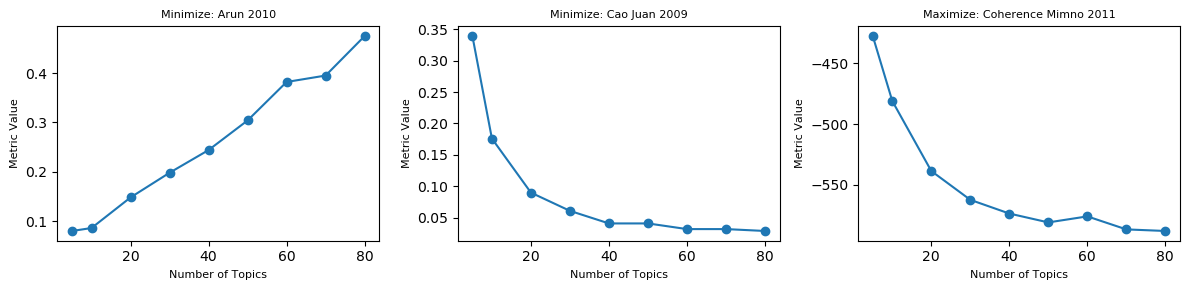

running the evaluation for: eta_0.07__alpha_01.0
[.] constant parameters: {'n_iter': 500, 'eta': 0.07, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 1.0}, {'n_topics': 10, 'alpha': 1.0}, {'n_topics': 20, 'alpha': 1.0}, {'n_topics': 30, 'alpha': 1.0}, {'n_topics': 40, 'alpha': 1.0}, {'n_topics': 50, 'alpha': 1.0}, {'n_topics': 60, 'alpha': 1.0}, {'n_topics': 70, 'alpha': 1.0}, {'n_topics': 80, 'alpha': 1.0}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.054, 'cao_juan_2009': 0.276, 'coherence_mimno_2011': -433.602}), (10, {'arun_2010': 0.116, 'cao_juan_2009': 0.153, 'coherence_mimno_2011': -496.76}), (20, {'arun_2010': 0.155, 'cao_juan_2009': 0.082, 'coherence_mimno_2011': -553.363}), (30, {'arun_2010': 0.169, 'cao_juan_2009': 0.055, 'coherence_mimno_2011': -562.885}), (40, {'arun_2010': 0.217, 'cao_juan_2009': 0.04, 'coh

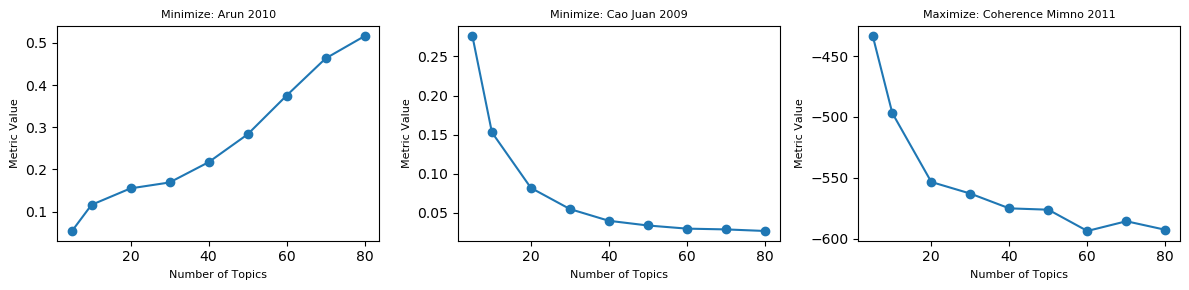

running the evaluation for: eta_0.06__alpha_00.1
[.] constant parameters: {'n_iter': 500, 'eta': 0.06, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.1}, {'n_topics': 10, 'alpha': 0.1}, {'n_topics': 20, 'alpha': 0.1}, {'n_topics': 30, 'alpha': 0.1}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.1}, {'n_topics': 60, 'alpha': 0.1}, {'n_topics': 70, 'alpha': 0.1}, {'n_topics': 80, 'alpha': 0.1}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.098, 'cao_juan_2009': 0.57, 'coherence_mimno_2011': -381.418}), (10, {'arun_2010': 0.127, 'cao_juan_2009': 0.437, 'coherence_mimno_2011': -418.973}), (20, {'arun_2010': 0.155, 'cao_juan_2009': 0.327, 'coherence_mimno_2011': -430.433}), (30, {'arun_2010': 0.162, 'cao_juan_2009': 0.259, 'coherence_mimno_2011': -458.606}), (40, {'arun_2010': 0.176, 'cao_juan_2009': 0.201, 'co

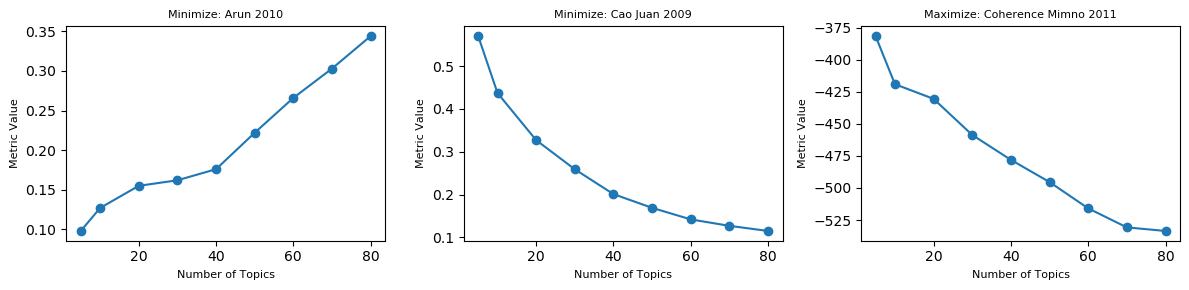

running the evaluation for: eta_0.06__alpha_00.2
[.] constant parameters: {'n_iter': 500, 'eta': 0.06, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.2}, {'n_topics': 10, 'alpha': 0.2}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.2}, {'n_topics': 40, 'alpha': 0.2}, {'n_topics': 50, 'alpha': 0.2}, {'n_topics': 60, 'alpha': 0.2}, {'n_topics': 70, 'alpha': 0.2}, {'n_topics': 80, 'alpha': 0.2}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.077, 'cao_juan_2009': 0.51, 'coherence_mimno_2011': -395.826}), (10, {'arun_2010': 0.129, 'cao_juan_2009': 0.363, 'coherence_mimno_2011': -432.917}), (20, {'arun_2010': 0.135, 'cao_juan_2009': 0.236, 'coherence_mimno_2011': -467.951}), (30, {'arun_2010': 0.152, 'cao_juan_2009': 0.178, 'coherence_mimno_2011': -492.013}), (40, {'arun_2010': 0.199, 'cao_juan_2009': 0.135, 'co

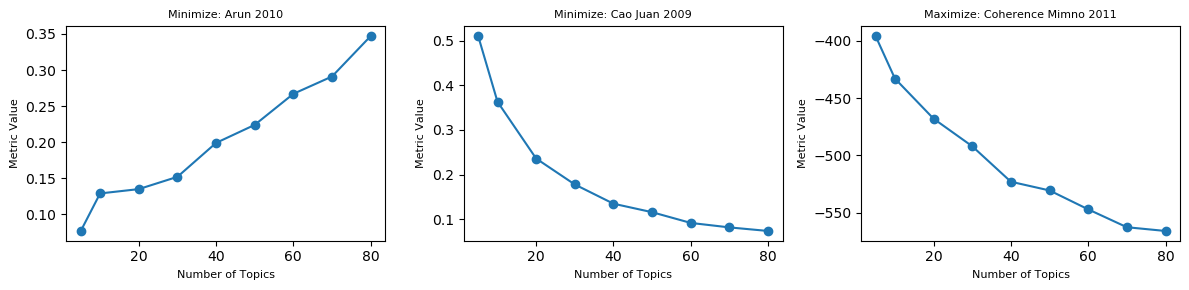

running the evaluation for: eta_0.06__alpha_00.3
[.] constant parameters: {'n_iter': 500, 'eta': 0.06, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.3}, {'n_topics': 10, 'alpha': 0.3}, {'n_topics': 20, 'alpha': 0.3}, {'n_topics': 30, 'alpha': 0.3}, {'n_topics': 40, 'alpha': 0.3}, {'n_topics': 50, 'alpha': 0.3}, {'n_topics': 60, 'alpha': 0.3}, {'n_topics': 70, 'alpha': 0.3}, {'n_topics': 80, 'alpha': 0.3}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.085, 'cao_juan_2009': 0.484, 'coherence_mimno_2011': -403.988}), (10, {'arun_2010': 0.085, 'cao_juan_2009': 0.312, 'coherence_mimno_2011': -447.445}), (20, {'arun_2010': 0.147, 'cao_juan_2009': 0.203, 'coherence_mimno_2011': -485.047}), (30, {'arun_2010': 0.159, 'cao_juan_2009': 0.135, 'coherence_mimno_2011': -519.008}), (40, {'arun_2010': 0.182, 'cao_juan_2009': 0.109, 'c

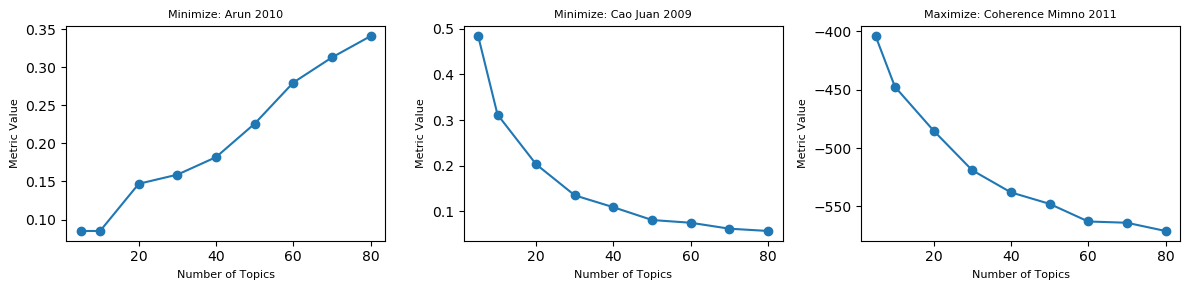

running the evaluation for: eta_0.06__alpha_00.4
[.] constant parameters: {'n_iter': 500, 'eta': 0.06, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.4}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 20, 'alpha': 0.4}, {'n_topics': 30, 'alpha': 0.4}, {'n_topics': 40, 'alpha': 0.4}, {'n_topics': 50, 'alpha': 0.4}, {'n_topics': 60, 'alpha': 0.4}, {'n_topics': 70, 'alpha': 0.4}, {'n_topics': 80, 'alpha': 0.4}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.086, 'cao_juan_2009': 0.454, 'coherence_mimno_2011': -406.642}), (10, {'arun_2010': 0.095, 'cao_juan_2009': 0.266, 'coherence_mimno_2011': -452.728}), (20, {'arun_2010': 0.148, 'cao_juan_2009': 0.176, 'coherence_mimno_2011': -508.533}), (30, {'arun_2010': 0.165, 'cao_juan_2009': 0.111, 'coherence_mimno_2011': -537.449}), (40, {'arun_2010': 0.209, 'cao_juan_2009': 0.084, 'c

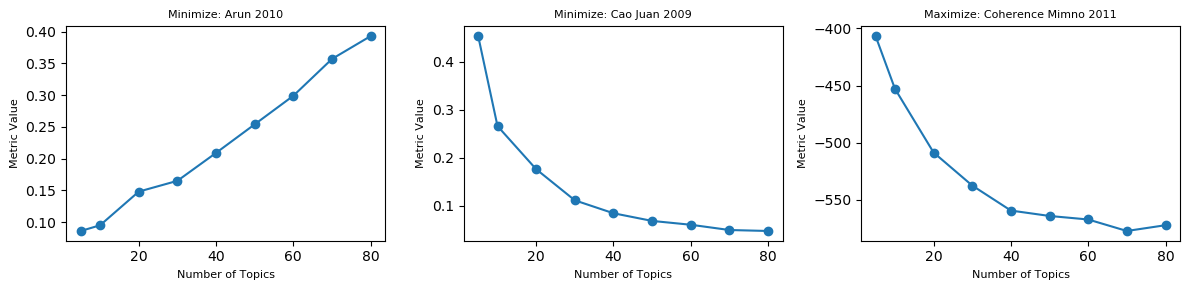

running the evaluation for: eta_0.06__alpha_00.5
[.] constant parameters: {'n_iter': 500, 'eta': 0.06, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.5}, {'n_topics': 10, 'alpha': 0.5}, {'n_topics': 20, 'alpha': 0.5}, {'n_topics': 30, 'alpha': 0.5}, {'n_topics': 40, 'alpha': 0.5}, {'n_topics': 50, 'alpha': 0.5}, {'n_topics': 60, 'alpha': 0.5}, {'n_topics': 70, 'alpha': 0.5}, {'n_topics': 80, 'alpha': 0.5}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.079, 'cao_juan_2009': 0.422, 'coherence_mimno_2011': -408.647}), (10, {'arun_2010': 0.1, 'cao_juan_2009': 0.256, 'coherence_mimno_2011': -467.396}), (20, {'arun_2010': 0.133, 'cao_juan_2009': 0.15, 'coherence_mimno_2011': -512.692}), (30, {'arun_2010': 0.163, 'cao_juan_2009': 0.094, 'coherence_mimno_2011': -538.177}), (40, {'arun_2010': 0.227, 'cao_juan_2009': 0.07, 'coher

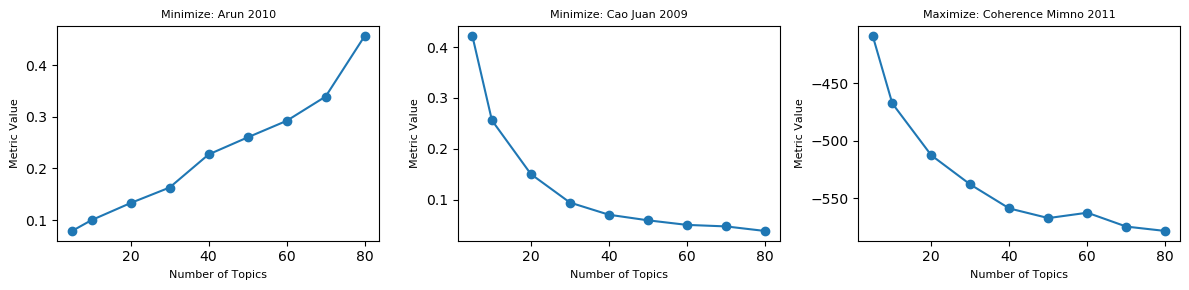

running the evaluation for: eta_0.06__alpha_00.6
[.] constant parameters: {'n_iter': 500, 'eta': 0.06, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.6}, {'n_topics': 10, 'alpha': 0.6}, {'n_topics': 20, 'alpha': 0.6}, {'n_topics': 30, 'alpha': 0.6}, {'n_topics': 40, 'alpha': 0.6}, {'n_topics': 50, 'alpha': 0.6}, {'n_topics': 60, 'alpha': 0.6}, {'n_topics': 70, 'alpha': 0.6}, {'n_topics': 80, 'alpha': 0.6}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.084, 'cao_juan_2009': 0.378, 'coherence_mimno_2011': -432.101}), (10, {'arun_2010': 0.101, 'cao_juan_2009': 0.254, 'coherence_mimno_2011': -468.805}), (20, {'arun_2010': 0.139, 'cao_juan_2009': 0.125, 'coherence_mimno_2011': -526.339}), (30, {'arun_2010': 0.198, 'cao_juan_2009': 0.088, 'coherence_mimno_2011': -546.121}), (40, {'arun_2010': 0.211, 'cao_juan_2009': 0.06, 'co

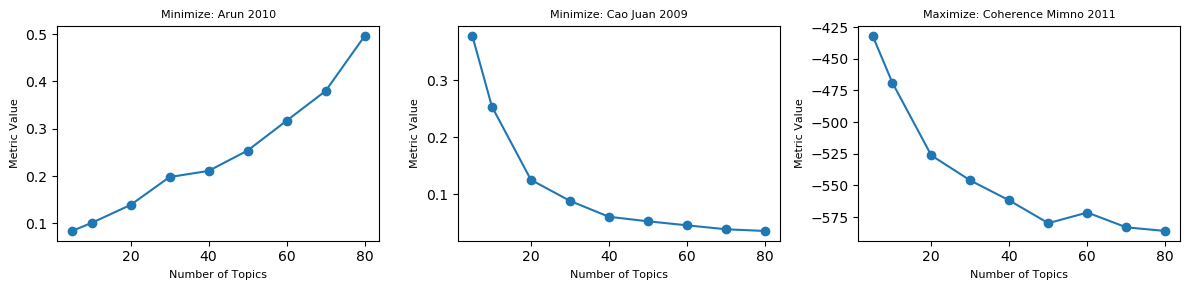

running the evaluation for: eta_0.06__alpha_00.7
[.] constant parameters: {'n_iter': 500, 'eta': 0.06, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.7}, {'n_topics': 10, 'alpha': 0.7}, {'n_topics': 20, 'alpha': 0.7}, {'n_topics': 30, 'alpha': 0.7}, {'n_topics': 40, 'alpha': 0.7}, {'n_topics': 50, 'alpha': 0.7}, {'n_topics': 60, 'alpha': 0.7}, {'n_topics': 70, 'alpha': 0.7}, {'n_topics': 80, 'alpha': 0.7}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.083, 'cao_juan_2009': 0.361, 'coherence_mimno_2011': -424.77}), (10, {'arun_2010': 0.083, 'cao_juan_2009': 0.219, 'coherence_mimno_2011': -477.786}), (20, {'arun_2010': 0.14, 'cao_juan_2009': 0.114, 'coherence_mimno_2011': -534.498}), (30, {'arun_2010': 0.177, 'cao_juan_2009': 0.067, 'coherence_mimno_2011': -567.632}), (40, {'arun_2010': 0.257, 'cao_juan_2009': 0.047, 'coh

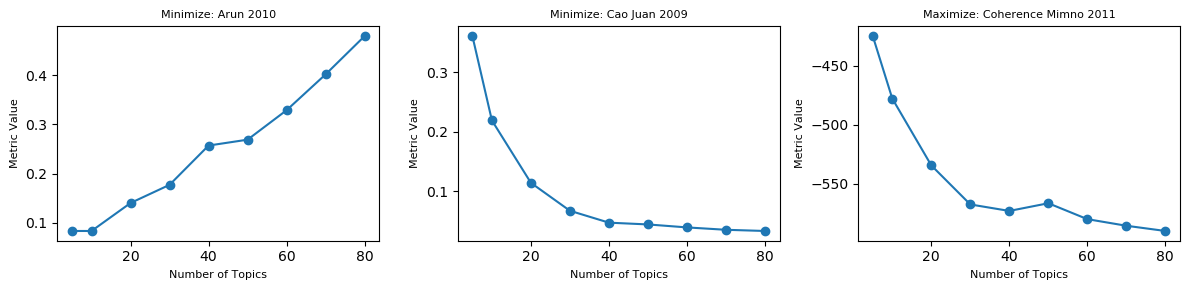

running the evaluation for: eta_0.06__alpha_00.8
[.] constant parameters: {'n_iter': 500, 'eta': 0.06, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.8}, {'n_topics': 20, 'alpha': 0.8}, {'n_topics': 30, 'alpha': 0.8}, {'n_topics': 40, 'alpha': 0.8}, {'n_topics': 50, 'alpha': 0.8}, {'n_topics': 60, 'alpha': 0.8}, {'n_topics': 70, 'alpha': 0.8}, {'n_topics': 80, 'alpha': 0.8}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.082, 'cao_juan_2009': 0.347, 'coherence_mimno_2011': -434.235}), (10, {'arun_2010': 0.085, 'cao_juan_2009': 0.2, 'coherence_mimno_2011': -481.253}), (20, {'arun_2010': 0.171, 'cao_juan_2009': 0.102, 'coherence_mimno_2011': -545.442}), (30, {'arun_2010': 0.194, 'cao_juan_2009': 0.061, 'coherence_mimno_2011': -558.862}), (40, {'arun_2010': 0.228, 'cao_juan_2009': 0.047, 'coh

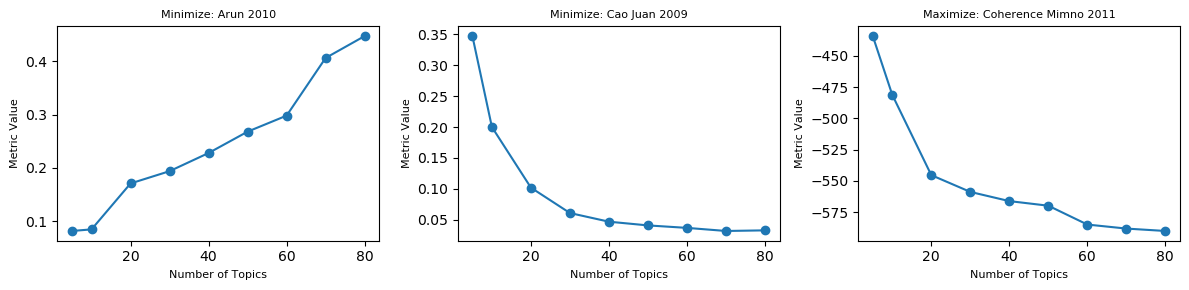

running the evaluation for: eta_0.06__alpha_00.9
[.] constant parameters: {'n_iter': 500, 'eta': 0.06, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.9}, {'n_topics': 10, 'alpha': 0.9}, {'n_topics': 20, 'alpha': 0.9}, {'n_topics': 30, 'alpha': 0.9}, {'n_topics': 40, 'alpha': 0.9}, {'n_topics': 50, 'alpha': 0.9}, {'n_topics': 60, 'alpha': 0.9}, {'n_topics': 70, 'alpha': 0.9}, {'n_topics': 80, 'alpha': 0.9}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.081, 'cao_juan_2009': 0.335, 'coherence_mimno_2011': -423.288}), (10, {'arun_2010': 0.086, 'cao_juan_2009': 0.174, 'coherence_mimno_2011': -498.372}), (20, {'arun_2010': 0.157, 'cao_juan_2009': 0.089, 'coherence_mimno_2011': -548.044}), (30, {'arun_2010': 0.23, 'cao_juan_2009': 0.055, 'coherence_mimno_2011': -563.673}), (40, {'arun_2010': 0.242, 'cao_juan_2009': 0.048, 'co

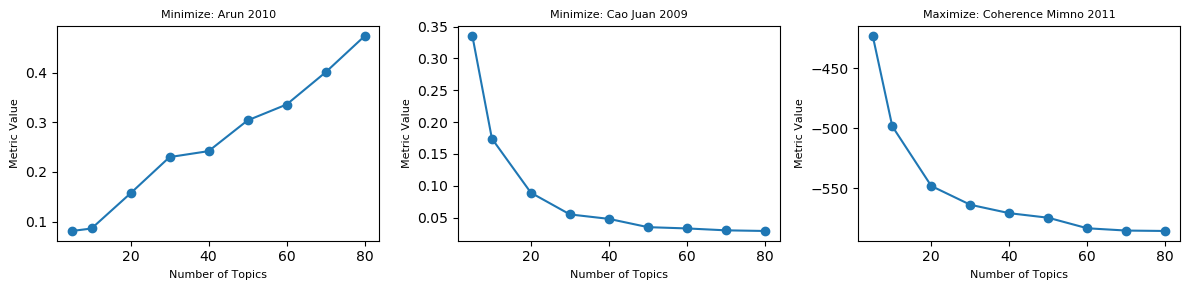

running the evaluation for: eta_0.06__alpha_01.0
[.] constant parameters: {'n_iter': 500, 'eta': 0.06, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 1.0}, {'n_topics': 10, 'alpha': 1.0}, {'n_topics': 20, 'alpha': 1.0}, {'n_topics': 30, 'alpha': 1.0}, {'n_topics': 40, 'alpha': 1.0}, {'n_topics': 50, 'alpha': 1.0}, {'n_topics': 60, 'alpha': 1.0}, {'n_topics': 70, 'alpha': 1.0}, {'n_topics': 80, 'alpha': 1.0}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.053, 'cao_juan_2009': 0.276, 'coherence_mimno_2011': -419.762}), (10, {'arun_2010': 0.096, 'cao_juan_2009': 0.188, 'coherence_mimno_2011': -490.983}), (20, {'arun_2010': 0.161, 'cao_juan_2009': 0.072, 'coherence_mimno_2011': -549.297}), (30, {'arun_2010': 0.175, 'cao_juan_2009': 0.058, 'coherence_mimno_2011': -569.616}), (40, {'arun_2010': 0.225, 'cao_juan_2009': 0.04, 'co

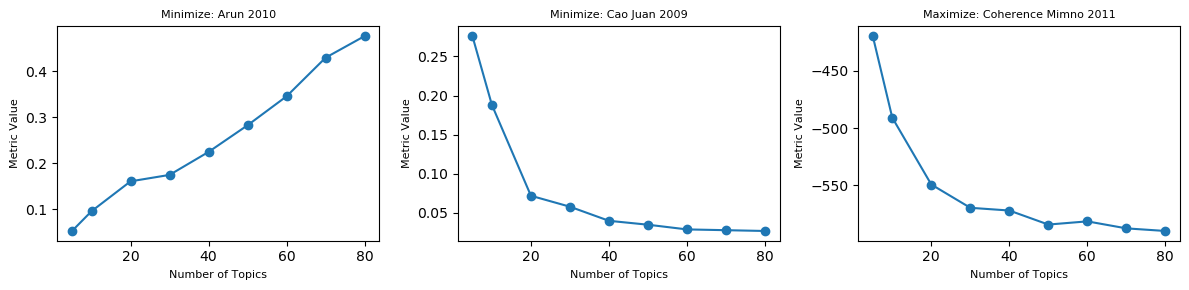

running the evaluation for: eta_0.05__alpha_00.1
[.] constant parameters: {'n_iter': 500, 'eta': 0.05, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.1}, {'n_topics': 10, 'alpha': 0.1}, {'n_topics': 20, 'alpha': 0.1}, {'n_topics': 30, 'alpha': 0.1}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.1}, {'n_topics': 60, 'alpha': 0.1}, {'n_topics': 70, 'alpha': 0.1}, {'n_topics': 80, 'alpha': 0.1}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.093, 'cao_juan_2009': 0.569, 'coherence_mimno_2011': -390.464}), (10, {'arun_2010': 0.118, 'cao_juan_2009': 0.446, 'coherence_mimno_2011': -419.499}), (20, {'arun_2010': 0.177, 'cao_juan_2009': 0.323, 'coherence_mimno_2011': -436.049}), (30, {'arun_2010': 0.169, 'cao_juan_2009': 0.245, 'coherence_mimno_2011': -456.87}), (40, {'arun_2010': 0.185, 'cao_juan_2009': 0.203, 'co

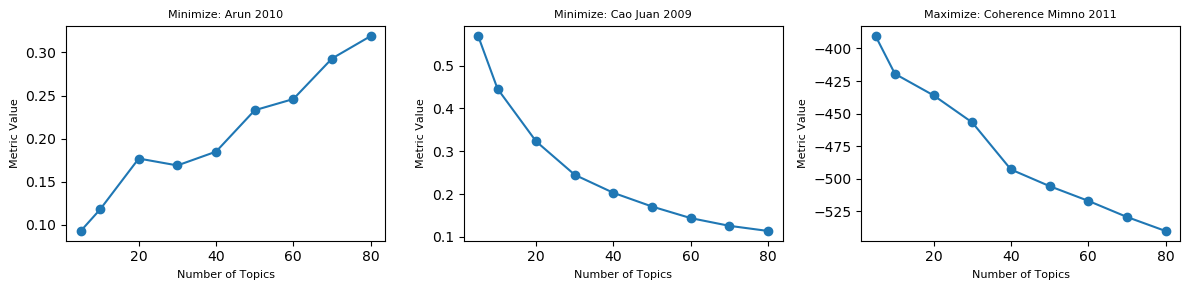

running the evaluation for: eta_0.05__alpha_00.2
[.] constant parameters: {'n_iter': 500, 'eta': 0.05, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.2}, {'n_topics': 10, 'alpha': 0.2}, {'n_topics': 20, 'alpha': 0.2}, {'n_topics': 30, 'alpha': 0.2}, {'n_topics': 40, 'alpha': 0.2}, {'n_topics': 50, 'alpha': 0.2}, {'n_topics': 60, 'alpha': 0.2}, {'n_topics': 70, 'alpha': 0.2}, {'n_topics': 80, 'alpha': 0.2}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.078, 'cao_juan_2009': 0.504, 'coherence_mimno_2011': -391.668}), (10, {'arun_2010': 0.098, 'cao_juan_2009': 0.352, 'coherence_mimno_2011': -434.087}), (20, {'arun_2010': 0.143, 'cao_juan_2009': 0.247, 'coherence_mimno_2011': -464.413}), (30, {'arun_2010': 0.153, 'cao_juan_2009': 0.173, 'coherence_mimno_2011': -498.721}), (40, {'arun_2010': 0.18, 'cao_juan_2009': 0.139, 'co

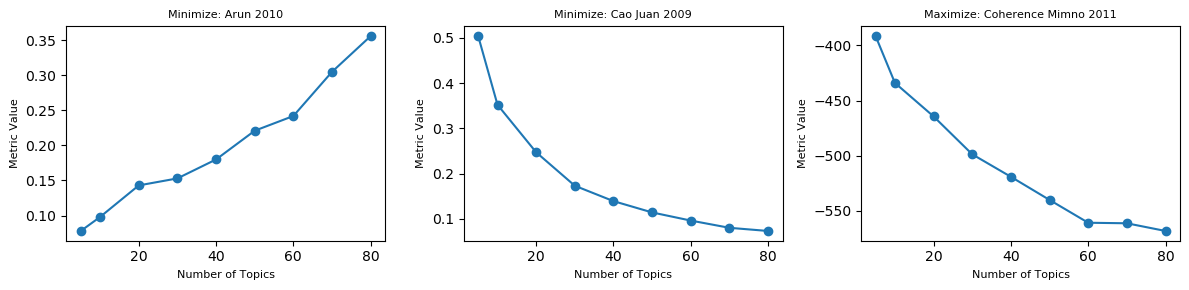

running the evaluation for: eta_0.05__alpha_00.3
[.] constant parameters: {'n_iter': 500, 'eta': 0.05, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.3}, {'n_topics': 10, 'alpha': 0.3}, {'n_topics': 20, 'alpha': 0.3}, {'n_topics': 30, 'alpha': 0.3}, {'n_topics': 40, 'alpha': 0.3}, {'n_topics': 50, 'alpha': 0.3}, {'n_topics': 60, 'alpha': 0.3}, {'n_topics': 70, 'alpha': 0.3}, {'n_topics': 80, 'alpha': 0.3}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.089, 'cao_juan_2009': 0.486, 'coherence_mimno_2011': -406.847}), (10, {'arun_2010': 0.098, 'cao_juan_2009': 0.315, 'coherence_mimno_2011': -444.037}), (20, {'arun_2010': 0.132, 'cao_juan_2009': 0.202, 'coherence_mimno_2011': -491.082}), (30, {'arun_2010': 0.163, 'cao_juan_2009': 0.136, 'coherence_mimno_2011': -513.969}), (40, {'arun_2010': 0.183, 'cao_juan_2009': 0.102, 'c

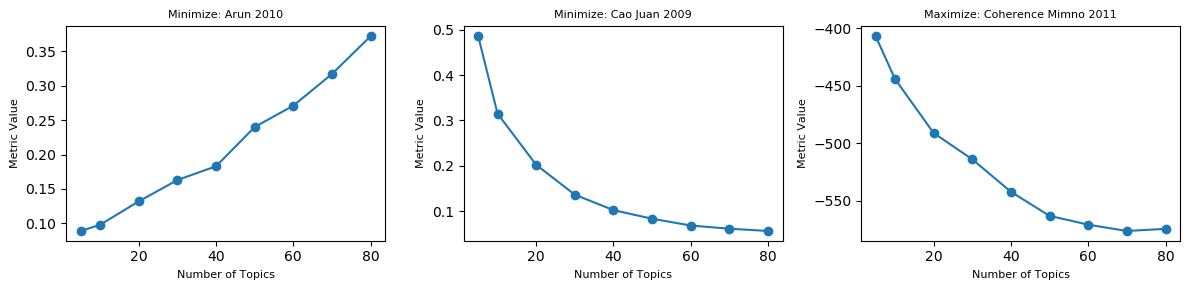

running the evaluation for: eta_0.05__alpha_00.4
[.] constant parameters: {'n_iter': 500, 'eta': 0.05, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.4}, {'n_topics': 10, 'alpha': 0.4}, {'n_topics': 20, 'alpha': 0.4}, {'n_topics': 30, 'alpha': 0.4}, {'n_topics': 40, 'alpha': 0.4}, {'n_topics': 50, 'alpha': 0.4}, {'n_topics': 60, 'alpha': 0.4}, {'n_topics': 70, 'alpha': 0.4}, {'n_topics': 80, 'alpha': 0.4}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.081, 'cao_juan_2009': 0.435, 'coherence_mimno_2011': -409.343}), (10, {'arun_2010': 0.105, 'cao_juan_2009': 0.282, 'coherence_mimno_2011': -455.67}), (20, {'arun_2010': 0.136, 'cao_juan_2009': 0.171, 'coherence_mimno_2011': -501.453}), (30, {'arun_2010': 0.174, 'cao_juan_2009': 0.11, 'coherence_mimno_2011': -533.816}), (40, {'arun_2010': 0.186, 'cao_juan_2009': 0.086, 'coh

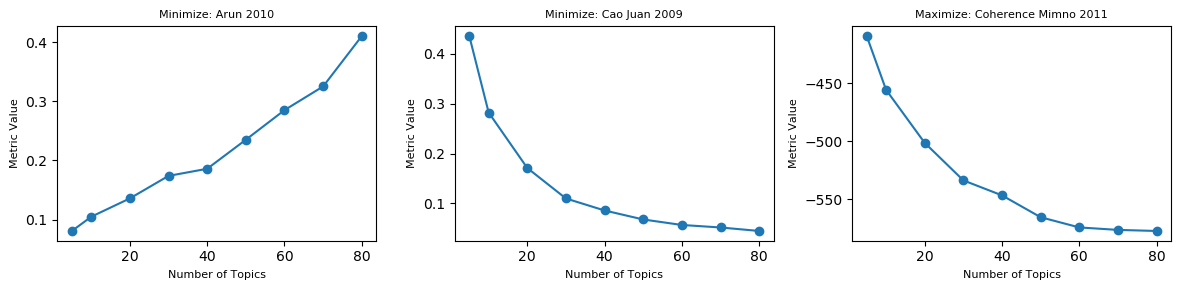

running the evaluation for: eta_0.05__alpha_00.5
[.] constant parameters: {'n_iter': 500, 'eta': 0.05, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.5}, {'n_topics': 10, 'alpha': 0.5}, {'n_topics': 20, 'alpha': 0.5}, {'n_topics': 30, 'alpha': 0.5}, {'n_topics': 40, 'alpha': 0.5}, {'n_topics': 50, 'alpha': 0.5}, {'n_topics': 60, 'alpha': 0.5}, {'n_topics': 70, 'alpha': 0.5}, {'n_topics': 80, 'alpha': 0.5}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.079, 'cao_juan_2009': 0.42, 'coherence_mimno_2011': -409.152}), (10, {'arun_2010': 0.091, 'cao_juan_2009': 0.268, 'coherence_mimno_2011': -473.892}), (20, {'arun_2010': 0.147, 'cao_juan_2009': 0.142, 'coherence_mimno_2011': -512.211}), (30, {'arun_2010': 0.169, 'cao_juan_2009': 0.091, 'coherence_mimno_2011': -557.193}), (40, {'arun_2010': 0.215, 'cao_juan_2009': 0.068, 'co

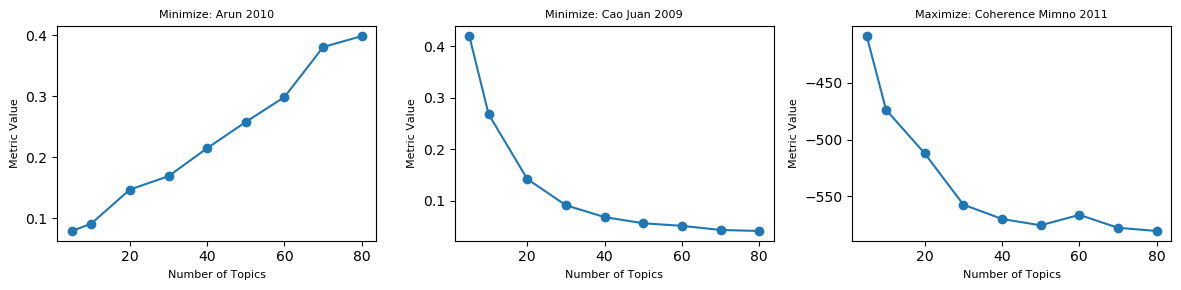

running the evaluation for: eta_0.05__alpha_00.6
[.] constant parameters: {'n_iter': 500, 'eta': 0.05, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.6}, {'n_topics': 10, 'alpha': 0.6}, {'n_topics': 20, 'alpha': 0.6}, {'n_topics': 30, 'alpha': 0.6}, {'n_topics': 40, 'alpha': 0.6}, {'n_topics': 50, 'alpha': 0.6}, {'n_topics': 60, 'alpha': 0.6}, {'n_topics': 70, 'alpha': 0.6}, {'n_topics': 80, 'alpha': 0.6}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.086, 'cao_juan_2009': 0.377, 'coherence_mimno_2011': -432.238}), (10, {'arun_2010': 0.081, 'cao_juan_2009': 0.236, 'coherence_mimno_2011': -469.364}), (20, {'arun_2010': 0.156, 'cao_juan_2009': 0.127, 'coherence_mimno_2011': -531.125}), (30, {'arun_2010': 0.2, 'cao_juan_2009': 0.075, 'coherence_mimno_2011': -548.807}), (40, {'arun_2010': 0.246, 'cao_juan_2009': 0.056, 'coh

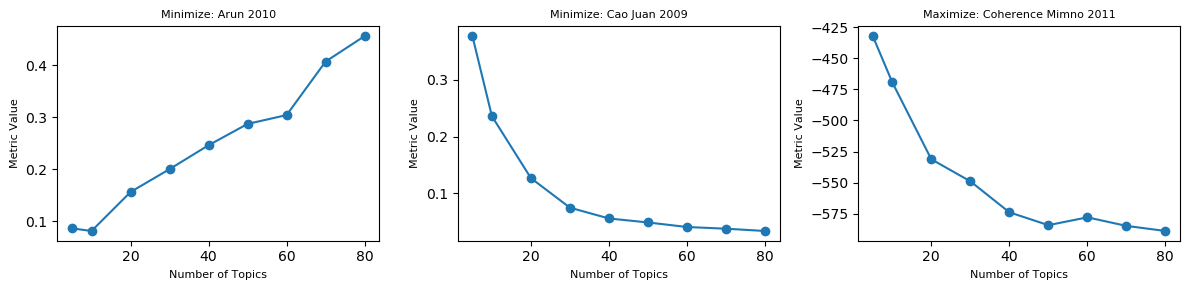

running the evaluation for: eta_0.05__alpha_00.7
[.] constant parameters: {'n_iter': 500, 'eta': 0.05, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.7}, {'n_topics': 10, 'alpha': 0.7}, {'n_topics': 20, 'alpha': 0.7}, {'n_topics': 30, 'alpha': 0.7}, {'n_topics': 40, 'alpha': 0.7}, {'n_topics': 50, 'alpha': 0.7}, {'n_topics': 60, 'alpha': 0.7}, {'n_topics': 70, 'alpha': 0.7}, {'n_topics': 80, 'alpha': 0.7}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.076, 'cao_juan_2009': 0.383, 'coherence_mimno_2011': -417.184}), (10, {'arun_2010': 0.075, 'cao_juan_2009': 0.22, 'coherence_mimno_2011': -485.196}), (20, {'arun_2010': 0.143, 'cao_juan_2009': 0.117, 'coherence_mimno_2011': -533.155}), (30, {'arun_2010': 0.204, 'cao_juan_2009': 0.065, 'coherence_mimno_2011': -565.678}), (40, {'arun_2010': 0.229, 'cao_juan_2009': 0.055, 'co

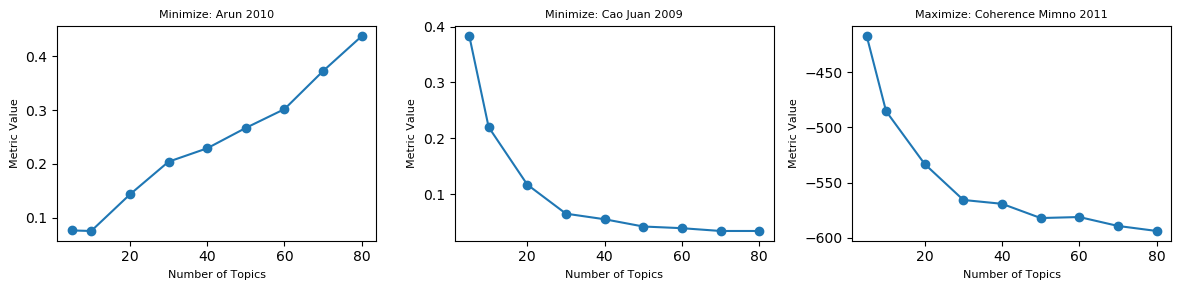

running the evaluation for: eta_0.05__alpha_00.8
[.] constant parameters: {'n_iter': 500, 'eta': 0.05, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.8}, {'n_topics': 10, 'alpha': 0.8}, {'n_topics': 20, 'alpha': 0.8}, {'n_topics': 30, 'alpha': 0.8}, {'n_topics': 40, 'alpha': 0.8}, {'n_topics': 50, 'alpha': 0.8}, {'n_topics': 60, 'alpha': 0.8}, {'n_topics': 70, 'alpha': 0.8}, {'n_topics': 80, 'alpha': 0.8}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.083, 'cao_juan_2009': 0.342, 'coherence_mimno_2011': -422.236}), (10, {'arun_2010': 0.084, 'cao_juan_2009': 0.21, 'coherence_mimno_2011': -478.533}), (20, {'arun_2010': 0.128, 'cao_juan_2009': 0.094, 'coherence_mimno_2011': -548.022}), (30, {'arun_2010': 0.167, 'cao_juan_2009': 0.064, 'coherence_mimno_2011': -558.255}), (40, {'arun_2010': 0.231, 'cao_juan_2009': 0.046, 'co

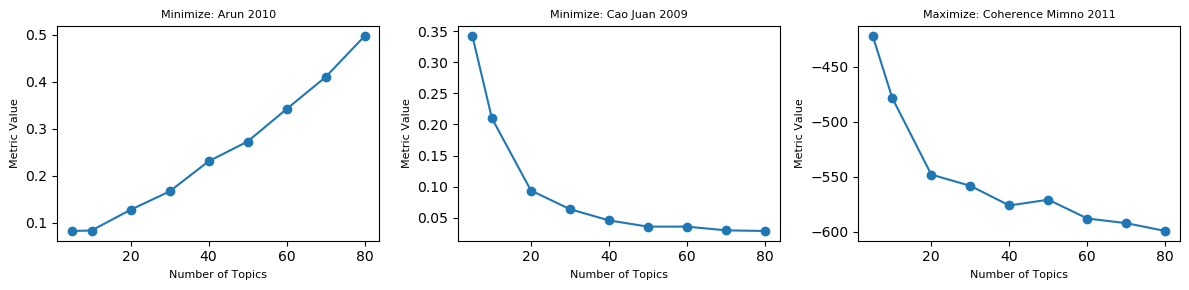

running the evaluation for: eta_0.05__alpha_00.9
[.] constant parameters: {'n_iter': 500, 'eta': 0.05, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.9}, {'n_topics': 10, 'alpha': 0.9}, {'n_topics': 20, 'alpha': 0.9}, {'n_topics': 30, 'alpha': 0.9}, {'n_topics': 40, 'alpha': 0.9}, {'n_topics': 50, 'alpha': 0.9}, {'n_topics': 60, 'alpha': 0.9}, {'n_topics': 70, 'alpha': 0.9}, {'n_topics': 80, 'alpha': 0.9}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.084, 'cao_juan_2009': 0.334, 'coherence_mimno_2011': -424.381}), (10, {'arun_2010': 0.078, 'cao_juan_2009': 0.173, 'coherence_mimno_2011': -497.506}), (20, {'arun_2010': 0.13, 'cao_juan_2009': 0.12, 'coherence_mimno_2011': -543.394}), (30, {'arun_2010': 0.199, 'cao_juan_2009': 0.054, 'coherence_mimno_2011': -559.479}), (40, {'arun_2010': 0.247, 'cao_juan_2009': 0.041, 'coh

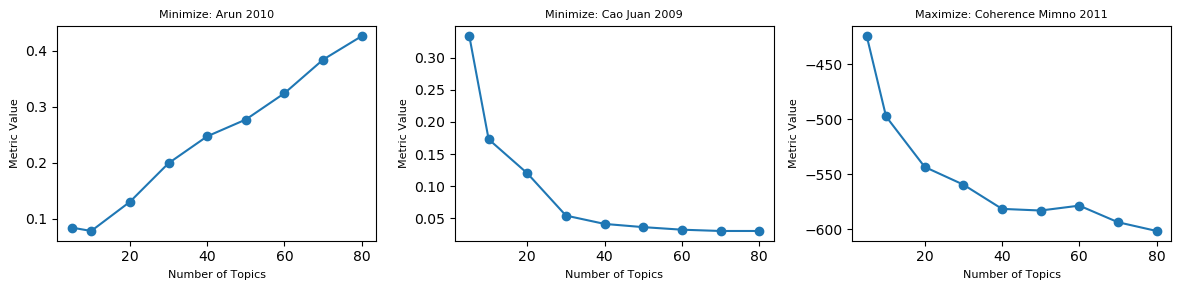

running the evaluation for: eta_0.05__alpha_01.0
[.] constant parameters: {'n_iter': 500, 'eta': 0.05, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 1.0}, {'n_topics': 10, 'alpha': 1.0}, {'n_topics': 20, 'alpha': 1.0}, {'n_topics': 30, 'alpha': 1.0}, {'n_topics': 40, 'alpha': 1.0}, {'n_topics': 50, 'alpha': 1.0}, {'n_topics': 60, 'alpha': 1.0}, {'n_topics': 70, 'alpha': 1.0}, {'n_topics': 80, 'alpha': 1.0}]
[.] number of results calculated: 9
[.] results by n topic models: [(5, {'arun_2010': 0.053, 'cao_juan_2009': 0.268, 'coherence_mimno_2011': -434.159}), (10, {'arun_2010': 0.097, 'cao_juan_2009': 0.182, 'coherence_mimno_2011': -496.443}), (20, {'arun_2010': 0.172, 'cao_juan_2009': 0.074, 'coherence_mimno_2011': -554.734}), (30, {'arun_2010': 0.194, 'cao_juan_2009': 0.057, 'coherence_mimno_2011': -569.98}), (40, {'arun_2010': 0.218, 'cao_juan_2009': 0.042, 'co

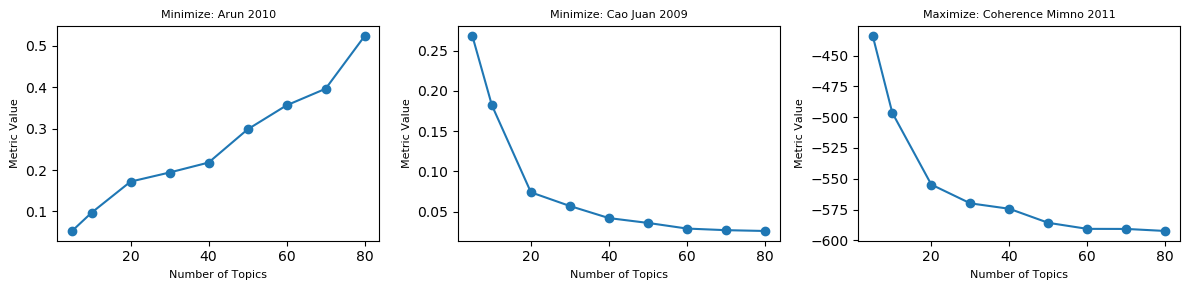

running the evaluation for: eta_0.04__alpha_00.1
[.] constant parameters: {'n_iter': 500, 'eta': 0.04, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 9
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.1}, {'n_topics': 10, 'alpha': 0.1}, {'n_topics': 20, 'alpha': 0.1}, {'n_topics': 30, 'alpha': 0.1}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.1}, {'n_topics': 60, 'alpha': 0.1}, {'n_topics': 70, 'alpha': 0.1}, {'n_topics': 80, 'alpha': 0.1}]


In [ ]:
#define the input parameters
eta_list = [0.10,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01]
alpha_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kmax = 80
# run the function
all_model_runs = automate_test_fixed_model(dtm_p = dtm_main,
                                           eta_list = eta_list,
                                           alpha_list = alpha_list,
                                           kmax = kmax)

In [ ]:
#define the input parameters
eta_list = [0.01]
alpha_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kmax = 60
# run the function
all_model_runs = automate_test_fixed_model(dtm_p = dtm_main,
                                           eta_list = eta_list,
                                           alpha_list = alpha_list,
                                           kmax = kmax,
                                           output_file = 'explore_eval_fixed_eta_001.p')

running the evaluation for: eta_0.01__alpha_00.1
[.] constant parameters: {'n_iter': 500, 'eta': 0.01, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 15, 20, 30, 40, 50, 60]
[.] number of trials: 8
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.1}, {'n_topics': 10, 'alpha': 0.1}, {'n_topics': 15, 'alpha': 0.1}, {'n_topics': 20, 'alpha': 0.1}, {'n_topics': 30, 'alpha': 0.1}, {'n_topics': 40, 'alpha': 0.1}, {'n_topics': 50, 'alpha': 0.1}, {'n_topics': 60, 'alpha': 0.1}]


In [226]:
def load_model_evaluations(DATA_DIR, path_location):
  #location of model evaluation file files
  eval_file_path = '%s/%s' % (DATA_DIR, path_location)
  #load the corpus
  all_model_runs = pickle.load(open(eval_file_path, 'rb'))
  #preview the document labels
  print(all_model_runs['eta_0.100__alpha_0.100'])
  # return the model data
  return all_model_runs

all_model_runs = load_model_evaluations(DATA_DIR = DATA_DIR, path_location = 'explore_eval_fixed_eta_001.p')

FileNotFoundError: ignored

In [ ]:
all_model_runs.keys()

In [ ]:
plot_eval_results_custom(all_model_runs['eta_0.100__alpha_0.100'])

In [ ]:
def print_model_evaluations(all_model_runs, limit = 1000):
  count = 0
  key_list = list(all_model_runs.keys())
  for key in key_list:
    plot_eval_results_custom(all_model_runs[key])
    count += 1
    if count >= limit:
      break

print_model_evaluations(all_model_runs = all_model_runs, limit = 1)

## Round 3: Strategic Model Options

[.] constant parameters: {'n_iter': 500, 'eta': 0.5, 'random_state': 20191122}
[.] number of topics to try: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 10, 'alpha': 0.03333333333333333}, {'n_topics': 20, 'alpha': 0.03333333333333333}, {'n_topics': 30, 'alpha': 0.03333333333333333}, {'n_topics': 40, 'alpha': 0.03333333333333333}, {'n_topics': 50, 'alpha': 0.03333333333333333}, {'n_topics': 60, 'alpha': 0.03333333333333333}, {'n_topics': 70, 'alpha': 0.03333333333333333}, {'n_topics': 80, 'alpha': 0.03333333333333333}, {'n_topics': 90, 'alpha': 0.03333333333333333}, {'n_topics': 100, 'alpha': 0.03333333333333333}]
[.] number of results calculated: 10
[.] results by n topic models: [(10, {'arun_2010': 0.204, 'cao_juan_2009': 0.542, 'coherence_mimno_2011': -394.998}), (20, {'arun_2010': 0.257, 'cao_juan_2009': 0.453, 'coherence_mimno_2011': -409.121}), (30, {'arun_2010': 0.222, 'cao_juan_2009': 0.383, 'coherence_mimno_2011

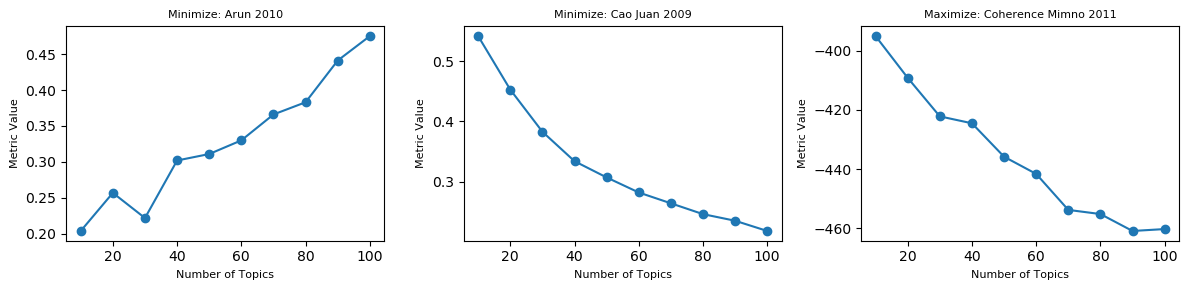

In [16]:
# run calculations and vizualize
varying_params, const_params = build_param_inputs_fixed(kmax = 100, eta_value = .5, alpha_value = 1/30)
results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_main, varying_p = varying_params, const_p = const_params)
plot_eval_results_custom(results_by_n_topics)

[.] constant parameters: {'n_iter': 500, 'eta': 0.01, 'random_state': 20191122}
[.] number of topics to try: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 10, 'alpha': 0.03333333333333333}, {'n_topics': 20, 'alpha': 0.03333333333333333}, {'n_topics': 30, 'alpha': 0.03333333333333333}, {'n_topics': 40, 'alpha': 0.03333333333333333}, {'n_topics': 50, 'alpha': 0.03333333333333333}, {'n_topics': 60, 'alpha': 0.03333333333333333}, {'n_topics': 70, 'alpha': 0.03333333333333333}, {'n_topics': 80, 'alpha': 0.03333333333333333}, {'n_topics': 90, 'alpha': 0.03333333333333333}, {'n_topics': 100, 'alpha': 0.03333333333333333}]
[.] number of results calculated: 10
[.] results by n topic models: [(10, {'arun_2010': 0.219, 'cao_juan_2009': 0.555, 'coherence_mimno_2011': -408.988}), (20, {'arun_2010': 0.252, 'cao_juan_2009': 0.43, 'coherence_mimno_2011': -421.468}), (30, {'arun_2010': 0.198, 'cao_juan_2009': 0.357, 'coherence_mimno_2011

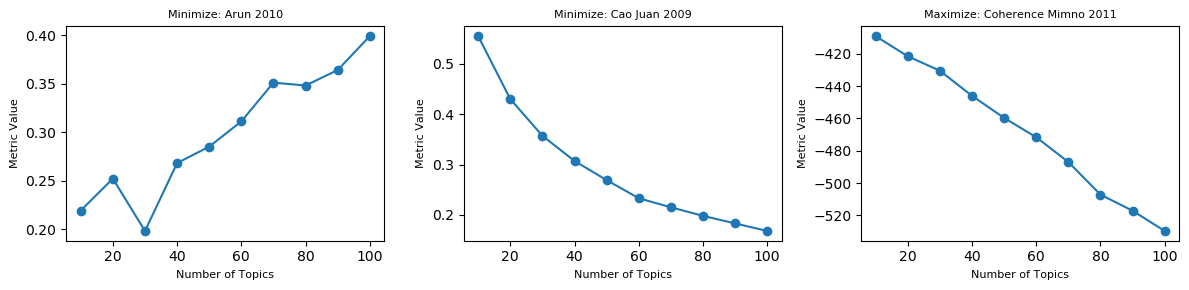

In [17]:
# run calculations and vizualize
varying_params, const_params = build_param_inputs_fixed(kmax = 100, eta_value = .01, alpha_value = 1/30)
results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_main, varying_p = varying_params, const_p = const_params)
plot_eval_results_custom(results_by_n_topics)

[.] constant parameters: {'n_iter': 500, 'eta': 0.01, 'random_state': 20191122}
[.] number of topics to try: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 10, 'alpha': 0.0625}, {'n_topics': 20, 'alpha': 0.0625}, {'n_topics': 30, 'alpha': 0.0625}, {'n_topics': 40, 'alpha': 0.0625}, {'n_topics': 50, 'alpha': 0.0625}, {'n_topics': 60, 'alpha': 0.0625}, {'n_topics': 70, 'alpha': 0.0625}, {'n_topics': 80, 'alpha': 0.0625}, {'n_topics': 90, 'alpha': 0.0625}, {'n_topics': 100, 'alpha': 0.0625}]
[.] number of results calculated: 10
[.] results by n topic models: [(10, {'arun_2010': 0.143, 'cao_juan_2009': 0.487, 'coherence_mimno_2011': -409.267}), (20, {'arun_2010': 0.175, 'cao_juan_2009': 0.37, 'coherence_mimno_2011': -429.614}), (30, {'arun_2010': 0.207, 'cao_juan_2009': 0.287, 'coherence_mimno_2011': -446.24}), (40, {'arun_2010': 0.205, 'cao_juan_2009': 0.239, 'coherence_mimno_2011': -473.913}), (50, {'arun_2010': 0.243, 'cao

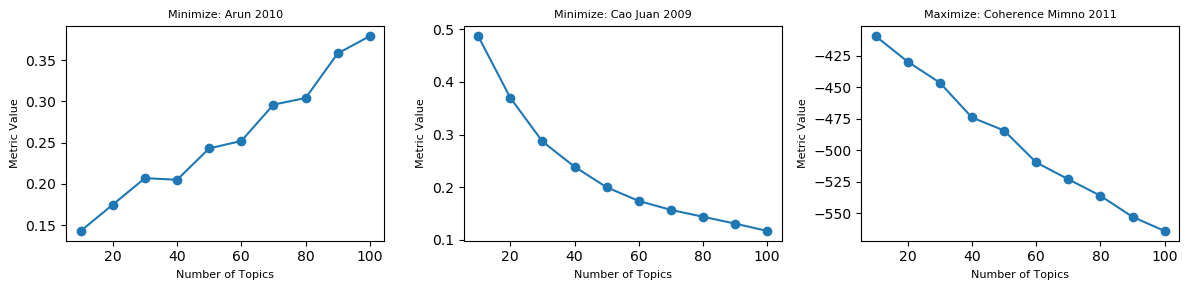

In [18]:
# run calculations and vizualize
varying_params, const_params = build_param_inputs_fixed(kmax = 100, eta_value = .01, alpha_value = 1/16)
results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_main, varying_p = varying_params, const_p = const_params)
plot_eval_results_custom(results_by_n_topics)

[.] constant parameters: {'n_iter': 500, 'eta': 0.01, 'random_state': 20191122}
[.] number of topics to try: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[.] number of trials: 11
[.] variable parameter trials: [{'n_topics': 5, 'alpha': 0.4}, {'n_topics': 10, 'alpha': 0.2}, {'n_topics': 20, 'alpha': 0.1}, {'n_topics': 30, 'alpha': 0.06667}, {'n_topics': 40, 'alpha': 0.05}, {'n_topics': 50, 'alpha': 0.04}, {'n_topics': 60, 'alpha': 0.03333}, {'n_topics': 70, 'alpha': 0.02857}, {'n_topics': 80, 'alpha': 0.025}, {'n_topics': 90, 'alpha': 0.02222}, {'n_topics': 100, 'alpha': 0.02}]
[.] number of results calculated: 11
[.] results by n topic models: [(5, {'arun_2010': 0.094, 'cao_juan_2009': 0.421, 'coherence_mimno_2011': -414.944}), (10, {'arun_2010': 0.117, 'cao_juan_2009': 0.362, 'coherence_mimno_2011': -437.173}), (20, {'arun_2010': 0.149, 'cao_juan_2009': 0.308, 'coherence_mimno_2011': -437.448}), (30, {'arun_2010': 0.185, 'cao_juan_2009': 0.281, 'coherence_mimno_2011': -449.257}), (40,

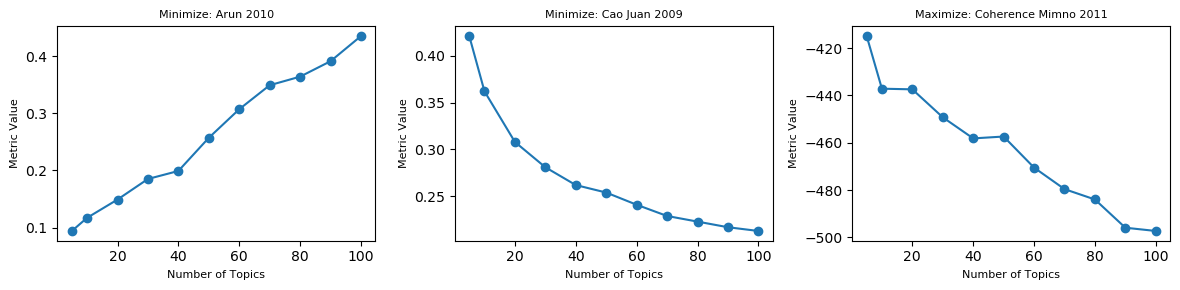

In [20]:
# run calculations and vizualize
varying_params, const_params = build_param_inputs(kmax = 100, eta_factor = 10, alpha_factor = 0.5)
results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_main, varying_p = varying_params, const_p = const_params)
plot_eval_results_custom(results_by_n_topics)

[.] constant parameters: {'n_iter': 500, 'eta': 0.5, 'random_state': 20191122}
[.] number of topics to try: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[.] number of trials: 10
[.] variable parameter trials: [{'n_topics': 10, 'alpha': 0.04}, {'n_topics': 20, 'alpha': 0.04}, {'n_topics': 30, 'alpha': 0.04}, {'n_topics': 40, 'alpha': 0.04}, {'n_topics': 50, 'alpha': 0.04}, {'n_topics': 60, 'alpha': 0.04}, {'n_topics': 70, 'alpha': 0.04}, {'n_topics': 80, 'alpha': 0.04}, {'n_topics': 90, 'alpha': 0.04}, {'n_topics': 100, 'alpha': 0.04}]
[.] number of results calculated: 10
[.] results by n topic models: [(10, {'arun_2010': 0.192, 'cao_juan_2009': 0.538, 'coherence_mimno_2011': -406.024}), (20, {'arun_2010': 0.236, 'cao_juan_2009': 0.437, 'coherence_mimno_2011': -409.251}), (30, {'arun_2010': 0.263, 'cao_juan_2009': 0.361, 'coherence_mimno_2011': -420.894}), (40, {'arun_2010': 0.297, 'cao_juan_2009': 0.323, 'coherence_mimno_2011': -441.509}), (50, {'arun_2010': 0.31, 'cao_juan_2009': 0.285, 

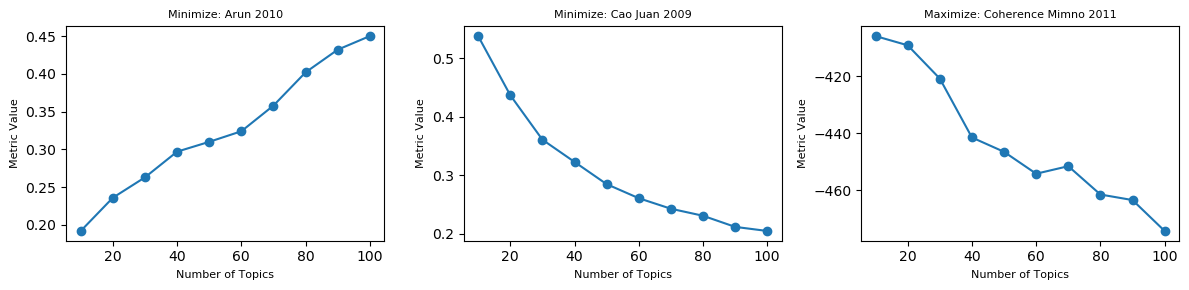

In [25]:
# run calculations and vizualize
varying_params, const_params = build_param_inputs_fixed(kmax = 100, eta_value = .5, alpha_value = 1/25)
results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_main, varying_p = varying_params, const_p = const_params)
plot_eval_results_custom(results_by_n_topics)

[.] constant parameters: {'n_iter': 500, 'eta': 0.6, 'random_state': 20191122}
[.] number of topics to try: [10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 8
[.] variable parameter trials: [{'n_topics': 10, 'alpha': 0.05}, {'n_topics': 20, 'alpha': 0.05}, {'n_topics': 30, 'alpha': 0.05}, {'n_topics': 40, 'alpha': 0.05}, {'n_topics': 50, 'alpha': 0.05}, {'n_topics': 60, 'alpha': 0.05}, {'n_topics': 70, 'alpha': 0.05}, {'n_topics': 80, 'alpha': 0.05}]
[.] number of results calculated: 8
[.] results by n topic models: [(10, {'arun_2010': 0.188, 'cao_juan_2009': 0.511, 'coherence_mimno_2011': -405.232}), (20, {'arun_2010': 0.198, 'cao_juan_2009': 0.416, 'coherence_mimno_2011': -420.794}), (30, {'arun_2010': 0.205, 'cao_juan_2009': 0.347, 'coherence_mimno_2011': -426.862}), (40, {'arun_2010': 0.26, 'cao_juan_2009': 0.301, 'coherence_mimno_2011': -436.402}), (50, {'arun_2010': 0.243, 'cao_juan_2009': 0.273, 'coherence_mimno_2011': -440.929}), (60, {'arun_2010': 0.305, 'cao_juan_2009':

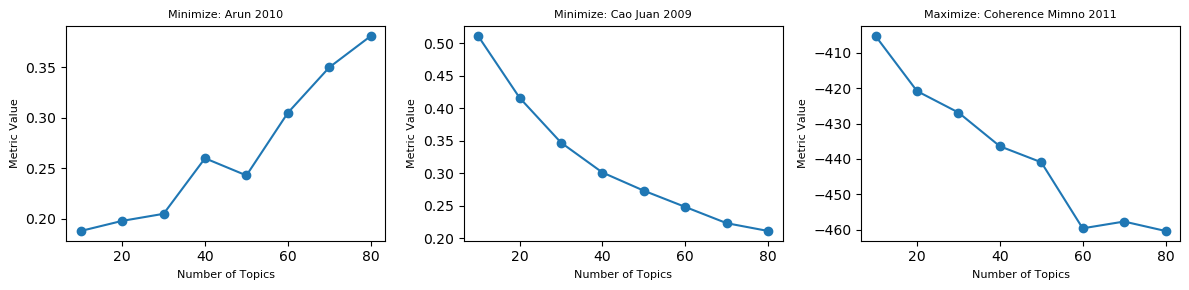

In [26]:
# run calculations and vizualize
varying_params, const_params = build_param_inputs_fixed(kmax = 80, eta_value = .6, alpha_value = 1/20)
results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_main, varying_p = varying_params, const_p = const_params)
plot_eval_results_custom(results_by_n_topics)

[.] constant parameters: {'n_iter': 500, 'eta': 0.7, 'random_state': 20191122}
[.] number of topics to try: [10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 8
[.] variable parameter trials: [{'n_topics': 10, 'alpha': 0.04}, {'n_topics': 20, 'alpha': 0.04}, {'n_topics': 30, 'alpha': 0.04}, {'n_topics': 40, 'alpha': 0.04}, {'n_topics': 50, 'alpha': 0.04}, {'n_topics': 60, 'alpha': 0.04}, {'n_topics': 70, 'alpha': 0.04}, {'n_topics': 80, 'alpha': 0.04}]
[.] number of results calculated: 8
[.] results by n topic models: [(10, {'arun_2010': 0.194, 'cao_juan_2009': 0.547, 'coherence_mimno_2011': -401.279}), (20, {'arun_2010': 0.283, 'cao_juan_2009': 0.439, 'coherence_mimno_2011': -415.848}), (30, {'arun_2010': 0.259, 'cao_juan_2009': 0.367, 'coherence_mimno_2011': -431.0}), (40, {'arun_2010': 0.284, 'cao_juan_2009': 0.325, 'coherence_mimno_2011': -431.973}), (50, {'arun_2010': 0.306, 'cao_juan_2009': 0.299, 'coherence_mimno_2011': -444.895}), (60, {'arun_2010': 0.326, 'cao_juan_2009': 

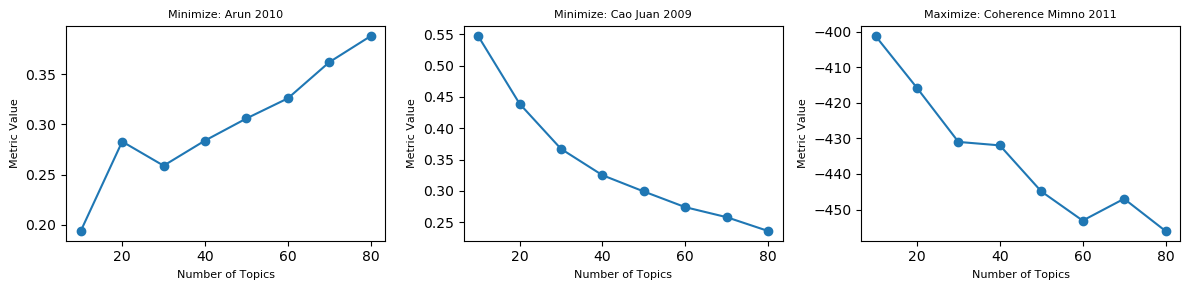

In [27]:
# run calculations and vizualize
varying_params, const_params = build_param_inputs_fixed(kmax = 80, eta_value = .7, alpha_value = 1/25)
results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_main, varying_p = varying_params, const_p = const_params)
plot_eval_results_custom(results_by_n_topics)

[.] constant parameters: {'n_iter': 500, 'eta': 0.8, 'random_state': 20191122}
[.] number of topics to try: [10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 8
[.] variable parameter trials: [{'n_topics': 10, 'alpha': 0.04}, {'n_topics': 20, 'alpha': 0.04}, {'n_topics': 30, 'alpha': 0.04}, {'n_topics': 40, 'alpha': 0.04}, {'n_topics': 50, 'alpha': 0.04}, {'n_topics': 60, 'alpha': 0.04}, {'n_topics': 70, 'alpha': 0.04}, {'n_topics': 80, 'alpha': 0.04}]
[.] number of results calculated: 8
[.] results by n topic models: [(10, {'arun_2010': 0.213, 'cao_juan_2009': 0.544, 'coherence_mimno_2011': -403.243}), (20, {'arun_2010': 0.266, 'cao_juan_2009': 0.434, 'coherence_mimno_2011': -416.087}), (30, {'arun_2010': 0.237, 'cao_juan_2009': 0.365, 'coherence_mimno_2011': -425.721}), (40, {'arun_2010': 0.285, 'cao_juan_2009': 0.326, 'coherence_mimno_2011': -431.809}), (50, {'arun_2010': 0.31, 'cao_juan_2009': 0.294, 'coherence_mimno_2011': -436.595}), (60, {'arun_2010': 0.354, 'cao_juan_2009':

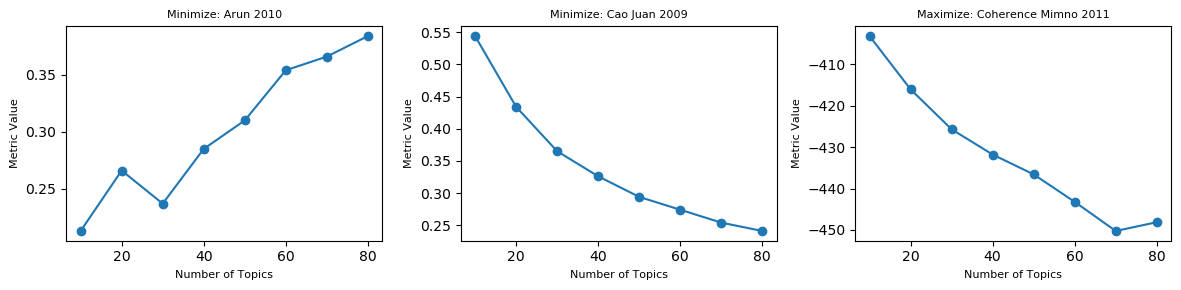

In [28]:
# run calculations and vizualize
varying_params, const_params = build_param_inputs_fixed(kmax = 80, eta_value = .8, alpha_value = 1/25)
results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_main, varying_p = varying_params, const_p = const_params)
plot_eval_results_custom(results_by_n_topics)

[.] constant parameters: {'n_iter': 500, 'eta': 0.7, 'random_state': 20191122}
[.] number of topics to try: [10, 20, 30, 40, 50, 60, 70, 80]
[.] number of trials: 8
[.] variable parameter trials: [{'n_topics': 10, 'alpha': 0.05}, {'n_topics': 20, 'alpha': 0.05}, {'n_topics': 30, 'alpha': 0.05}, {'n_topics': 40, 'alpha': 0.05}, {'n_topics': 50, 'alpha': 0.05}, {'n_topics': 60, 'alpha': 0.05}, {'n_topics': 70, 'alpha': 0.05}, {'n_topics': 80, 'alpha': 0.05}]
[.] number of results calculated: 8
[.] results by n topic models: [(10, {'arun_2010': 0.194, 'cao_juan_2009': 0.516, 'coherence_mimno_2011': -416.07}), (20, {'arun_2010': 0.235, 'cao_juan_2009': 0.422, 'coherence_mimno_2011': -416.431}), (30, {'arun_2010': 0.249, 'cao_juan_2009': 0.341, 'coherence_mimno_2011': -425.809}), (40, {'arun_2010': 0.253, 'cao_juan_2009': 0.303, 'coherence_mimno_2011': -445.935}), (50, {'arun_2010': 0.29, 'cao_juan_2009': 0.274, 'coherence_mimno_2011': -443.386}), (60, {'arun_2010': 0.328, 'cao_juan_2009': 

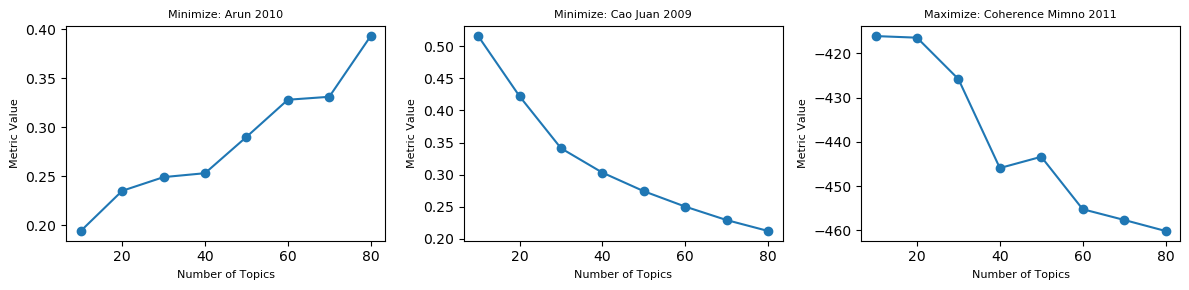

In [30]:
# run calculations and vizualize
varying_params, const_params = build_param_inputs_fixed(kmax = 80, eta_value = .7, alpha_value = 1/20)
results_by_n_topics = evaluate_model_results_custom(dtm_p = dtm_main, varying_p = varying_params, const_p = const_params)
plot_eval_results_custom(results_by_n_topics)

Base on detailed exploration, the following parameters appear to optimze the charts best:
- Number of Topics = 30
- Eta = 0.7
- Alpha = 1/25

# 5.&nbsp;Model: Final

## Import the Corpus

In [31]:
#location of corpus files
corpus_file_path = '%s/corpus.p' % DATA_DIR
doc_labels_file_path = '%s/doc_labels.p' % DATA_DIR
vocab_file_path = '%s/vocab.p' % DATA_DIR
dtm_file_path = '%s/dtm_main.npz' % DATA_DIR

#load the corpus
corpus = pickle.load(open(corpus_file_path, 'rb'))
doc_labels_main = pickle.load(open(doc_labels_file_path, 'rb'))
dtm_main = scipy.sparse.load_npz(dtm_file_path)
vocab_main = pickle.load(open(vocab_file_path, 'rb'))

## Create the Model

In [192]:
# set data to use
dtms = {
    'main': dtm_main
}

# and fixed hyperparameters
# Here, alpha represents document-topic density - with a higher alpha, documents
# are made up of more topics, and with lower alpha, documents contain fewer topics.
#Beta represents topic-word density - with a high beta, topics are made up of
#most of the words in the corpus, and with a low beta they consist of few words.
# https://www.thoughtvector.io/blog/lda-alpha-and-beta-parameters-the-intuition/
lda_params = {
    'n_topics': 15,
    'eta': .01,
    'n_iter': 1000,
    'random_state': 20191122,  # to make results reproducible
    'alpha': 1/16
}

In [193]:
#create the model
models = compute_models_parallel(dtms, constant_parameters=lda_params)

In [194]:
#preview the model
model_main = models['main'][0][1]
print_ldamodel_topic_words(model_main.topic_word_, vocab, top_n=3)

topic_1
> #1. sock (0.084001)
> #2. shoe (0.054434)
> #3. good (0.047320)
topic_2
> #1. great (0.059688)
> #2. shoe (0.054148)
> #3. fit (0.042210)
topic_3
> #1. shoe (0.117739)
> #2. foot (0.078975)
> #3. toe (0.030248)
topic_4
> #1. watch (0.145585)
> #2. time (0.036174)
> #3. nike (0.025584)
topic_5
> #1. shoe (0.140547)
> #2. run (0.075344)
> #3. foot (0.033567)
topic_6
> #1. bag (0.057728)
> #2. fit (0.047255)
> #3. shirt (0.035777)
topic_7
> #1. shoe (0.112898)
> #2. nike (0.069128)
> #3. pair (0.068323)
topic_8
> #1. good (0.099304)
> #2. great (0.067334)
> #3. shoe (0.062960)
topic_9
> #1. color (0.088700)
> #2. shoe (0.051419)
> #3. love (0.046791)
topic_10
> #1. shoe (0.129012)
> #2. love (0.069763)
> #3. great (0.062430)
topic_11
> #1. love (0.100581)
> #2. son (0.075724)
> #3. buy (0.055839)
topic_12
> #1. wear (0.080384)
> #2. foot (0.066913)
> #3. comfortable (0.053946)
topic_13
> #1. shoe (0.076845)
> #2. order (0.033107)
> #3. buy (0.032336)
topic_14
> #1. shoe (0.12568

## Save Topic Model

In [195]:
#save the model to disk
model_file_path = '%s/main_model.p' % MODEL_DIR

with open(model_file_path, "wb") as modelfile:
    save_ldamodel_to_pickle(modelfile, model_main, vocab, doc_lbls, dtm=dtm_main)

# 6.&nbsp; Classify and Enrich Topic Data

## Load the Model

In [196]:
#build the paths
corpus_file_path = '%s/corpus.p' % DATA_DIR
model_file_path = '%s/main_model.p' % MODEL_DIR
text_file_path = '%s/corpus_raw_text.p' % DATA_DIR
#load the files
with open(corpus_file_path, "rb") as corpusfile:
    corpus = pickle.load(corpusfile)
with open(text_file_path, "rb") as textfile:
    corpus_raw_text = pickle.load(textfile)
with open(model_file_path, "rb") as modelfile:
    model_info = load_ldamodel_from_pickle(modelfile)

#preview the model info keys
model_info.keys()

dict_keys(['model', 'vocab', 'doc_labels', 'dtm'])

In [197]:
#extract the parts of the model
model_main      = model_info["model"]
vocab_main      = model_info["vocab"]
dtm_main        = model_info["dtm"]
doc_labels_main = model_info["doc_labels"]

## Create Topic Names and Classification

In [198]:
def calc_topic_labels(dtm_p, model_p, vocab_p, lamda_p):
  #create the document lengths
  doc_lengths_main = doc_lengths(dtm_p)
  #create the topic label names
  topic_labels_main = generate_topic_labels_from_top_words(
                          model_p.topic_word_,
                          model_p.doc_topic_,
                          doc_lengths_main,
                          vocab_p,
                          lambda_=lamda_p
                      )
  return topic_labels_main

In [199]:
lambda_list = list(range(1,13))
lambda_list = [round(i/4,3) for i in lambda_list]
print(lambda_list)

dict_topic_test = {}

for l in lambda_list:
    topic_labels_main = calc_topic_labels(dtm_p = dtm_main,
                                        model_p = model_main,
                                        vocab_p = vocab_main,
                                        lamda_p = l)
    key = 'model_lamdda_' + str(int(l*100)).zfill(3)
    dict_topic_test[key] = topic_labels_main

df_dict_topic_test = pd.DataFrame(dict_topic_test)
df_dict_topic_test

[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]


model_lamdda_025 model_lamdda_050 model_lamdda_075     model_lamdda_100  \
0            1_sock           1_sock      1_sock_play          1_sock_shoe   
1            2_fast         2_arrive   2_great_arrive         2_great_shoe   
2             3_toe           3_foot      3_shoe_foot          3_shoe_foot   
3           4_watch          4_watch     4_watch_band         4_watch_time   
4            5_mile            5_run       5_shoe_run           5_shoe_run   
5             6_bag            6_bag      6_bag_shirt            6_bag_fit   
6             7_max            7_air      7_shoe_pair          7_shoe_nike   
7         8_quality        8_quality   8_good_quality         8_good_great   
8           9_white          9_color    9_color_black         9_color_shoe   
9     10_compliment    10_compliment     10_shoe_love         10_shoe_love   
10           11_son           11_son      11_son_love          11_love_son   
11          12_boot          12_boot     12_wear_foot         12_wear_foot   
12           13_pay        13_amazon   13_shoe_amazon        13_shoe_order   
13        14_weight         14_light    14_shoe_light  14_shoe_comfortable   
14          15_size          15_size    15_size_small        15_size_small   

             model_lamdda_125           model_lamdda_150  \
0            1_shoe_sock_wear           1_shoe_wear_good   
1            2_shoe_great_fit           2_shoe_great_fit   
2             3_shoe_foot_fit            3_shoe_foot_fit   
3           4_watch_time_nike          4_watch_time_nike   
4             5_shoe_run_foot            5_shoe_run_foot   
5             6_fit_great_bag           6_fit_great_good   
6            7_shoe_nike_pair           7_shoe_nike_pair   
7           8_good_shoe_great          8_shoe_good_great   
8           9_color_shoe_love          9_shoe_color_love   
9          10_shoe_love_great         10_shoe_love_great   
10           11_love_shoe_son           11_love_shoe_buy   
11   12_wear_foot_comfortable   12_wear_foot_comfortable   
12          13_shoe_buy_order           13_shoe_buy_size   
13  14_shoe_great_comfortable  14_shoe_great_comfortable   
14         15_size_shoe_small           15_size_shoe_fit   

             model_lamdda_175           model_lamdda_200  \
0            1_shoe_wear_good           1_shoe_wear_good   
1            2_shoe_great_fit           2_shoe_great_fit   
2             3_shoe_foot_fit            3_shoe_foot_fit   
3           4_watch_nike_time         4_watch_nike_great   
4             5_shoe_run_nike            5_shoe_run_nike   
5            6_fit_great_good           6_fit_great_good   
6            7_shoe_nike_pair           7_shoe_nike_pair   
7           8_shoe_good_great          8_shoe_good_great   
8           9_shoe_color_love          9_shoe_color_love   
9          10_shoe_love_great         10_shoe_love_great   
10           11_shoe_love_buy           11_shoe_love_buy   
11          12_wear_shoe_foot   12_wear_shoe_comfortable   
12           13_shoe_buy_size           13_shoe_buy_size   
13  14_shoe_great_comfortable  14_shoe_great_comfortable   
14           15_size_shoe_fit           15_shoe_size_fit   

             model_lamdda_225           model_lamdda_250  \
0            1_shoe_wear_good          1_shoe_wear_great   
1            2_shoe_great_fit           2_shoe_great_fit   
2             3_shoe_foot_fit            3_shoe_foot_fit   
3          4_watch_nike_great         4_watch_nike_great   
4             5_shoe_run_nike            5_shoe_run_nike   
5            6_fit_great_good           6_fit_great_good   
6            7_shoe_nike_pair           7_shoe_nike_pair   
7           8_shoe_good_great          8_shoe_good_great   
8           9_shoe_love_color          9_shoe_love_color   
9          10_shoe_great_love         10_shoe_great_love   
10           11_shoe_love_buy           11_shoe_love_buy   
11   12_shoe_wear_comfortable   12_shoe_wear_comfortable   
12           13_shoe_buy_size           13_shoe_buy_

In [200]:
lambda_list = list(range(2,11))
lambda_list = [round(i/10,3) for i in lambda_list]
print(lambda_list)

dict_topic_test = {}

for l in lambda_list:
    topic_labels_main = calc_topic_labels(dtm_p = dtm_main,
                                        model_p = model_main,
                                        vocab_p = vocab_main,
                                        lamda_p = l)
    key = 'model_lamdda_' + str(int(l*100)).zfill(3)
    dict_topic_test[key] = topic_labels_main

df_dict_topic_test = pd.DataFrame(dict_topic_test)
df_dict_topic_test

[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


model_lamdda_020 model_lamdda_030 model_lamdda_040 model_lamdda_050  \
0            1_sock           1_sock           1_sock           1_sock   
1            2_fast         2_arrive         2_arrive         2_arrive   
2             3_toe            3_toe            3_toe           3_foot   
3           4_watch          4_watch          4_watch          4_watch   
4            5_mile           5_mile            5_run            5_run   
5             6_bag            6_bag            6_bag            6_bag   
6             7_max            7_air            7_air            7_air   
7         8_quality        8_quality        8_quality        8_quality   
8           9_white          9_white          9_white          9_color   
9     10_compliment    10_compliment    10_compliment    10_compliment   
10           11_son           11_son           11_son           11_son   
11          12_boot          12_boot          12_boot          12_boot   
12           13_pay           13_pay           13_pay        13_amazon   
13        14_weight        14_weight         14_light         14_light   
14          15_size          15_size          15_size          15_size   

   model_lamdda_060 model_lamdda_070 model_lamdda_080 model_lamdda_090  \
0       1_sock_play      1_sock_play      1_sock_play      1_sock_play   
1    2_arrive_thank   2_arrive_great   2_great_arrive     2_great_shoe   
2       3_foot_shoe      3_foot_shoe      3_shoe_foot      3_shoe_foot   
3      4_watch_band     4_watch_band     4_watch_band     4_watch_time   
4        5_shoe_run       5_shoe_run       5_shoe_run       5_shoe_run   
5       6_bag_shirt      6_bag_shirt      6_bag_shirt        6_bag_fit   
6        7_pair_air      7_shoe_pair      7_shoe_pair      7_shoe_pair   
7    8_good_quality   8_good_quality   8_good_quality     8_good_great   
8     9_color_black    9_color_black    9_color_black    9_color_black   
9      10_shoe_love     10_shoe_love     10_shoe_love     10_shoe_love   
10      11_son_love      11_son_love      11_love_son      11_love_son   
11     12_boot_wear     12_wear_boot     12_wear_foot     12_wear_foot   
12    13_amazon_pay   13_shoe_amazon    13_shoe_order    13_shoe_order   
13    14_light_shoe    14_shoe_light    14_shoe_light    14_shoe_light   
14    15_size_small    15_size_small    15_size_small    15_size_small   

       model_lamdda_100  
0           1_sock_shoe  
1          2_great_shoe  
2           3_shoe_foot  
3          4_watch_time  
4            5_shoe_run  
5             6_bag_fit  
6           7_shoe_nike  
7          8_good_great  
8          9_color_shoe  
9          10_shoe_love  
10          11_love_son  
11         12_wear_foot  
12        13_shoe_order  
13  14_shoe_comfortable  
14        15_size_small

In [202]:
  topic_labels_main = calc_topic_labels(dtm_p = dtm_main,
                                        model_p = model_main,
                                        vocab_p = vocab_main,
                                        lamda_p = 1.25)

  #display the list of topic labels
  print('created topic labels:')
  print(topic_labels_main)

created topic labels:
['1_shoe_sock_wear' '2_shoe_great_fit' '3_shoe_foot_fit'
 '4_watch_time_nike' '5_shoe_run_foot' '6_fit_great_bag'
 '7_shoe_nike_pair' '8_good_shoe_great' '9_color_shoe_love'
 '10_shoe_love_great' '11_love_shoe_son' '12_wear_foot_comfortable'
 '13_shoe_buy_order' '14_shoe_great_comfortable' '15_size_shoe_small']


## Classify the Documents

In [203]:
#classify each document with the label
doc_topic_main = model_main.doc_topic_
documentclassifications = ldamodel_top_doc_topics(doc_topic_main,
                                                  doc_labels_main,
                                                  top_n=3,
                                                  topic_labels=topic_labels_main)
#preview the document classifications
documentclassifications.head()

rank_1                              rank_2  \
document                                                                   
0         9_color_shoe_love (0.5118)          4_watch_time_nike (0.2598)   
1         4_watch_time_nike (0.5118)  14_shoe_great_comfortable (0.1339)   
2         4_watch_time_nike (0.6783)         15_size_shoe_small (0.2308)   
3          2_shoe_great_fit (0.7021)        15_size_shoe_small (0.02128)   
4         9_color_shoe_love (0.5664)          4_watch_time_nike (0.3427)   

                                        rank_3  
document                                        
0                   13_shoe_buy_order (0.1339)  
1                   8_good_shoe_great (0.1339)  
2         14_shoe_great_comfortable (0.006993)  
3          14_shoe_great_comfortable (0.02128)  
4                15_size_shoe_small (0.006993)

## Enrich Data with Review Info

In [204]:
#this assigns the filename we're trying to load
allnikereviews_file_path = '%s/allnikereviews.json' % DATA_DIR
json_file = json.load(open(allnikereviews_file_path, 'r'))

In [205]:
#extract fields from all review details
reviews = []
asin = []
overall_rating = []
reviewer_id = []

for a_review in json_file:
    the_review = json_file[a_review]
    reviews.append(the_review["reviewText"])
    asin.append(the_review["asin"])
    overall_rating.append(the_review["overall"])
    reviewer_id.append(the_review["reviewerID"])

In [206]:
#add details from the dicument to label table
documentclassifications['text'] = reviews
documentclassifications['asin'] = asin
documentclassifications['overall_rating'] = overall_rating
documentclassifications['reviewer_id'] = reviewer_id
#preview the document classifications
documentclassifications.head()

rank_1                              rank_2  \
document                                                                   
0         9_color_shoe_love (0.5118)          4_watch_time_nike (0.2598)   
1         4_watch_time_nike (0.5118)  14_shoe_great_comfortable (0.1339)   
2         4_watch_time_nike (0.6783)         15_size_shoe_small (0.2308)   
3          2_shoe_great_fit (0.7021)        15_size_shoe_small (0.02128)   
4         9_color_shoe_love (0.5664)          4_watch_time_nike (0.3427)   

                                        rank_3  \
document                                         
0                   13_shoe_buy_order (0.1339)   
1                   8_good_shoe_great (0.1339)   
2         14_shoe_great_comfortable (0.006993)   
3          14_shoe_great_comfortable (0.02128)   
4                15_size_shoe_small (0.006993)   

                                                       text        asin  \
document                                                                  
0         the colour i received is not blue as shown but...  B0000V9K32   
1         Very cute and is really practical. Fits better...  B0000V9K32   
2         The watch was exactly what i ordered and I got...  B0000V9K3W   
3         This product came promptly and as described, p...  B0000V9K46   
4         Why isn't Nike making these anymore?  I love t...  B0000V9KNM   

          overall_rating     reviewer_id  
document                                  
0                    3.0   ACT5DY536GISV  
1                    5.0  A3BVWMS9I8OH8U  
2                    4.0   A5RZS69KSJH00  
3                    5.0  A3F8O512N9UNVM  
4                    4.0  A2EAKTCKFRF7A4

## Enrich the Data with Product Info

In [207]:
#this assigns the filename we're trying to load
allnikeproducts_file_path = '%s/allnikeproducts.p' % DATA_DIR
allnikeproducts = pickle.load(open(allnikeproducts_file_path, 'rb'))

allnikeproducts['B0000V9K32']

{'asin': 'B0000V9K32',
 'salesRank': {'Watches': 67039},
 'imUrl': 'http://ecx.images-amazon.com/images/I/412N3YVIbhL._SY300_.jpg',
 'categories': [['Clothing, Shoes & Jewelry', 'N', 'Nike'],
  ['Clothing, Shoes & Jewelry', 'Nike Watches'],
  ['Clothing, Shoes & Jewelry', 'Women', 'Watches', 'Wrist Watches']],
 'title': 'Nike - WT0008402 (Size: women)'}

In [208]:
nike_asin_list = list(documentclassifications['asin'])
print(nike_asin_list[1:5])

['B0000V9K32', 'B0000V9K3W', 'B0000V9K46', 'B0000V9KNM']


In [209]:
allnikeproducts['B0000V9K32']['salesRank']

{'Watches': 67039}

In [210]:
allnikeproducts[nike_asin_list[0]]['salesRank'].keys()

dict_keys(['Watches'])

In [211]:
sale_category = []
sale_rank = []
title = []

for asin in nike_asin_list:
    #print(asin)
    the_product = allnikeproducts[asin]
    #print(the_product)
    if the_product.get("salesRank"):
      sale_category.append(list(allnikeproducts[asin]['salesRank'].keys())[0])
      sale_rank.append(list(allnikeproducts[asin]['salesRank'].values())[0])
    else:
      sale_category.append('Unknown')
      sale_rank.append(None)
    title.append(the_product['title'])

#add details from the dicument to label table
documentclassifications['sale_category'] = sale_category
documentclassifications['sale_rank'] = sale_rank
documentclassifications['title'] = title
#preview the document classifications
documentclassifications.head()

rank_1                              rank_2  \
document                                                                   
0         9_color_shoe_love (0.5118)          4_watch_time_nike (0.2598)   
1         4_watch_time_nike (0.5118)  14_shoe_great_comfortable (0.1339)   
2         4_watch_time_nike (0.6783)         15_size_shoe_small (0.2308)   
3          2_shoe_great_fit (0.7021)        15_size_shoe_small (0.02128)   
4         9_color_shoe_love (0.5664)          4_watch_time_nike (0.3427)   

                                        rank_3  \
document                                         
0                   13_shoe_buy_order (0.1339)   
1                   8_good_shoe_great (0.1339)   
2         14_shoe_great_comfortable (0.006993)   
3          14_shoe_great_comfortable (0.02128)   
4                15_size_shoe_small (0.006993)   

                                                       text        asin  \
document                                                                  
0         the colour i received is not blue as shown but...  B0000V9K32   
1         Very cute and is really practical. Fits better...  B0000V9K32   
2         The watch was exactly what i ordered and I got...  B0000V9K3W   
3         This product came promptly and as described, p...  B0000V9K46   
4         Why isn't Nike making these anymore?  I love t...  B0000V9KNM   

          overall_rating     reviewer_id sale_category  sale_rank  \
document                                                            
0                    3.0   ACT5DY536GISV       Watches    67039.0   
1                    5.0  A3BVWMS9I8OH8U       Watches    67039.0   
2                    4.0   A5RZS69KSJH00       Watches   102054.0   
3                    5.0  A3F8O512N9UNVM       Watches   116131.0   
4                    4.0  A2EAKTCKFRF7A4       Watches   105485.0   

                                                      title  
document                                                     
0                            Nike - WT0008402 (Size: women)  
1                            Nike - WT0008402 (Size: women)  
2         Nike Presto Cee Digital Large Ladies - Light B...  
3                      Nike - WT0003701 (Size: women large)  
4         Nike Presto Collection Women's Sport Watch Whi...

## Enrich Data with Sentiment

In [212]:
def get_sentiment_texts(texts):
    """Implement this function which should take a list of texts
    and returns 2 lists with the sentiment polarity

    See the TextBlob documentation for how to evaluate sentiment. For our
    purposes here, negative sentiment is a sentiment with polarity < 0.0.
    """
    texts_length = len(texts)
    sentiments = [None] * texts_length
    results = []
    print('processing sentiments for', texts_length, 'texts:')
    for t, i in zip(texts, range(len(texts))):
      text = TextBlob(t)
      sentiments[i] = text.sentiment.polarity

    return sentiments

In [213]:
#add details from the dicument to label table
documentclassifications['sentiment'] = get_sentiment_texts(list(documentclassifications['text']))
#preview the document classifications
documentclassifications.head()

processing sentiments for 21570 texts:


rank_1                              rank_2  \
document                                                                   
0         9_color_shoe_love (0.5118)          4_watch_time_nike (0.2598)   
1         4_watch_time_nike (0.5118)  14_shoe_great_comfortable (0.1339)   
2         4_watch_time_nike (0.6783)         15_size_shoe_small (0.2308)   
3          2_shoe_great_fit (0.7021)        15_size_shoe_small (0.02128)   
4         9_color_shoe_love (0.5664)          4_watch_time_nike (0.3427)   

                                        rank_3  \
document                                         
0                   13_shoe_buy_order (0.1339)   
1                   8_good_shoe_great (0.1339)   
2         14_shoe_great_comfortable (0.006993)   
3          14_shoe_great_comfortable (0.02128)   
4                15_size_shoe_small (0.006993)   

                                                       text        asin  \
document                                                                  
0         the colour i received is not blue as shown but...  B0000V9K32   
1         Very cute and is really practical. Fits better...  B0000V9K32   
2         The watch was exactly what i ordered and I got...  B0000V9K3W   
3         This product came promptly and as described, p...  B0000V9K46   
4         Why isn't Nike making these anymore?  I love t...  B0000V9KNM   

          overall_rating     reviewer_id sale_category  sale_rank  \
document                                                            
0                    3.0   ACT5DY536GISV       Watches    67039.0   
1                    5.0  A3BVWMS9I8OH8U       Watches    67039.0   
2                    4.0   A5RZS69KSJH00       Watches   102054.0   
3                    5.0  A3F8O512N9UNVM       Watches   116131.0   
4                    4.0  A2EAKTCKFRF7A4       Watches   105485.0   

                                                      title  sentiment  
document                                                                
0                            Nike - WT0008402 (Size: women)   0.066667  
1                            Nike - WT0008402 (Size: women)   0.395000  
2         Nike Presto Cee Digital Large Ladies - Light B...   0.002500  
3                      Nike - WT0003701 (Size: women large)   0.000000  
4         Nike Presto Collection Women's Sport Watch Whi...   0.500000

## Preview Samples from Topic Labels

In [214]:
#preview the topic labels for a sample record
k = 901
documentclassifications.loc[k]

rank_1                                   4_watch_time_nike (0.6242)
rank_2                                    2_shoe_great_fit (0.3477)
rank_3                                 15_size_shoe_small (0.00216)
text              Watch is great! I actually have the same one w...
asin                                                     B000E8J5XG
overall_rating                                                  5.0
reviewer_id                                          A1QZ4W6FVUUIJ7
sale_category                                               Watches
sale_rank                                                  105290.0
title             Nike Men's WA0038-001 Oregon Series Square Dig...
sentiment                                                  0.375882
Name: 901, dtype: object

In [215]:
#preview the full text for the sample record
documentclassifications.loc[k]['text']

'Watch is great! I actually have the same one with a Brown band instead of a black. I get compliments on it all the time and it is a very cool time piece.The only issue I had was that I ordered EXPEDITED shipping and paid 17 dollars to get it to me in 1-3 buisness days. I wanted to have it for New Years Eve.It didnt show up until about 10 days after the date of purchase. However I was able to email the company and they responded promptly and then were able to refund my shipping costs.All in all it was a very good purchase, the problem with the shipping put a damper on things, but the refund of the shipping was great customer service.'

## Export the Topic Labels to Excel

In [216]:
#export the topic classification data to excel
topic_excel_path = '%s/topics.documentclassification.xlsx' % DATA_DIR
documentclassifications.to_excel(topic_excel_path)

# 7.&nbsp; Model Evaluation

## Visualize the Topics

In [217]:
#create parameters for ldavis
ldavis_params = parameters_for_ldavis(model_main.topic_word_,
                                      model_main.doc_topic_,
                                      dtm_main,
                                      vocab_main)

In [218]:
%matplotlib inline
vis = pyLDAvis.prepare(**ldavis_params)
pyLDAvis.enable_notebook(local=True)
pyLDAvis.display(vis)

## Vizualize Segmentations

In [219]:
documentclassifications.head(1)

rank_1                      rank_2  \
document                                                           
0         9_color_shoe_love (0.5118)  4_watch_time_nike (0.2598)   

                              rank_3  \
document                               
0         13_shoe_buy_order (0.1339)   

                                                       text        asin  \
document                                                                  
0         the colour i received is not blue as shown but...  B0000V9K32   

          overall_rating    reviewer_id sale_category  sale_rank  \
document                                                           
0                    3.0  ACT5DY536GISV       Watches    67039.0   

                                   title  sentiment  
document                                             
0         Nike - WT0008402 (Size: women)   0.066667

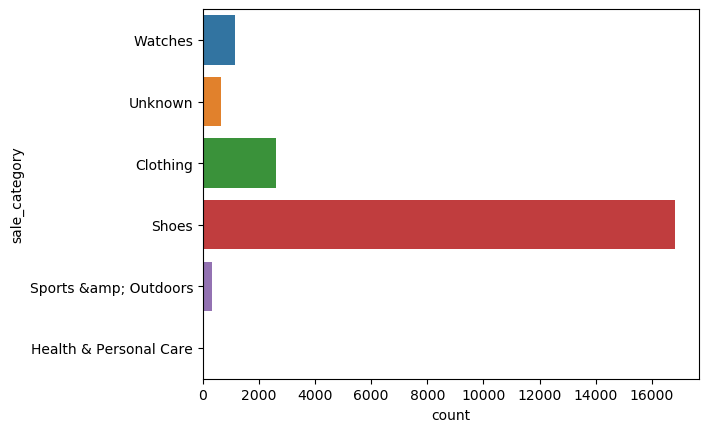

In [220]:
sns.countplot(data=documentclassifications, y="sale_category")

[Text(0.5, 1.0, 'Watches Sales Category')]

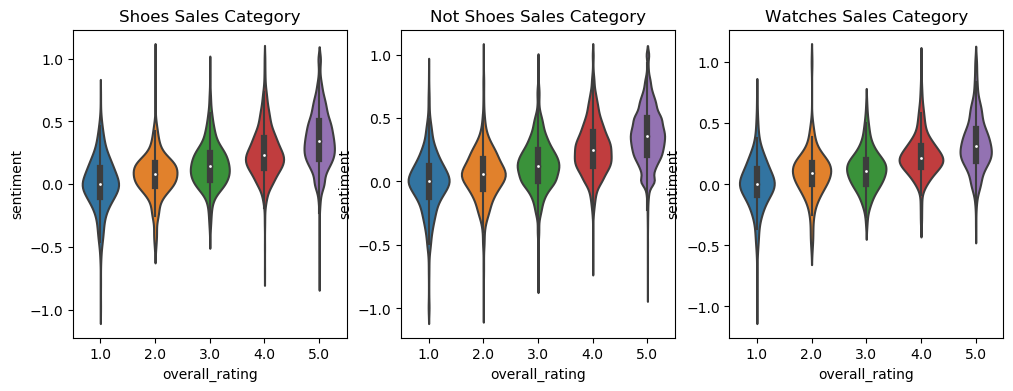

In [221]:
dc_shoes = documentclassifications[documentclassifications['sale_category'] == 'Shoes']
dc_watches = documentclassifications[documentclassifications['sale_category'] == 'Watches']
dc_not_shoes = documentclassifications[documentclassifications['sale_category'] != 'Shoes']

f, axes = plt.subplots(1,3, figsize=(12, 4))
sns.violinplot(data=dc_not_shoes, x="overall_rating", y="sentiment", ax=axes[0]).set(title='Shoes Sales Category')
sns.violinplot(data=dc_shoes, x="overall_rating", y="sentiment", ax=axes[1]).set(title='Not Shoes Sales Category')
sns.violinplot(data=dc_watches, x="overall_rating", y="sentiment", ax=axes[2]).set(title='Watches Sales Category')

In [222]:
df_sum_cats = documentclassifications[['sale_category','rank_1', 'sentiment']]
df_sum_cats['rank_1'] = [i.split(' ')[0] for i in df_sum_cats['rank_1']]
df_sum_cats = df_sum_cats.groupby(['sale_category','rank_1']).agg(['min','mean','max','count']).reset_index()
df_sum_cats.columns = ['_'.join(col) for col in df_sum_cats.columns]
df_sum_cats = df_sum_cats.rename(columns={'sale_category_': 'sale_category', 'rank_1_': 'rank_1', 'sentiment_count': 'count'})
df_sum_cats['sale_category_count'] = df_sum_cats.groupby('sale_category')['count'].transform('sum')
df_sum_cats['pct_of_sales_category'] = df_sum_cats['count'] / df_sum_cats['sale_category_count']
df_sum_cats

sale_category                     rank_1  sentiment_min  sentiment_mean  \
0       Clothing         10_shoe_love_great      -0.500000        0.410946   
1       Clothing           11_love_shoe_son      -0.500000        0.351738   
2       Clothing   12_wear_foot_comfortable      -0.700000        0.255725   
3       Clothing          13_shoe_buy_order      -0.500000        0.158172   
4       Clothing  14_shoe_great_comfortable      -0.100000        0.449218   
..           ...                        ...            ...             ...   
76       Watches            5_shoe_run_foot      -0.780000        0.058139   
77       Watches            6_fit_great_bag      -0.350000        0.195295   
78       Watches           7_shoe_nike_pair      -0.283333        0.118942   
79       Watches          8_good_shoe_great      -0.312500        0.443310   
80       Watches          9_color_shoe_love      -0.506667        0.286193   

    sentiment_max  count  sale_category_count  pct_of_sales_category  
0        1.000000    105                 2616               0.040138  
1        1.000000    210                 2616               0.080275  
2        1.000000    102                 2616               0.038991  
3        1.000000    158                 2616               0.060398  
4        1.000000     99                 2616               0.037844  
..            ...    ...                  ...                    ...  
76       0.261451     10                 1143               0.008749  
77       0.626190     25                 1143               0.021872  
78       0.582000     15                 1143               0.013123  
79       0.900000     32                 1143               0.027997  
80       0.716667     22                 1143               0.019248  

[81 rows x 8 columns]

In [223]:
df_sum_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sale_category          81 non-null     object 
 1   rank_1                 81 non-null     object 
 2   sentiment_min          81 non-null     float64
 3   sentiment_mean         81 non-null     float64
 4   sentiment_max          81 non-null     float64
 5   count                  81 non-null     int64  
 6   sale_category_count    81 non-null     int64  
 7   pct_of_sales_category  81 non-null     float64
dtypes: float64(4), int64(2), object(2)
memory usage: 5.2+ KB


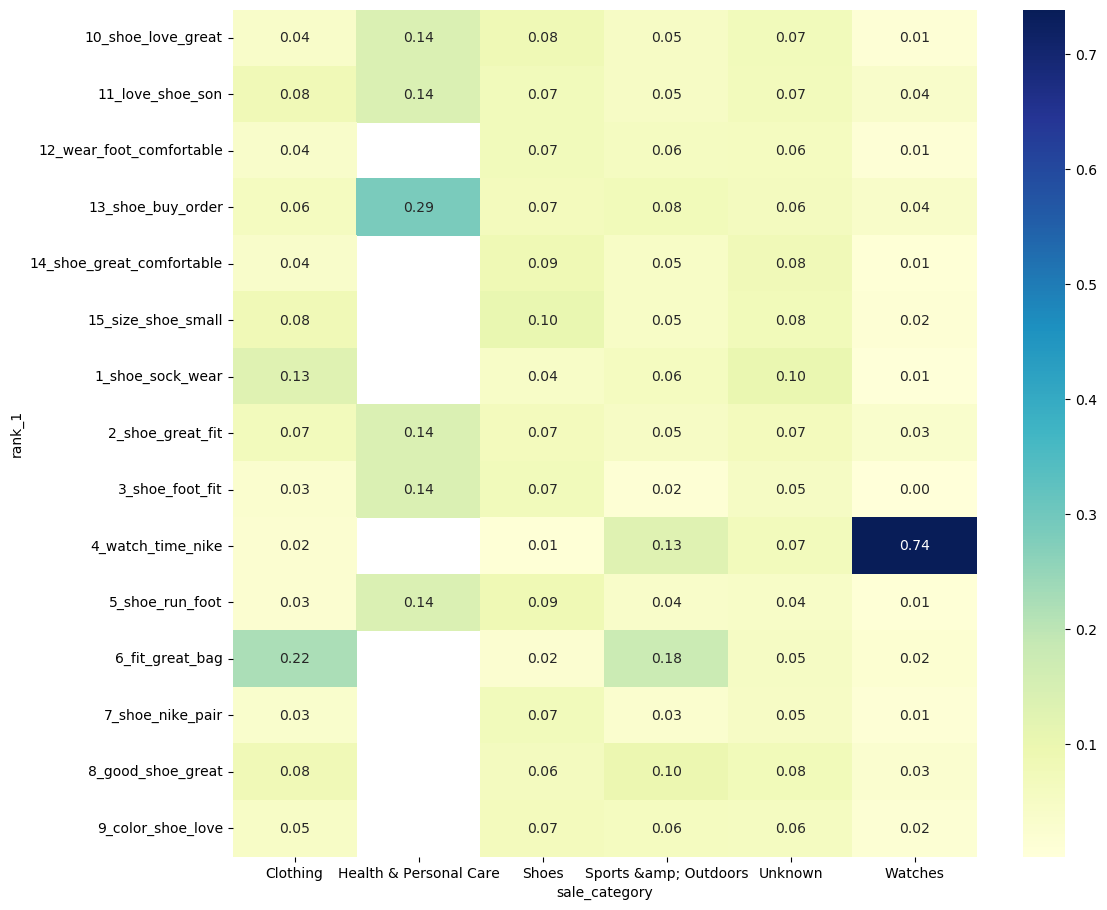

In [224]:
df_heat = df_sum_cats[['sale_category','rank_1', 'pct_of_sales_category']].pivot("rank_1", "sale_category", "pct_of_sales_category")
f, axes = plt.subplots(1,1, figsize=(12, 11))
sns.heatmap(data=df_heat, cmap="YlGnBu", annot=True, fmt='.2f', ax=axes)

## Investigate Issues

In [123]:
#lookup where reviews talk about battery issues
print('Results:')
lookup = documentclassifications[documentclassifications['text'].str.contains('battery')]
lookup.head()

Results:


rank_1  \
document                                              
9                  30_size_small_order_big (0.4941)   
13                 6_watch_band_wrist_face (0.6639)   
15        18_fast_arrive_delivery_shipping (0.3607)   
31               19_watch_time_feature_set (0.8638)   
34                 6_watch_band_wrist_face (0.8049)   

                                             rank_2  \
document                                              
9                   19_watch_time_feature_set (0.2)   
13                  25_old_son_year_school (0.1518)   
15        26_sneaker_look_love_comfortable (0.2714)   
31               22_size_small_order_half (0.08793)   
34             17_return_order_seller_send (0.1259)   

                                          rank_3  \
document                                           
9         18_fast_arrive_delivery_shipping (0.2)   
13             24_boot_pair_wear_sandal (0.1518)   
15              6_watch_band_wrist_face (0.1821)   
31            30_size_small_order_big (0.001724)   
34            30_size_small_order_big (0.002469)   

                                                       text        asin  \
document                                                                  
9         when it arrived, it had a dead battery--SO, I ...  B0000V9KRS   
13        I have used a similar watch (Arctic Blue) for ...  B00012O2MO   
15        I've had several of these watches in various c...  B00012O2O2   
31        I had this watch for exactly 12 DAYS, exactly....  B00019FWE4   
34        I'm on my 4th watch... I keep returning it due...  B00019FWE4   

          overall_rating     reviewer_id sale_category  sale_rank  \
document                                                            
9                    4.0  A1UY8BIKG0VR12       Watches   163955.0   
13                   5.0   AXN13FXXKRZDH       Unknown        NaN   
15                   5.0  A18GGD59BKK1V9       Watches    12370.0   
31                   1.0  A2UU3I9VAGNVRB       Watches    94022.0   
34                   1.0  A33YUJRHG1CSC5       Watches    94022.0   

                                                      title  sentiment  
document                                                                
9                                          Nike - WT0010701   0.345758  
13        WOMENS NIKE PRESTO CHRONO SIZE MEDIUM WATCH WT...   0.209545  
15        Nike Presto Cee Analog Small Ladies - Green Wa...   0.281636  
31        Nike Oregon Series Digital Super Watch WA0024-001   0.122327  
34        Nike Oregon Series Digital Super Watch WA0024-001  -0.131250

## Generate Topic Wordcloud

In [ ]:
# some options for wordcloud output
img_w = 400   # image width
img_h = 300   # image height

topic_clouds = generate_wordclouds_for_topic_words(
    model_main.topic_word_, vocab_main,
    top_n=20, topic_labels=topic_labels_main,
    width=img_w, height=img_h
)

# show all generated word clouds
topic_clouds.keys()

dict_keys(['1_shoe_foot_toe', '2_love_son_gift', '3_shoe_great_run', '4_shoe_nike_know', '5_shoe_foot_day', '6_price_good_buy', '7_pair_nike_air', '8_play_shoe_basketball', '9_love_comfortable_fit', '10_size_small_order', '11_color_black_white', '12_watch_band_wrist', '13_sock_sandal_foot', '14_order_return_size', '15_bag_shirt_gym', '16_product_great_good'])

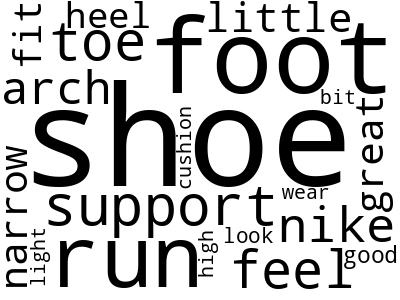

In [ ]:
#display wordcloud for a topic
topic_clouds['1_shoe_foot_toe']

# 8.&nbsp; Results

# 9.&nbsp; References